In [1]:
import sys
import os
sys.path.append("../src/")
import combat
import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl
from sklearn.linear_model import LogisticRegression, Lasso, Ridge, ElasticNet
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 500
from sklearn.preprocessing import quantile_transform,binarize
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import multipletests
from sklearn.cross_decomposition import PLSRegression as PLS
import warnings
warnings.simplefilter("ignore")
from multiprocessing import Process,Queue,Pool
import time 
import helper
from multiprocessing import set_start_method
#set_start_method("spawn")
from DecoID.DecoID import flatten
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVC
import importlib
import helper#import the module here, so that it can be reloaded.
importlib.reload(helper)


<module 'helper' from '../src\\helper.py'>

        Model                                             Params Baseline  \
1  ElasticNet  {'feat_selection': ('corr', 0.4444444444444444...     none   

      Score  Training Score  
1  0.838154        0.914141  
{'feat_selection': ('corr', 0.4444444444444444), 'alpha': 10, 'l1_ratio': 0.0}


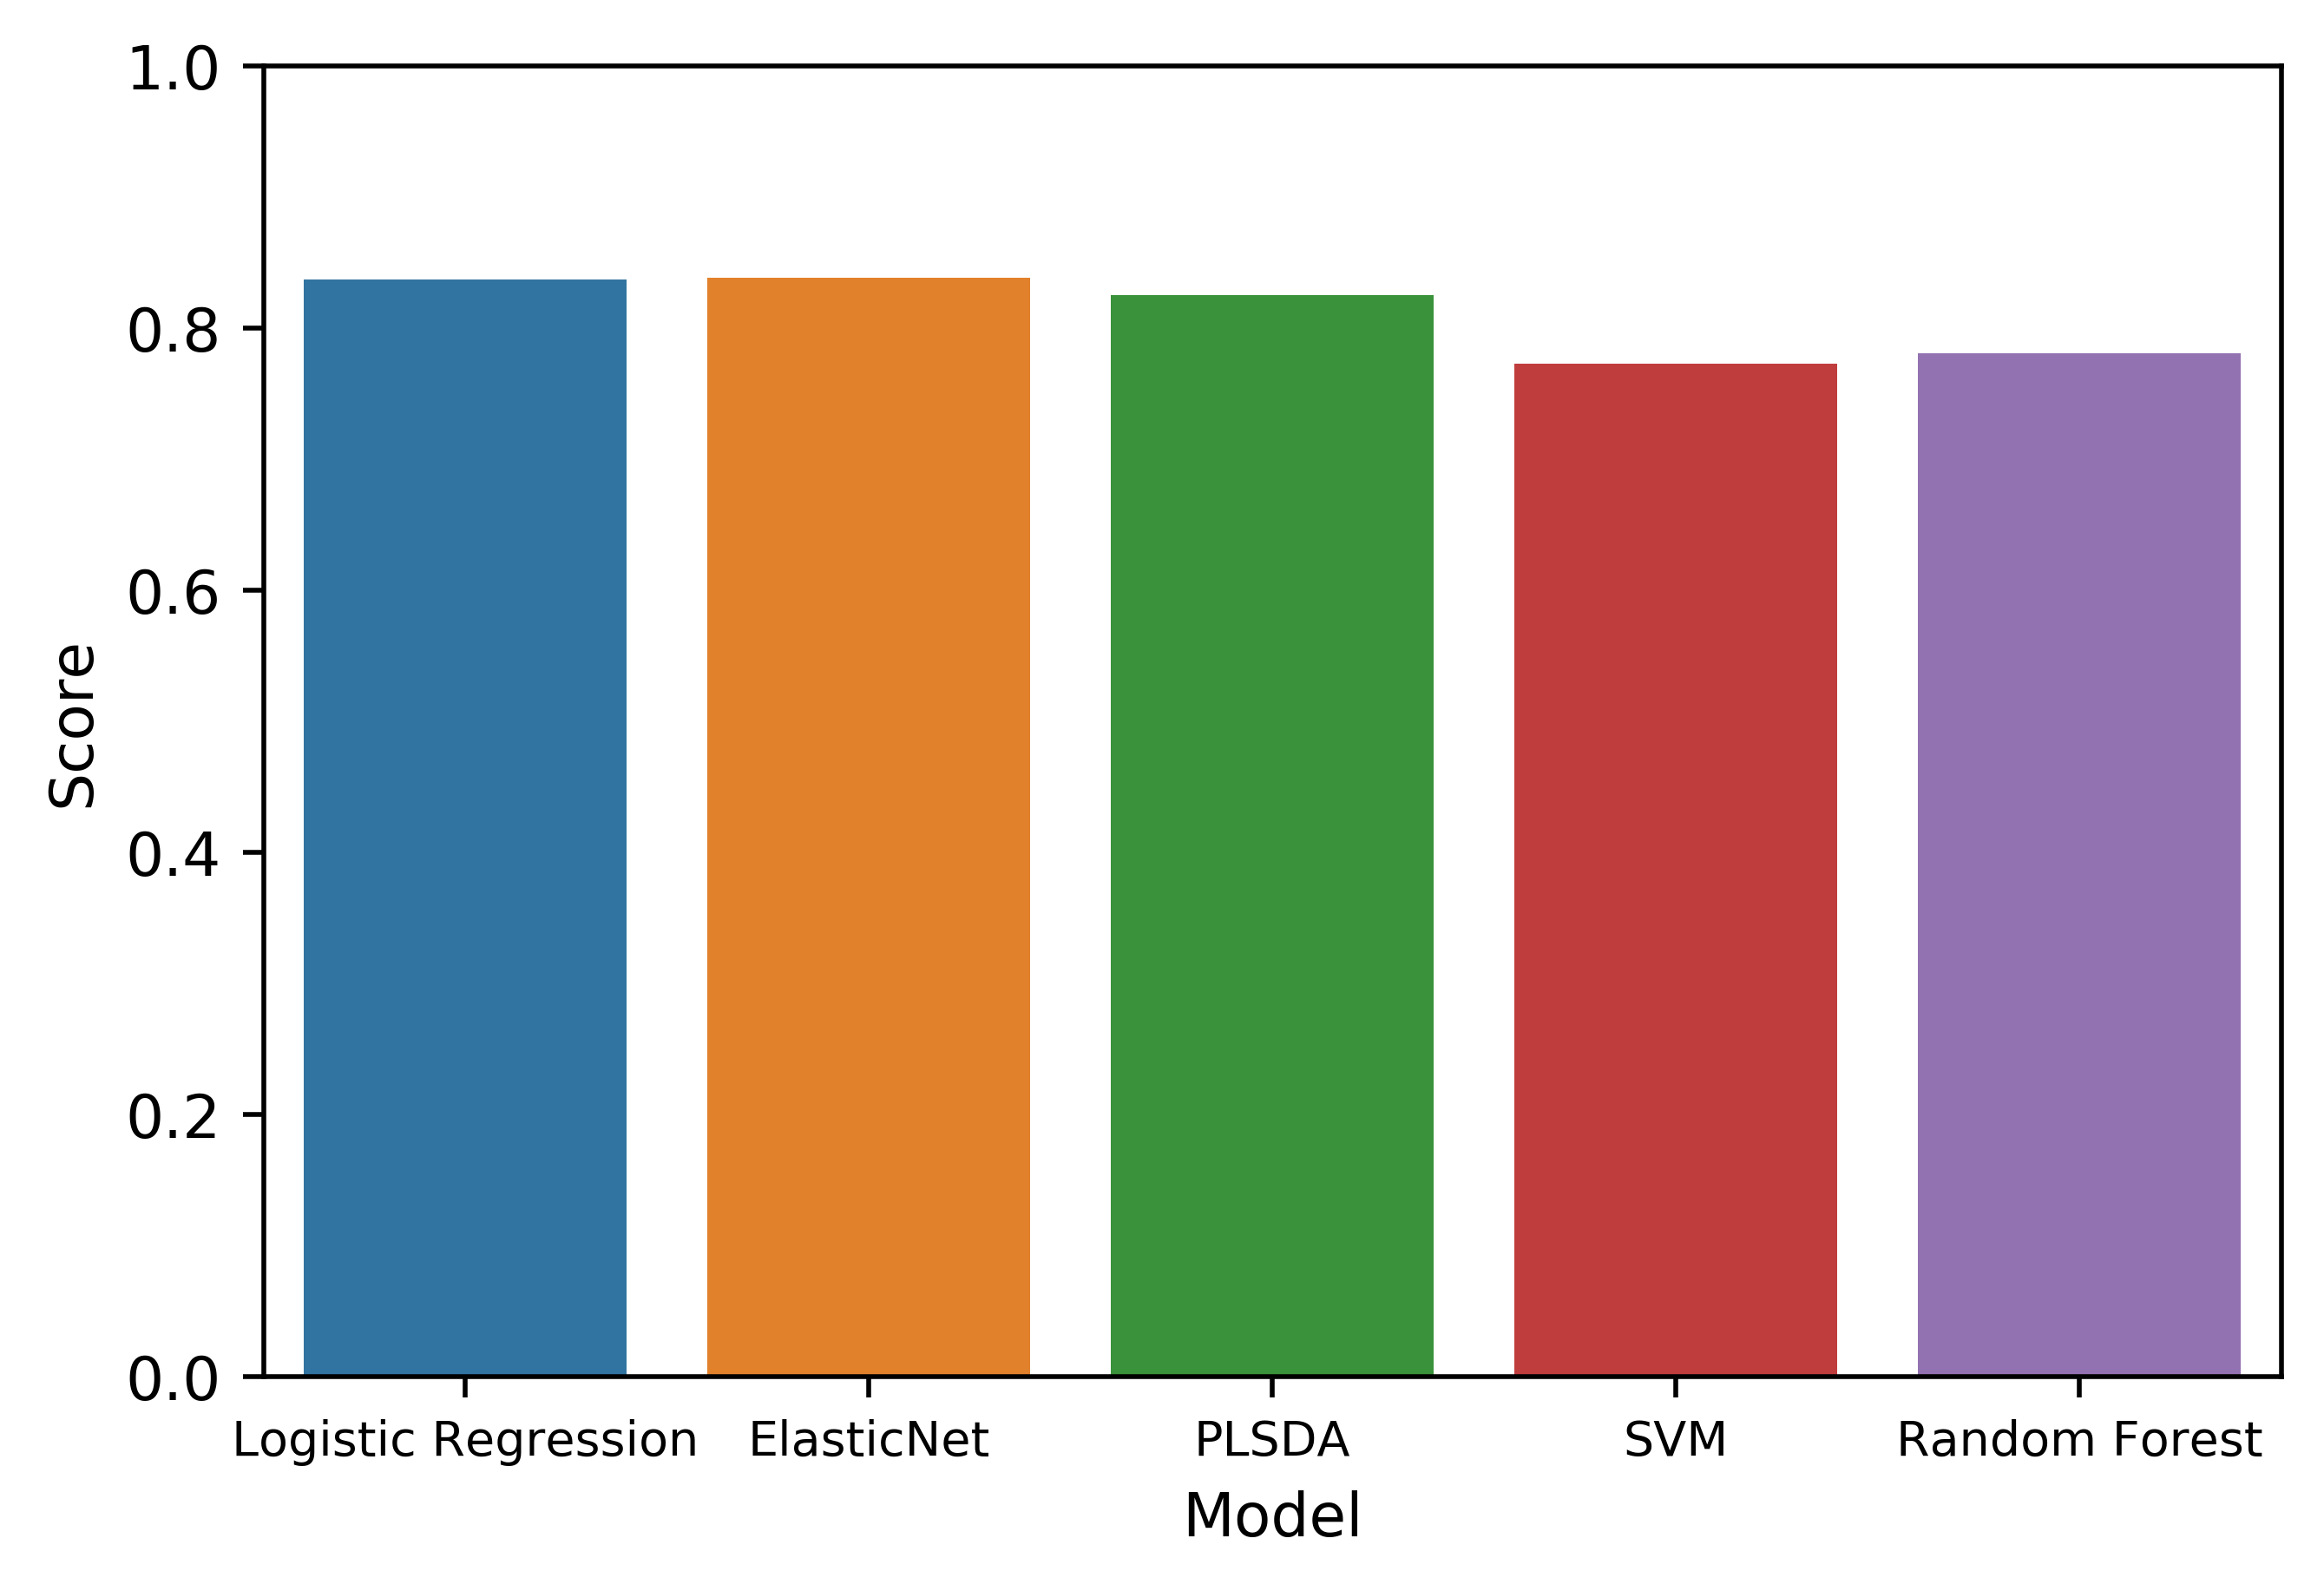

In [39]:
results = pkl.load(open("modeling_results_qTOF_ICU.pkl","rb"))
#plot results

results = results[results["Baseline"] == "none"]
sb.barplot(x="Model",y="Score",data=results)
plt.xticks(fontsize=8)
plt.ylim((0,1))

#print(results)
results = results[results["Score"] < results["Training Score"]]
#results = results[results["Score"] > results["Training Score"] * 2/3]
bestParams = results[results["Score"] == results["Score"].max()]
ind = bestParams.index.values[0]
print(bestParams)
print(bestParams.at[ind,"Params"])
baseline = bestParams.at[ind,"Baseline"]
params = bestParams.at[ind,"Params"]
model = bestParams.at[ind,"Model"]
model_names = ["Logistic Regression","ElasticNet","PLSDA","SVM","Random Forest"]
model_train_funcs = [helper.trainLogisticRegression,helper.trainElasticNet,helper.trainPLSDA,helper.trainSVM,helper.trainRF]
model_predict_funcs = [helper.predictLogisticRegression,helper.predictElasticNet,helper.predictPLSDA,helper.predictSVM,helper.predictRF]
train_mapping = {name:func for name,func in zip(model_names,model_train_funcs)}
predict_mapping = {name:func for name,func in zip(model_names,model_predict_funcs)}

trainFunc,predictFunc = train_mapping[model],predict_mapping[model]





In [40]:
#load in metadata and peak areas and associate

#read in peak data
datafilename = "../data/QTof-B1-9_pHILIC_HSS_pos-neg.csv"

data = pd.read_csv(datafilename)

#get area columns
areaCols = data.columns.values[9:]

#get molecule names
mol_names = data["Compound Name"].values

#extract area data and transpose
areaData = data[areaCols].transpose()

#get batch information
batchInfo = [int(x.split("_")[0][1]) for x in list(areaData.index.values)]

areaData = areaData.to_numpy()
areaData = areaData.astype(np.float)

#get index of blanks
blankSamp = [x for x in range(len(areaCols)) if "Blank" in areaCols[x] and not "equil" in areaCols[x]]
print(len(blankSamp)," blanks")

#get index of qc
qcSamp = [x for x in range(len(areaCols)) if "NIST" in areaCols[x] and not "equil" in areaCols[x] ]
print(len(qcSamp)," qc samples")

#get index of wu350 samples
samp = [x for x in range(len(areaCols)) if "WU350" in areaCols[x] and not "equil" in areaCols[x]]
print(len(samp), "research samples")

#load in metadata
metadatafn = "../data/Experiment-Parameters_b1-9.csv"
metadata = pd.read_csv(metadatafn)

#extact sample names for d0_yes samples
metadata_rel = metadata[metadata["day-COVID"] == "d0_Yes"]
print(len(metadata_rel)," d0 Covid+ Samples")

metadata_val = metadata[metadata["day-COVID"] == "d0_No"]
print(len(metadata_val), "d0 Covid- Samples")

val_samples = []
for index,row in metadata_val.iterrows():
    val_samples.append(row["Sample General Name"])
    
val_cols = []
for val_s in val_samples:
    for col in range(len(areaCols)):
        if areaCols[col] == val_s:
            val_cols.append(col)
            break

            
#create sample name, ventilator status linkage
vent_dict = {}
metadata_dict = {}
for index,row in metadata_rel.iterrows():
    val = str(row["ICU"])
    sampName = row["Sample General Name"]
    if "es" in val:
        val = 1
    elif "o" in val:
        val = 0
    vent_dict[sampName] = val
    metadata_dict[sampName] = row

print(np.sum(list(vent_dict.values()))," ICU+ samples")
print(len(vent_dict) - np.sum(list(vent_dict.values())),"ICU- samples")

#link vent status to sample in peak data
vent_status = []
metadata_for_samples = []
for s in np.array(areaCols)[samp]:
    tmp = s
    if tmp in vent_dict:
        vent_status.append(vent_dict[tmp])
        metadata_for_samples.append(metadata_dict[tmp])
    else:
        vent_status.append(-1)
        metadata_for_samples.append(-1)
print("found vent info for",len([x for x in vent_status if x != -1]),"covid_ d0 samples")
samplesOfInterest = [x for x in range(len(vent_status)) if vent_status[x] != -1]

val_int = areaData[val_cols]
val_batch = np.array(batchInfo)[val_cols]
val_vent = np.array([0 for _ in val_batch])

#create sample matrix
samp_batch = np.array(batchInfo)[samp][samplesOfInterest]
samp_int = areaData[samp][samplesOfInterest]
samp_vent = np.array(vent_status)[samplesOfInterest]
samp_metadata = [metadata_for_samples[x] for x in samplesOfInterest]

#create blank matrix
blank_batch = np.array(batchInfo)[blankSamp]
blank_int = areaData[blankSamp]

#create qc matrix
qc_batch = np.array(batchInfo)[qcSamp]
qc_int = areaData[qcSamp]

ValueError: invalid literal for int() with base 10: 'n'

227654


No handles with labels found to put in legend.


0


Text(0, 0.5, 'PC2')

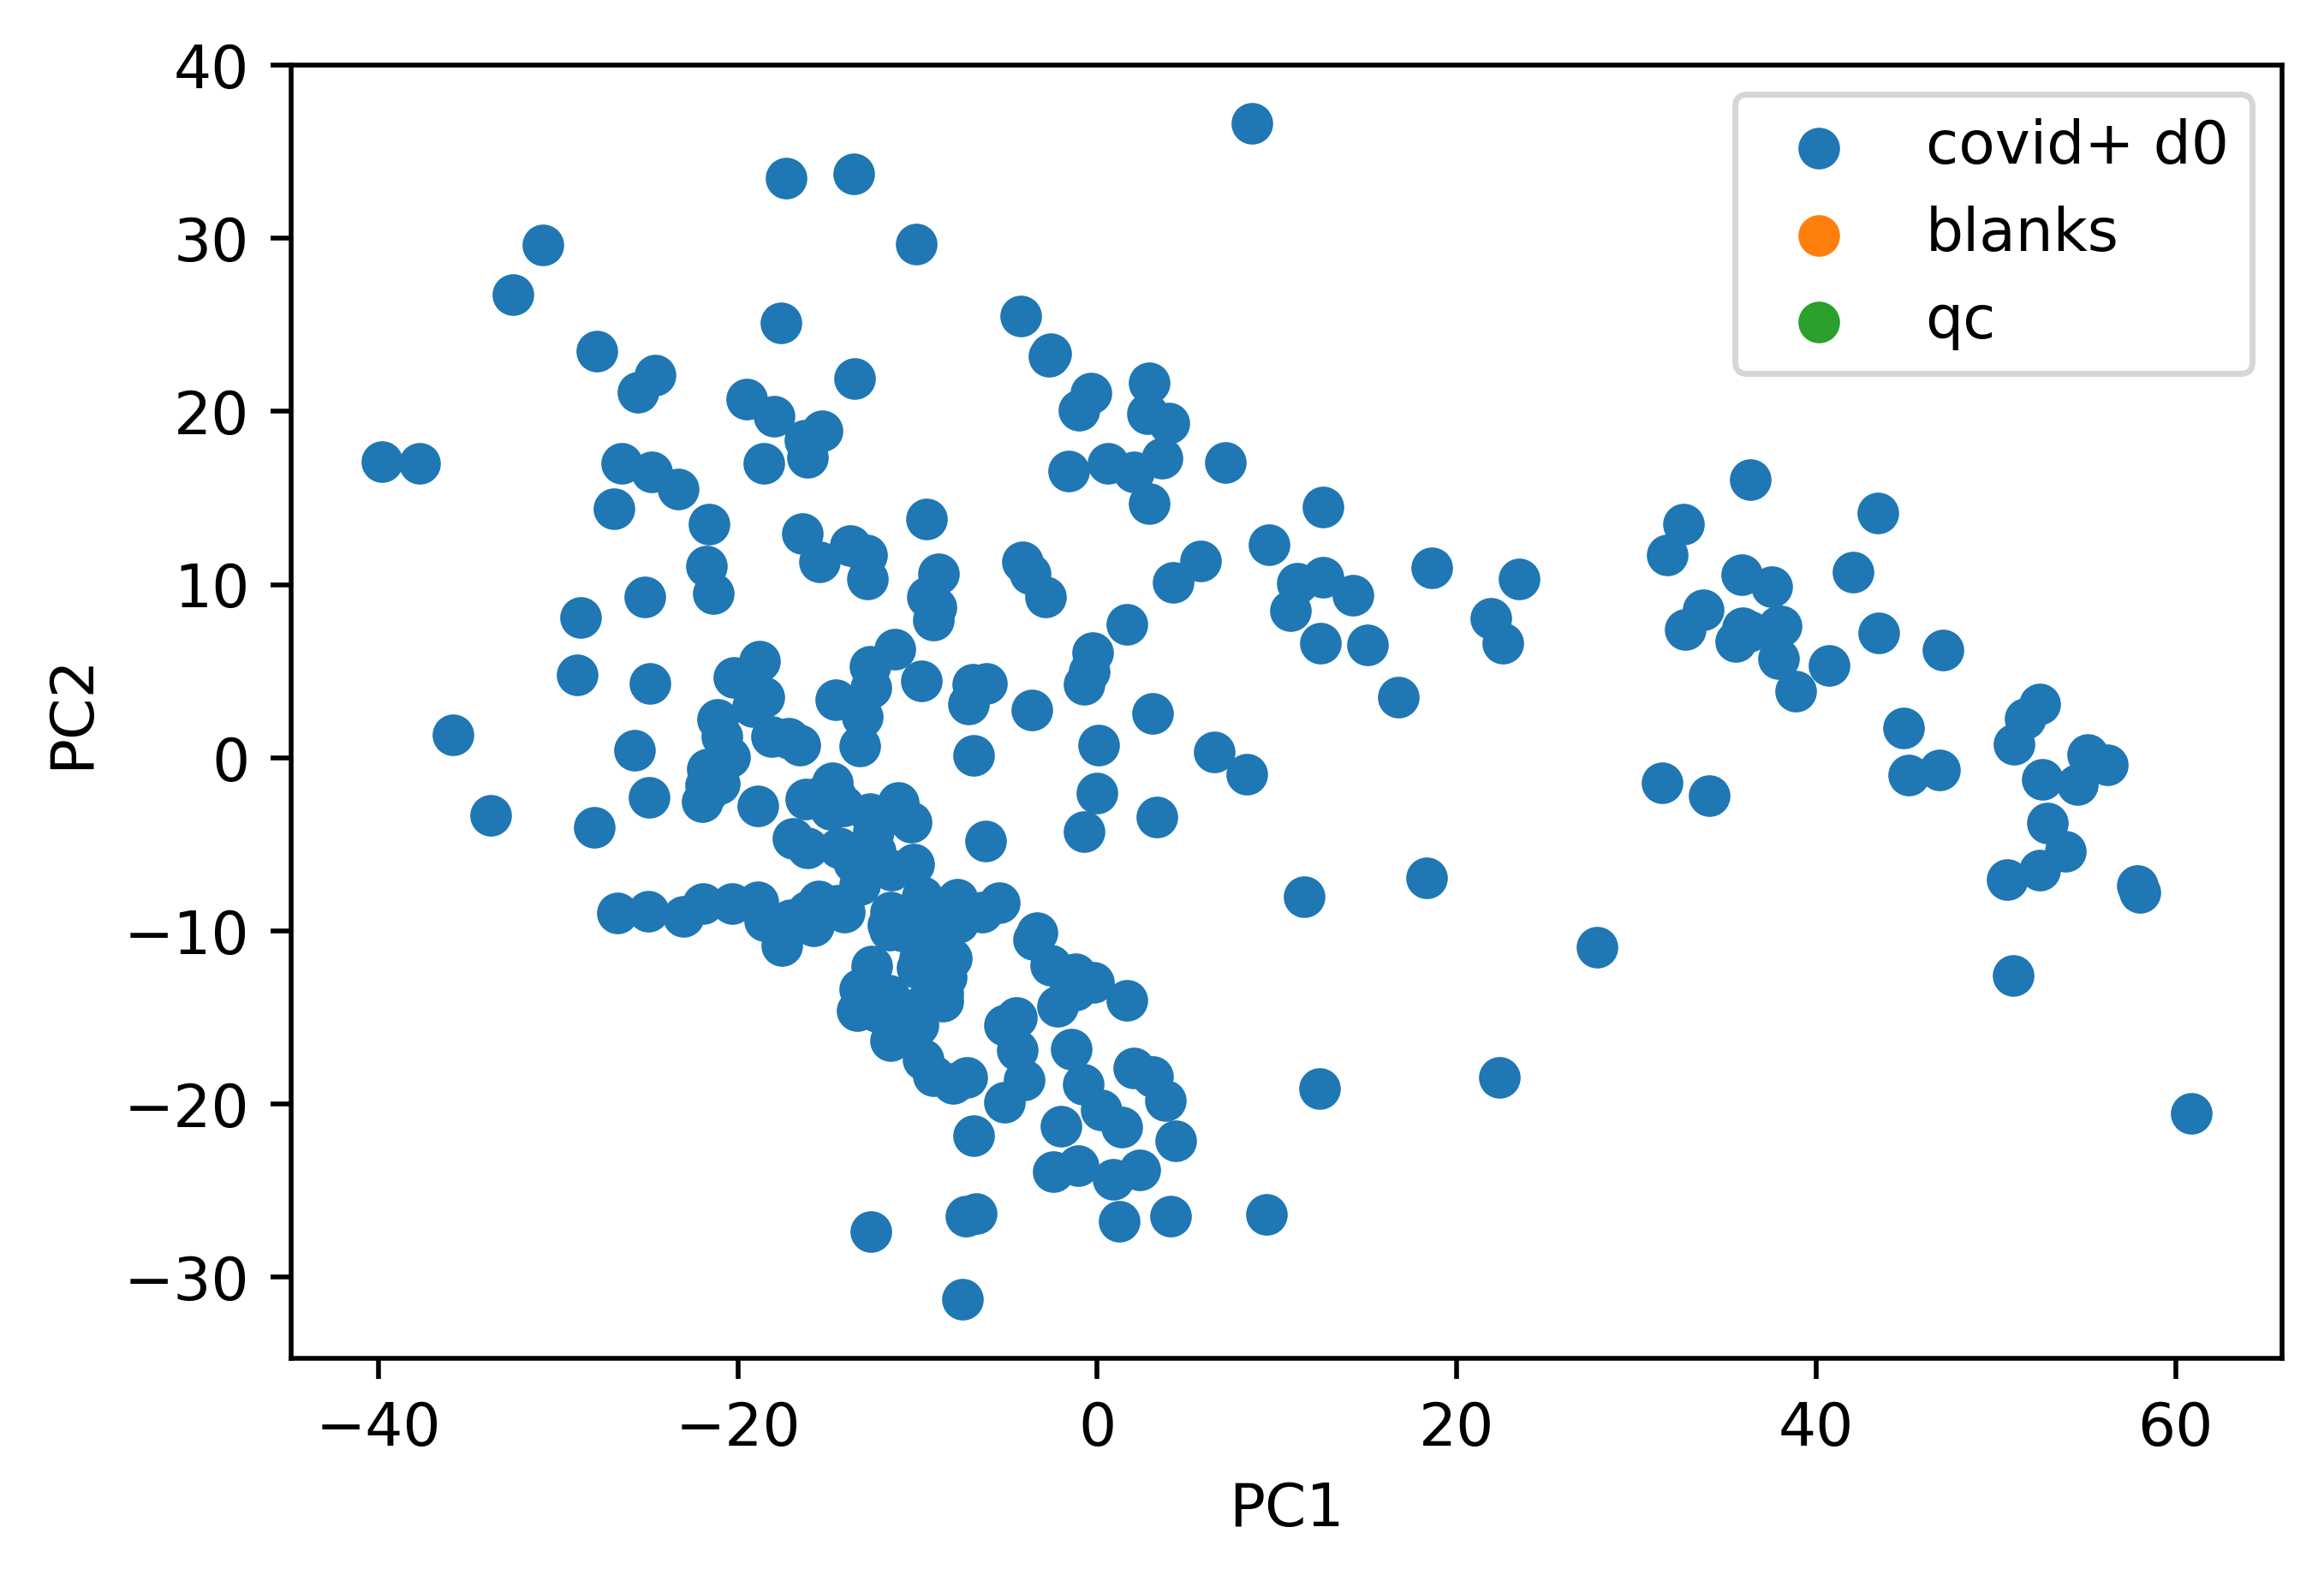

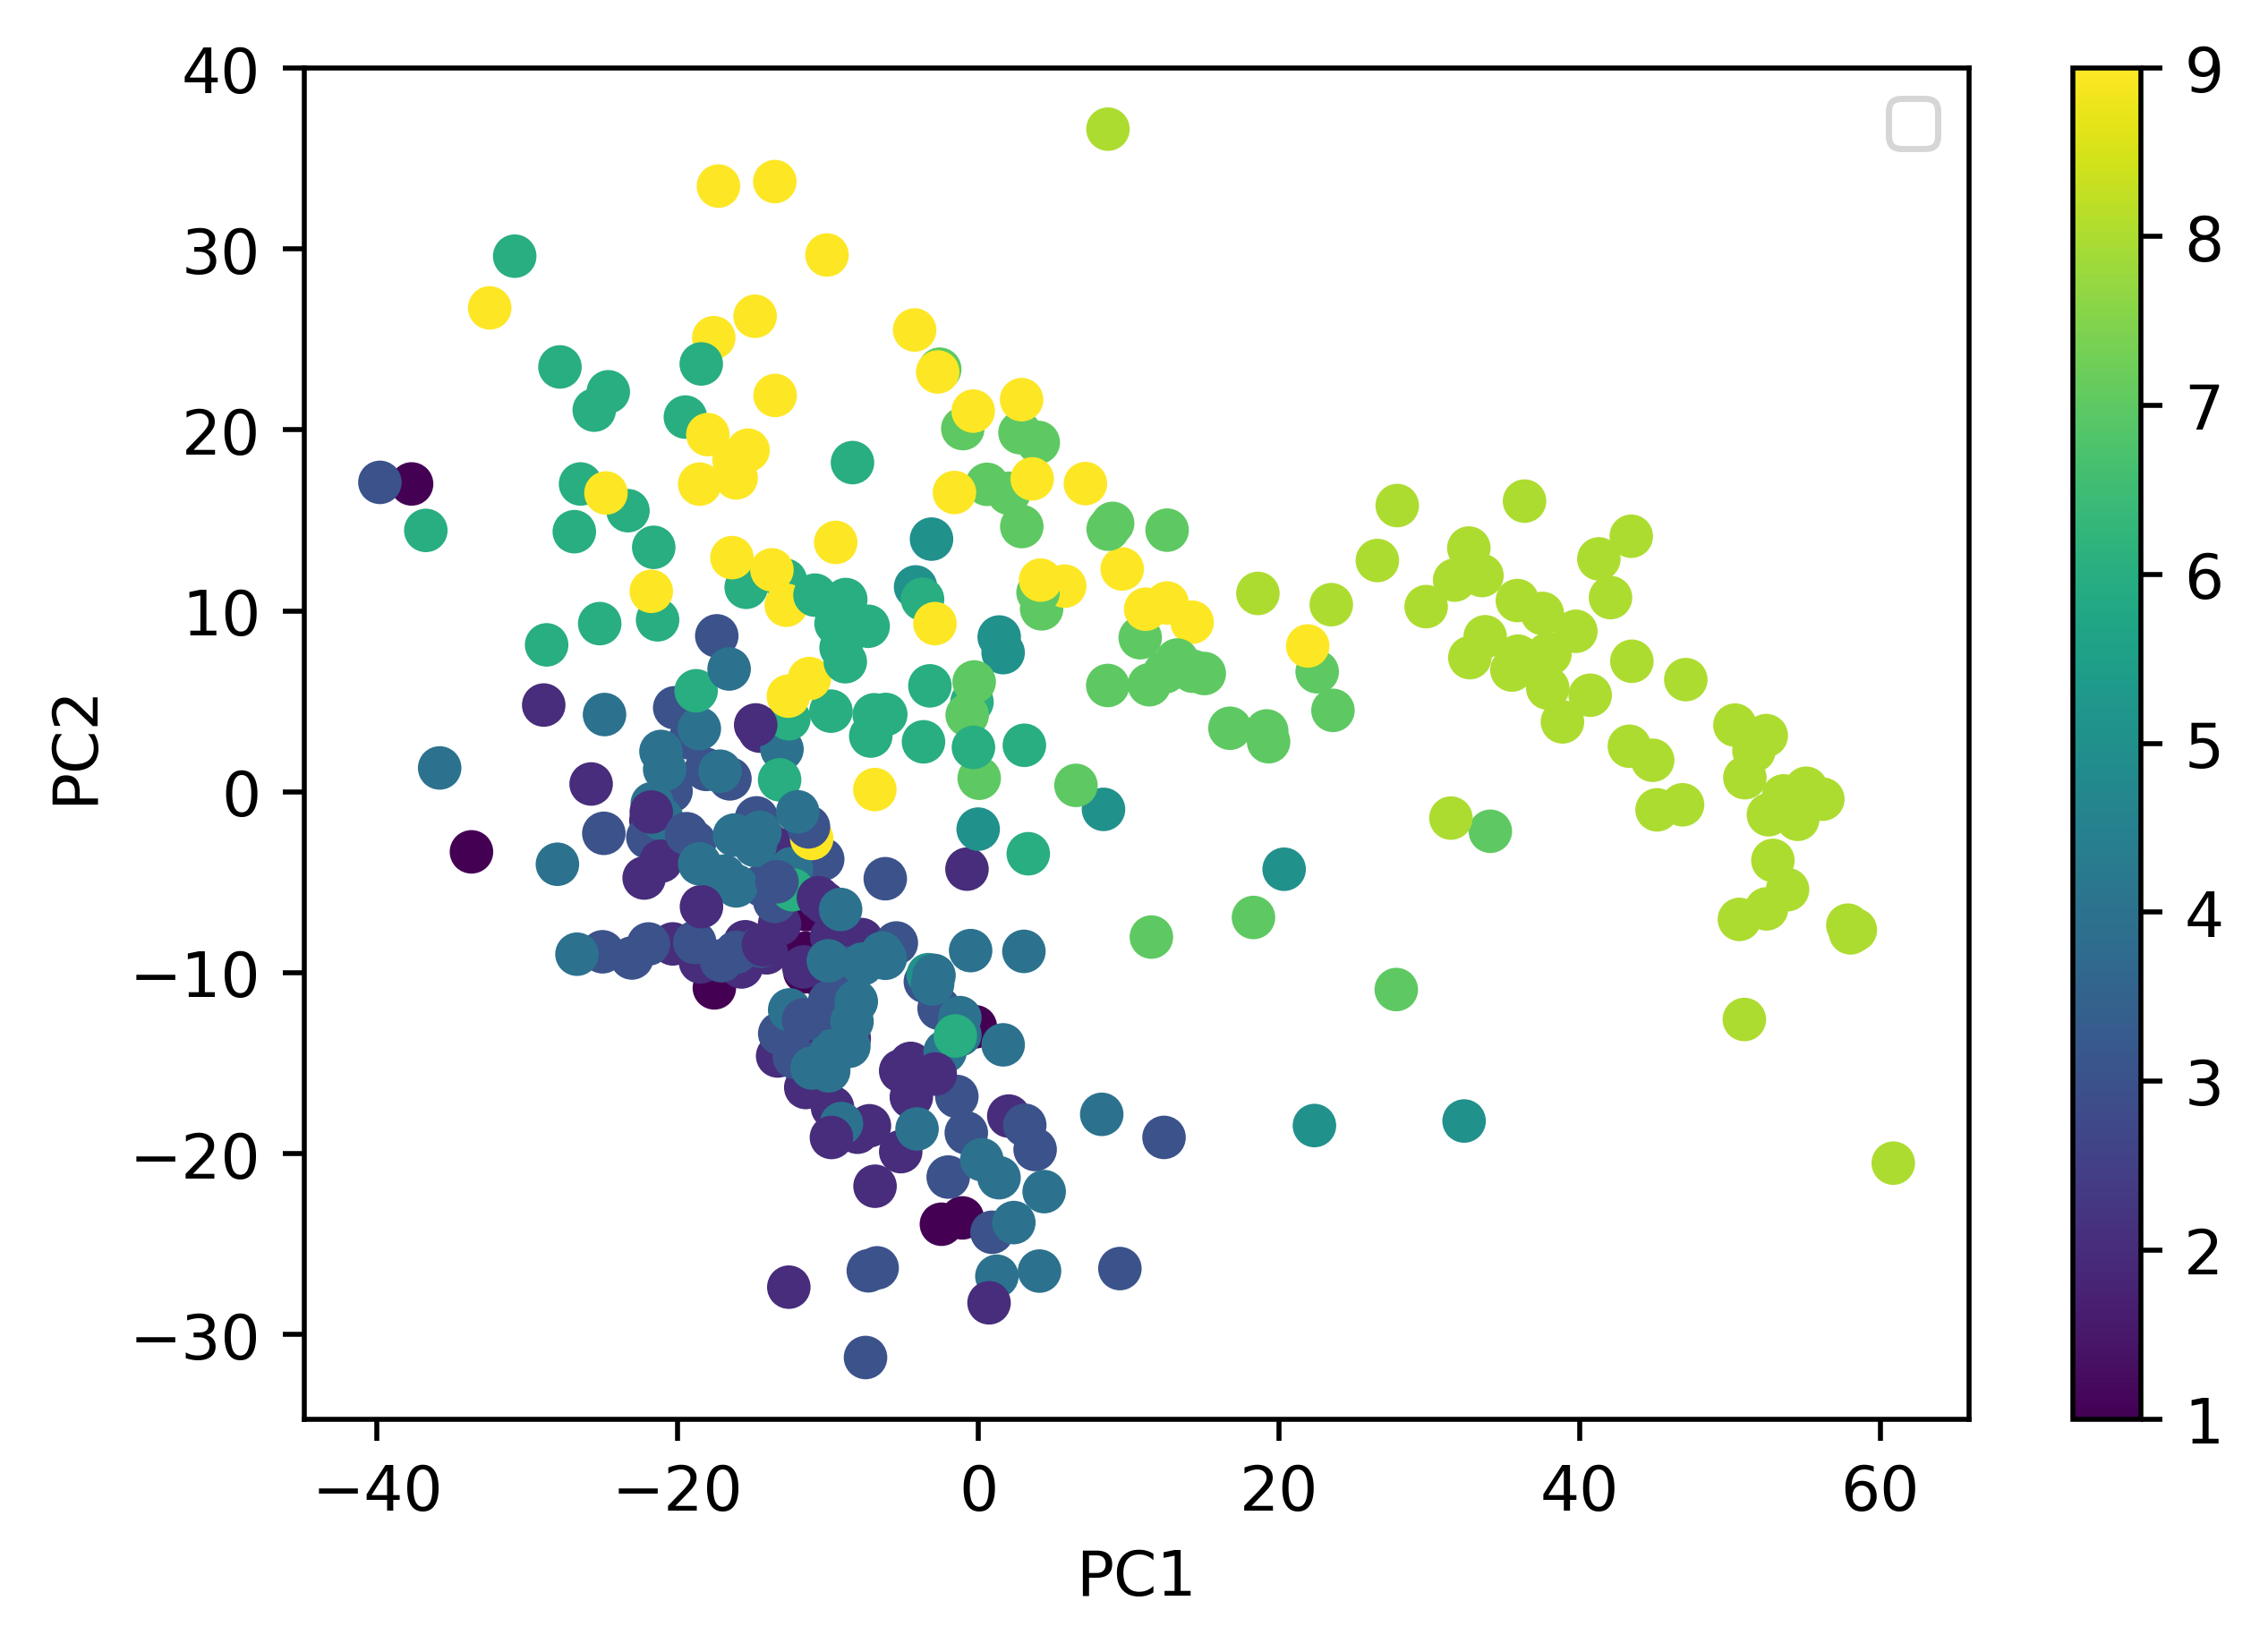

In [4]:
#visualize complete dataset

#first impute dataset
d_whole = np.concatenate((samp_int,blank_int,qc_int,val_int))
d_whole_imput = helper.imputeRowMin(d_whole)

#log2 normalize
d_whole_imput = np.log2(d_whole_imput) 

#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_imput)
loads = pca.transform(d_whole_imput)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")


found 9 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments
No handles with labels found to put in legend.


Adjusting data


Text(0, 0.5, 'PC2')

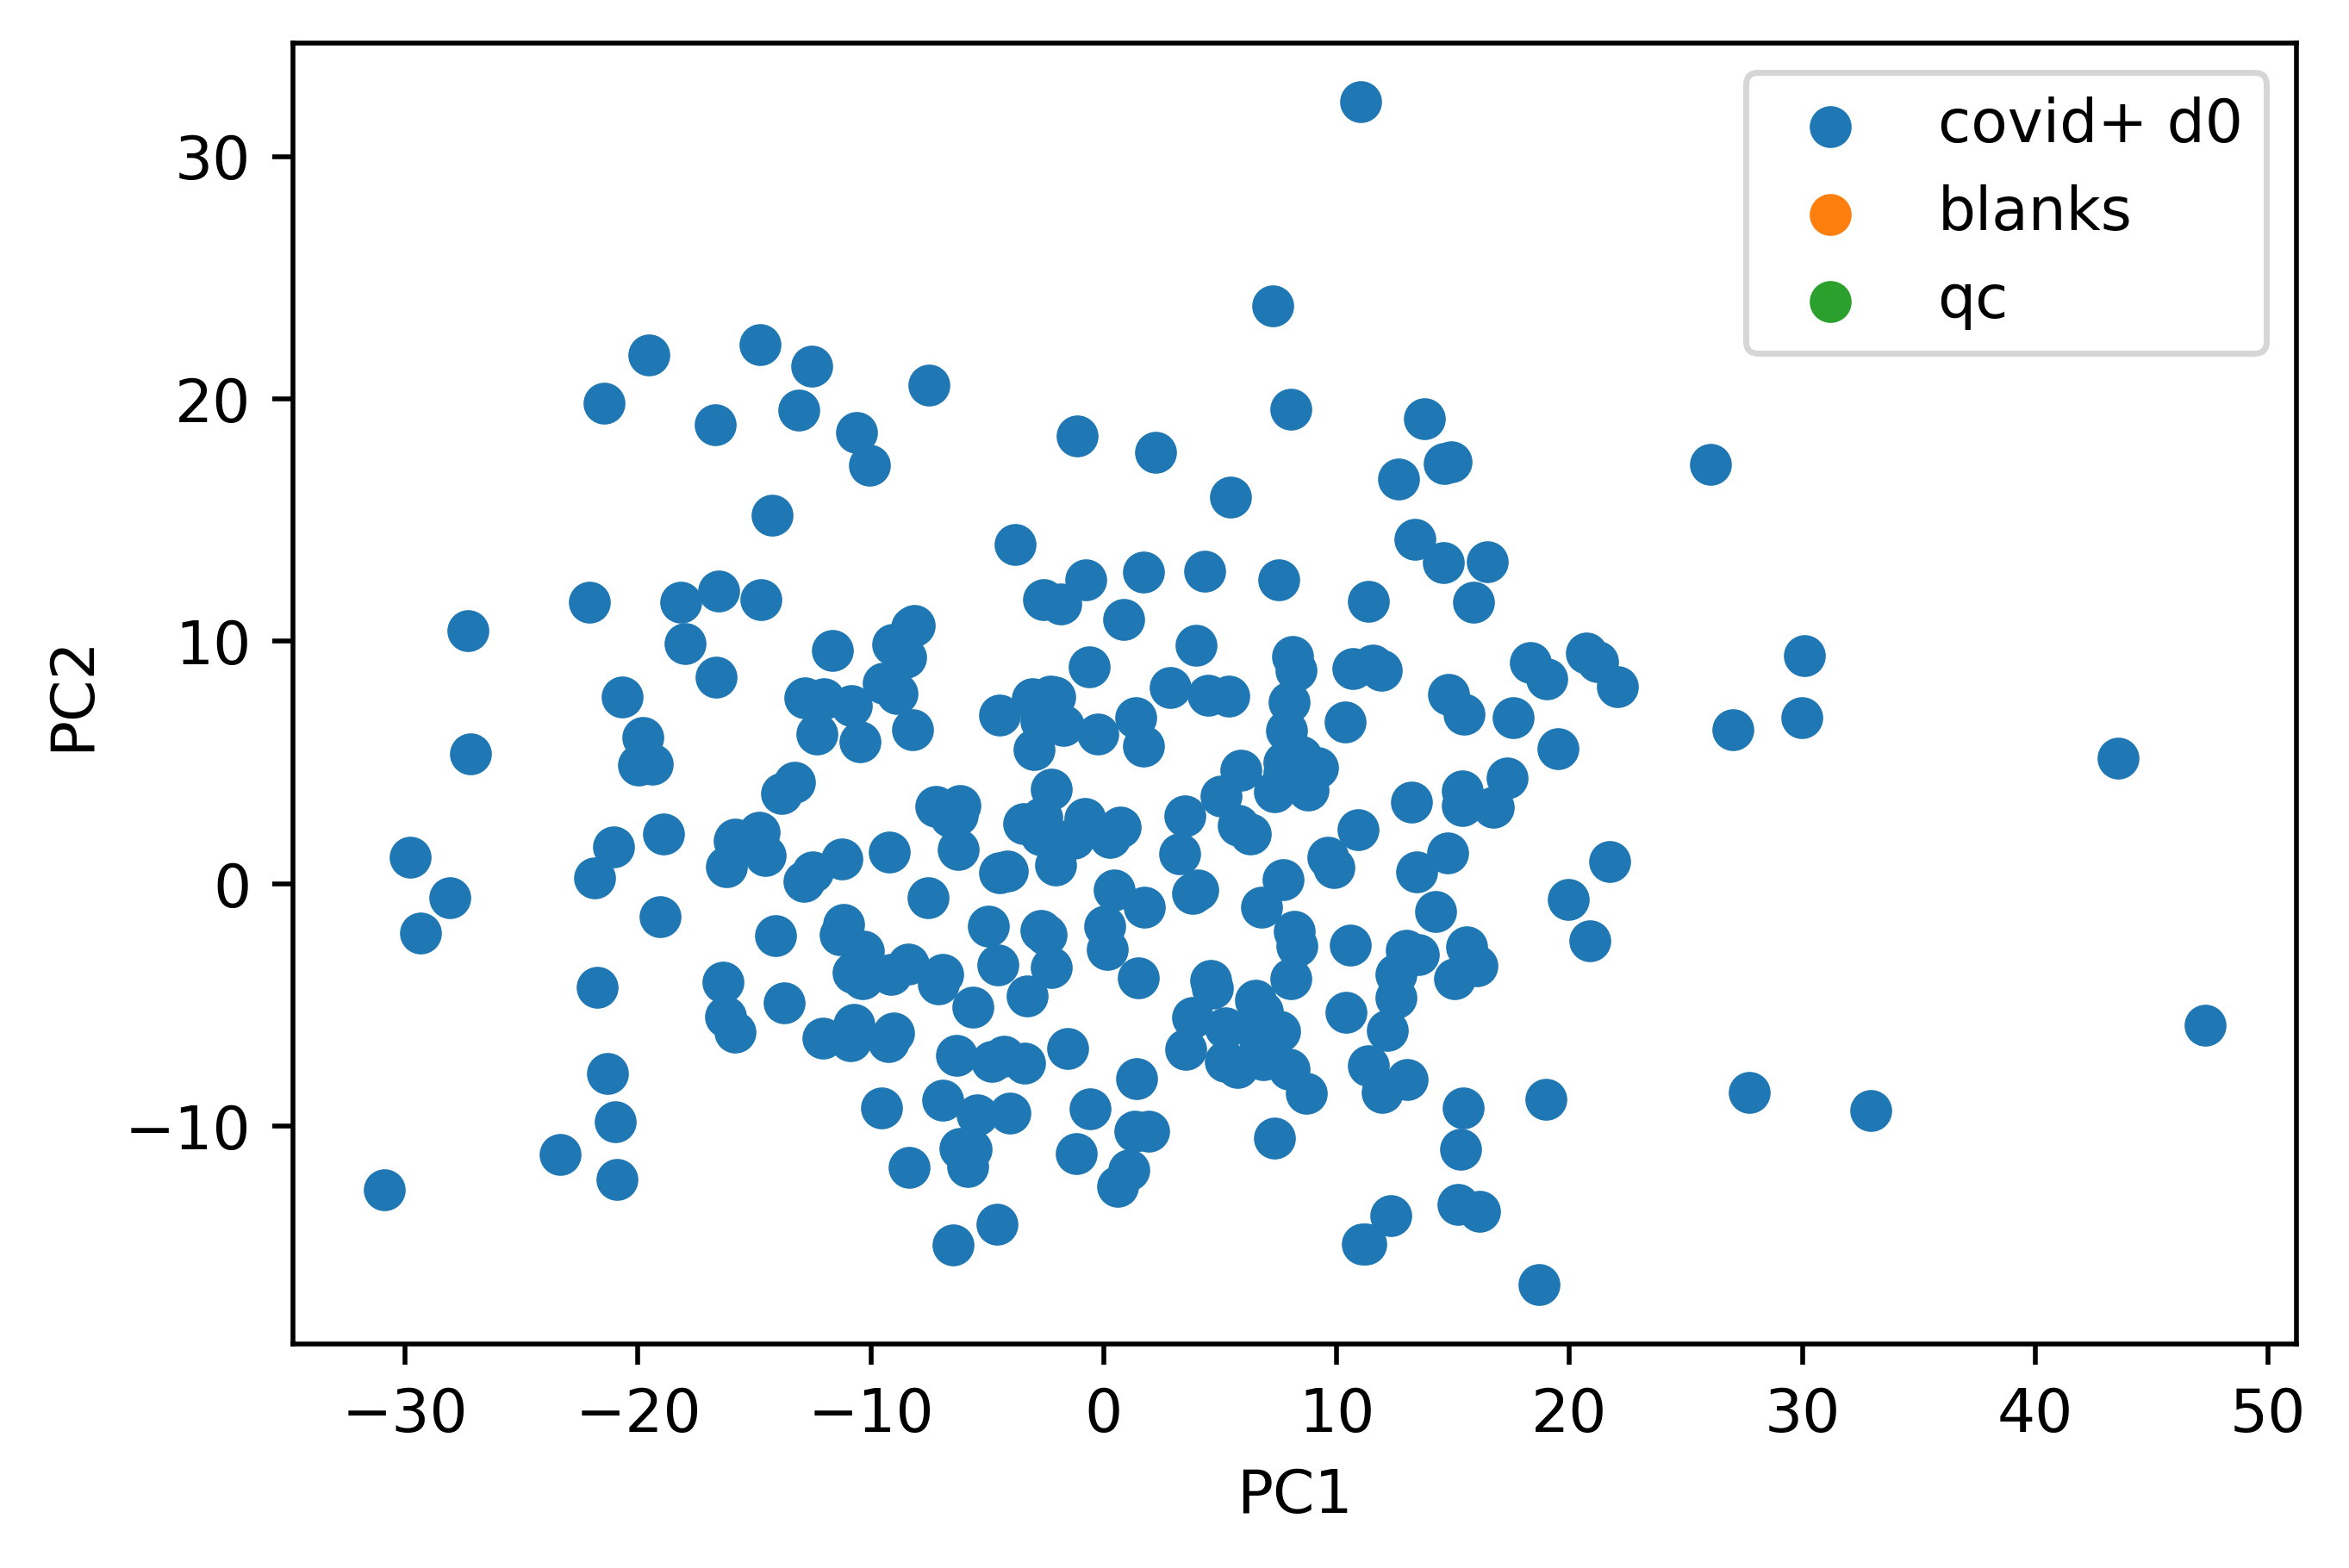

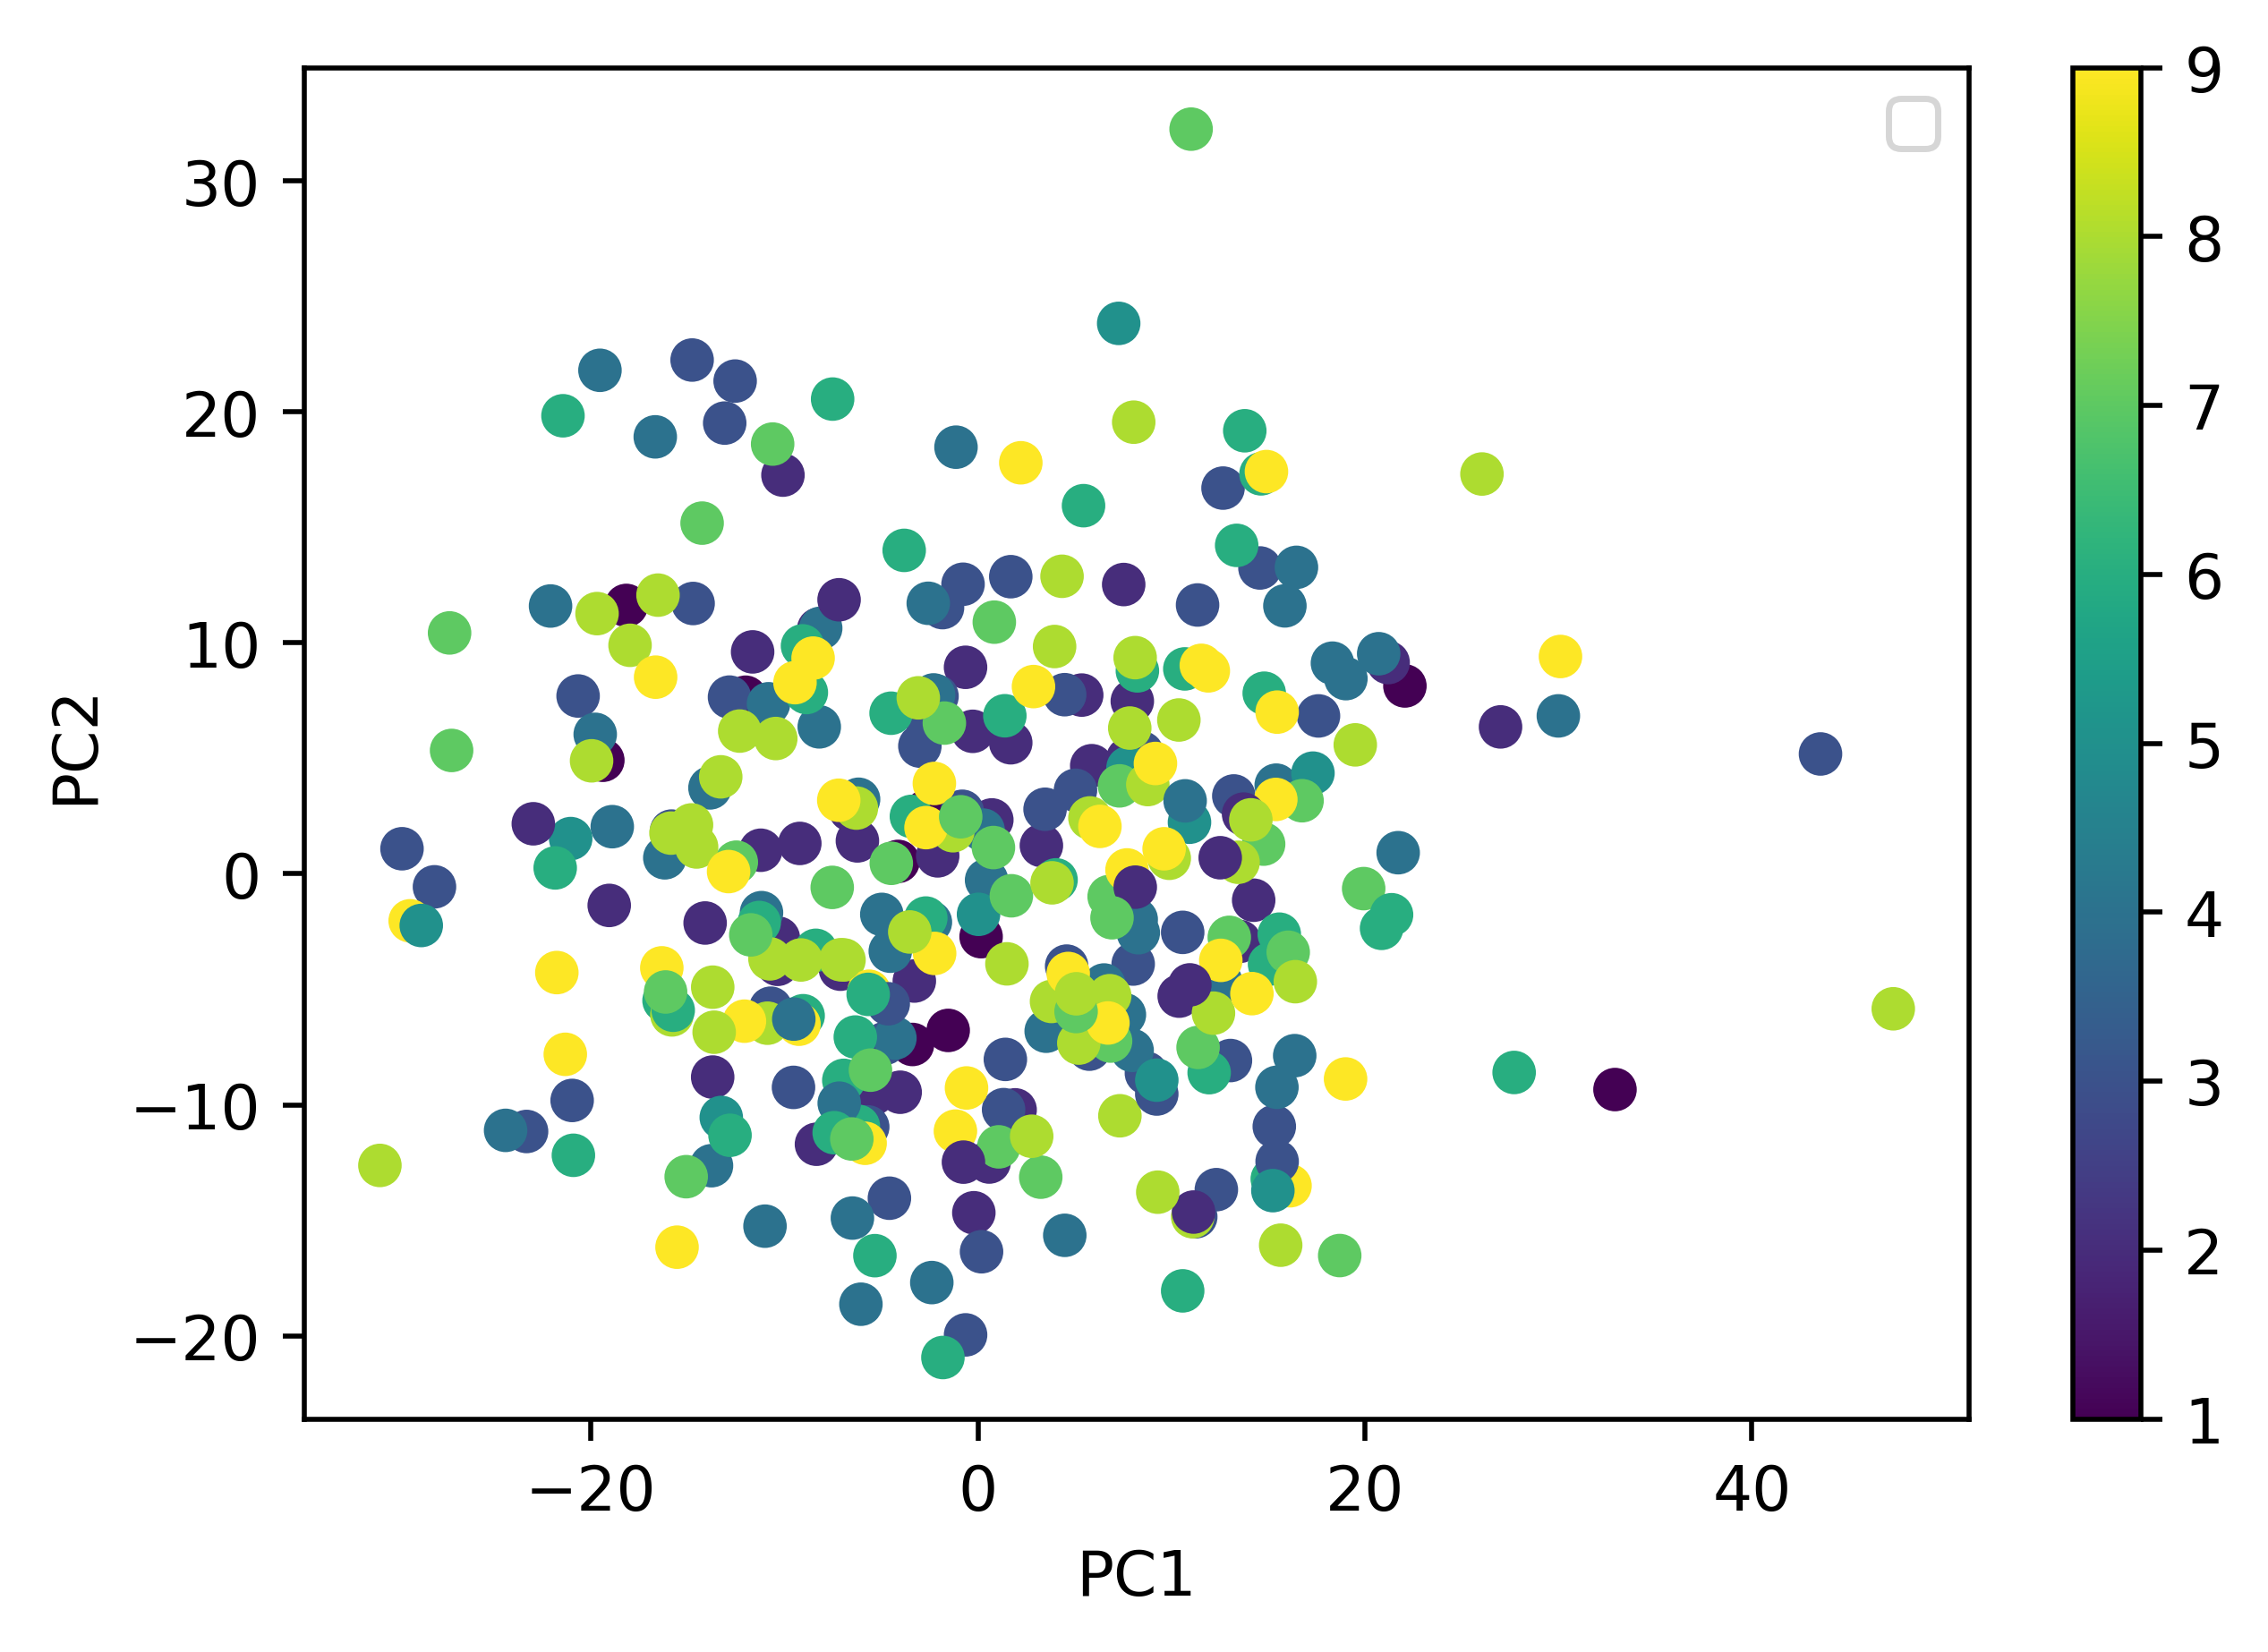

In [5]:
#now quantile normalize

d_whole_norm = combat.combat(pd.DataFrame(d_whole_imput.transpose()),np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))).transpose().to_numpy()


#baseline

if baseline == "qc":
    # #baseline to qcSamps
    baseInt = [np.median(x) for x in d_whole_norm[len(samp_int) + len(blank_int):].transpose()]
    d_whole_norm = np.array([[v - med for v, med in zip(row, baseInt)] for row in d_whole_norm])

if baseline == "all":
    baseInt = [np.median(x) for x in d_whole_norm.transpose()]
    d_whole_norm = np.array([[v - med for v, med in zip(row, baseInt)] for row in d_whole_norm])




#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

samp_load = loads[:len(samp_int)]
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]

#make pca plot divided by sample type
plt.scatter(samp_load[:,0],samp_load[:,1],label="covid+ d0")
plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

#make pca plot by batch
plt.figure()
batch_con = np.concatenate((samp_batch,blank_batch,qc_batch,val_batch))
plt.scatter(loads[:,0],loads[:,1],c=batch_con)
plt.colorbar()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")



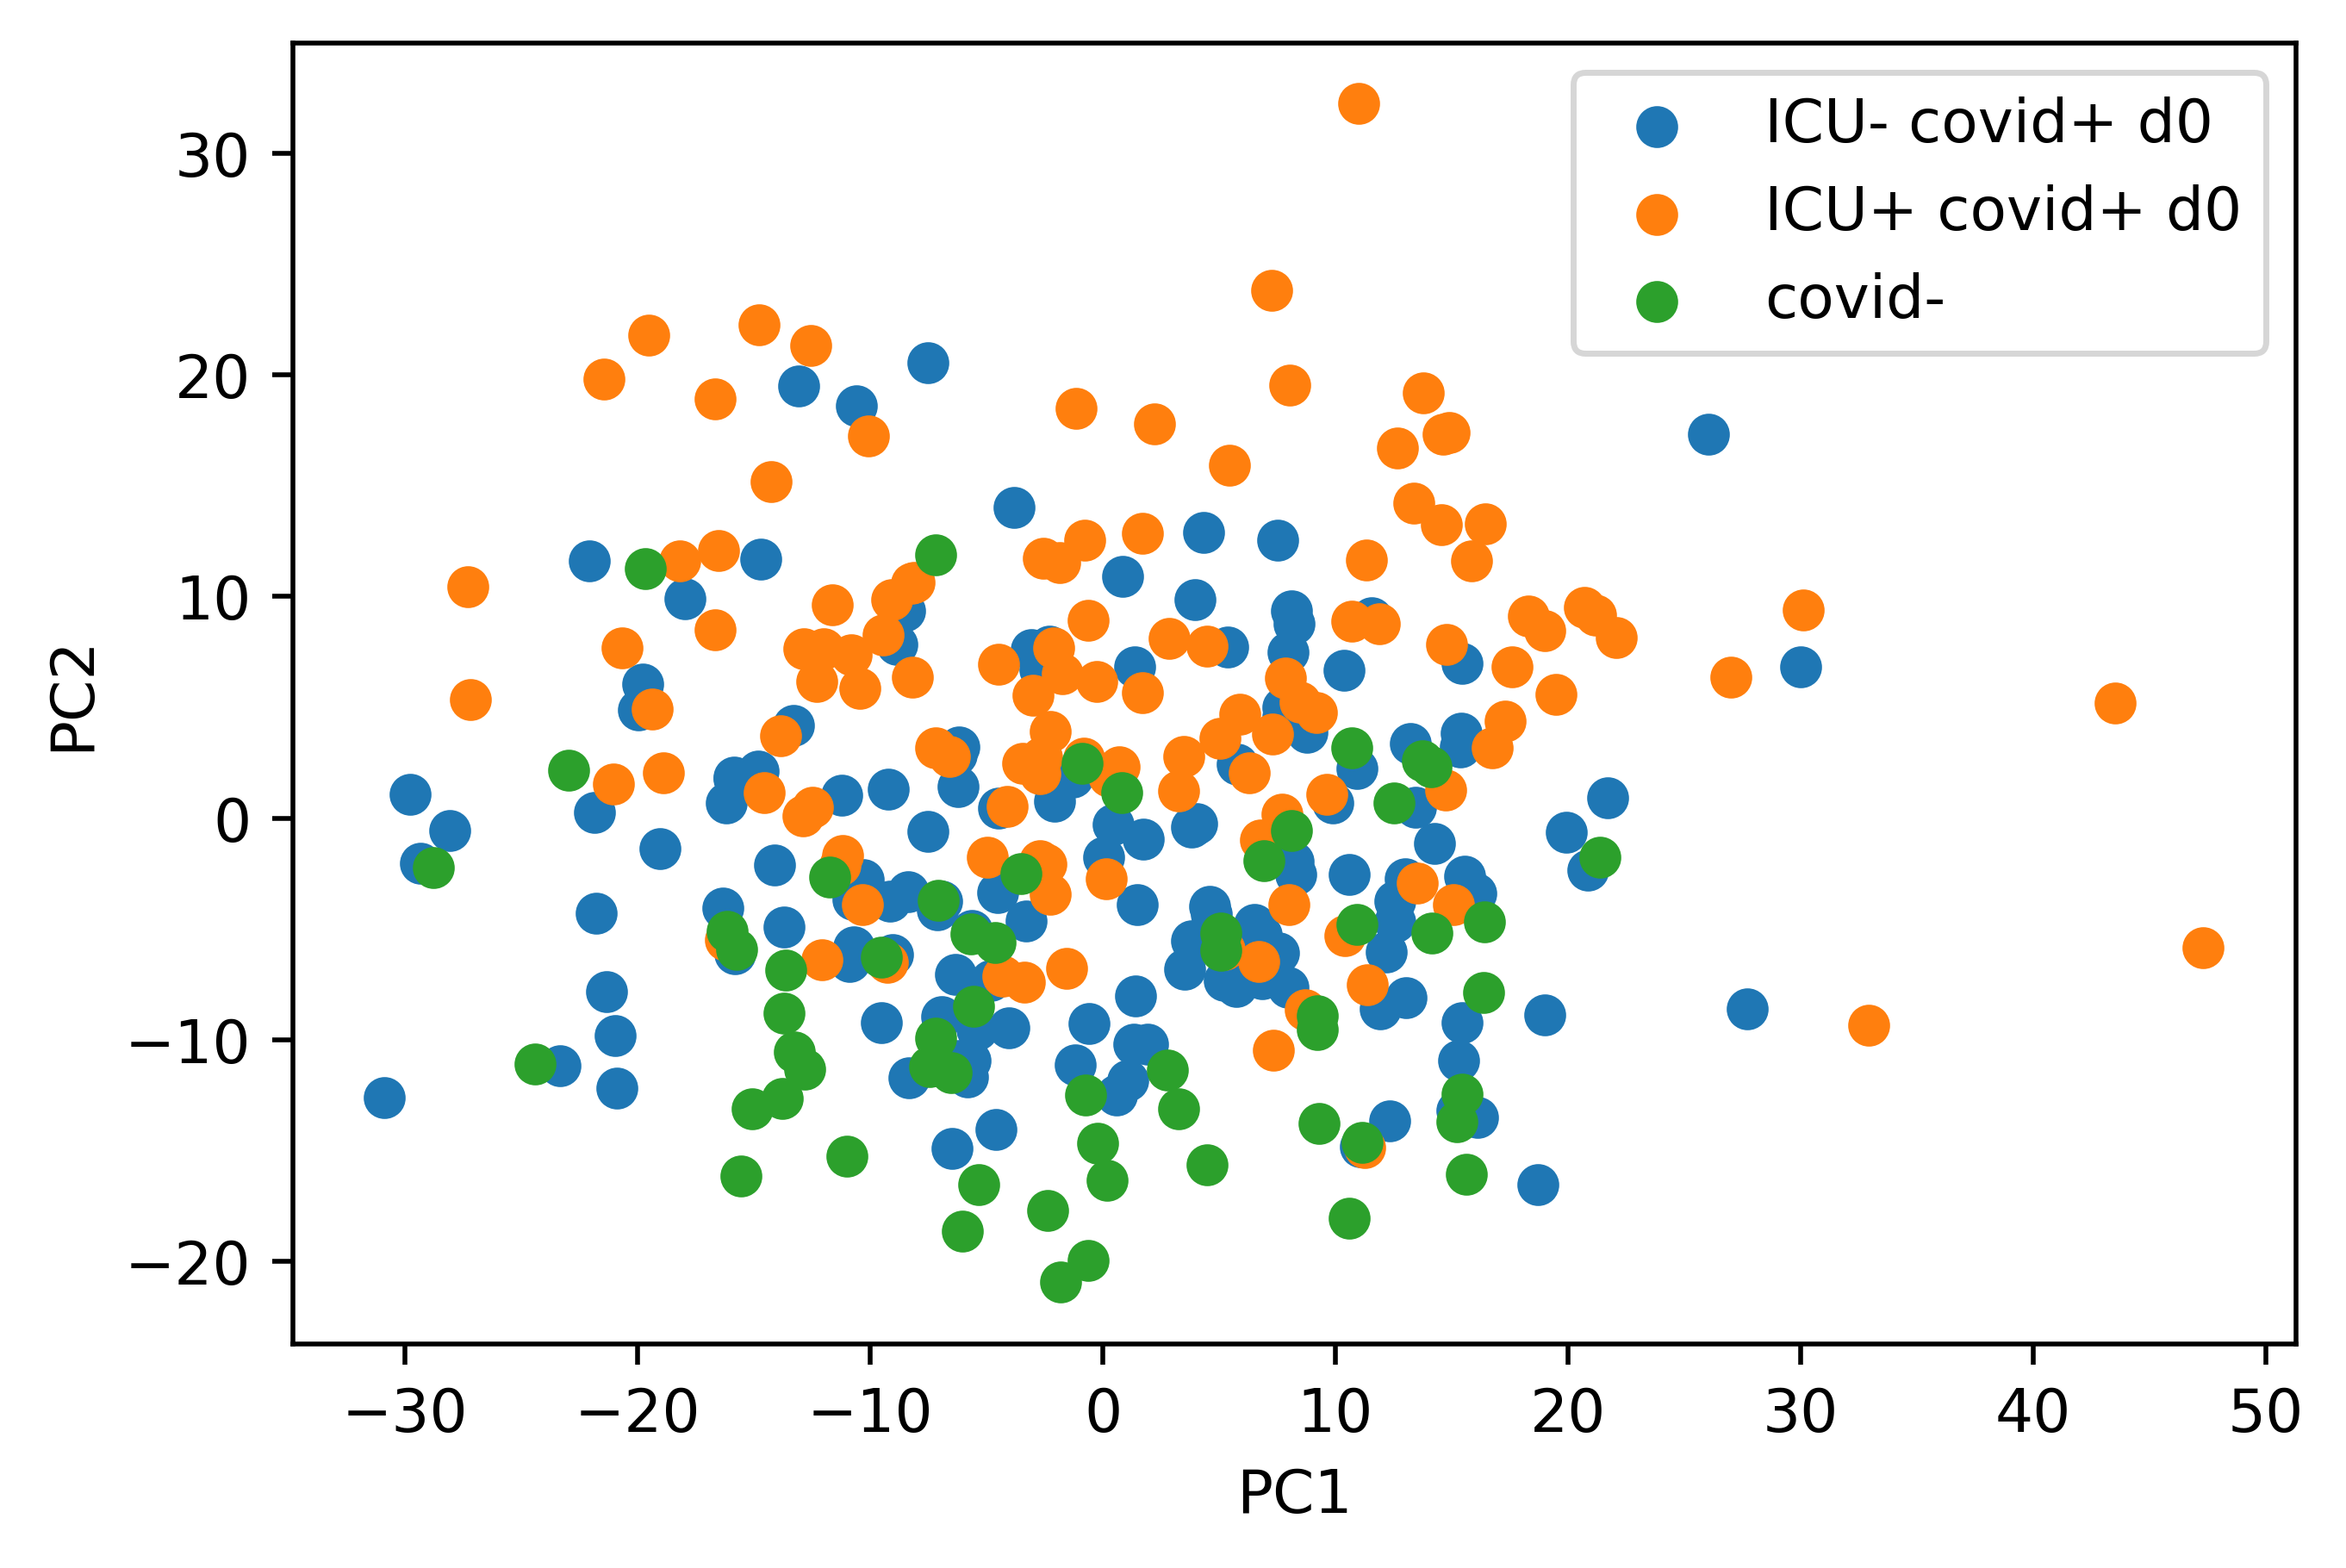

<Figure size 3000x2000 with 0 Axes>

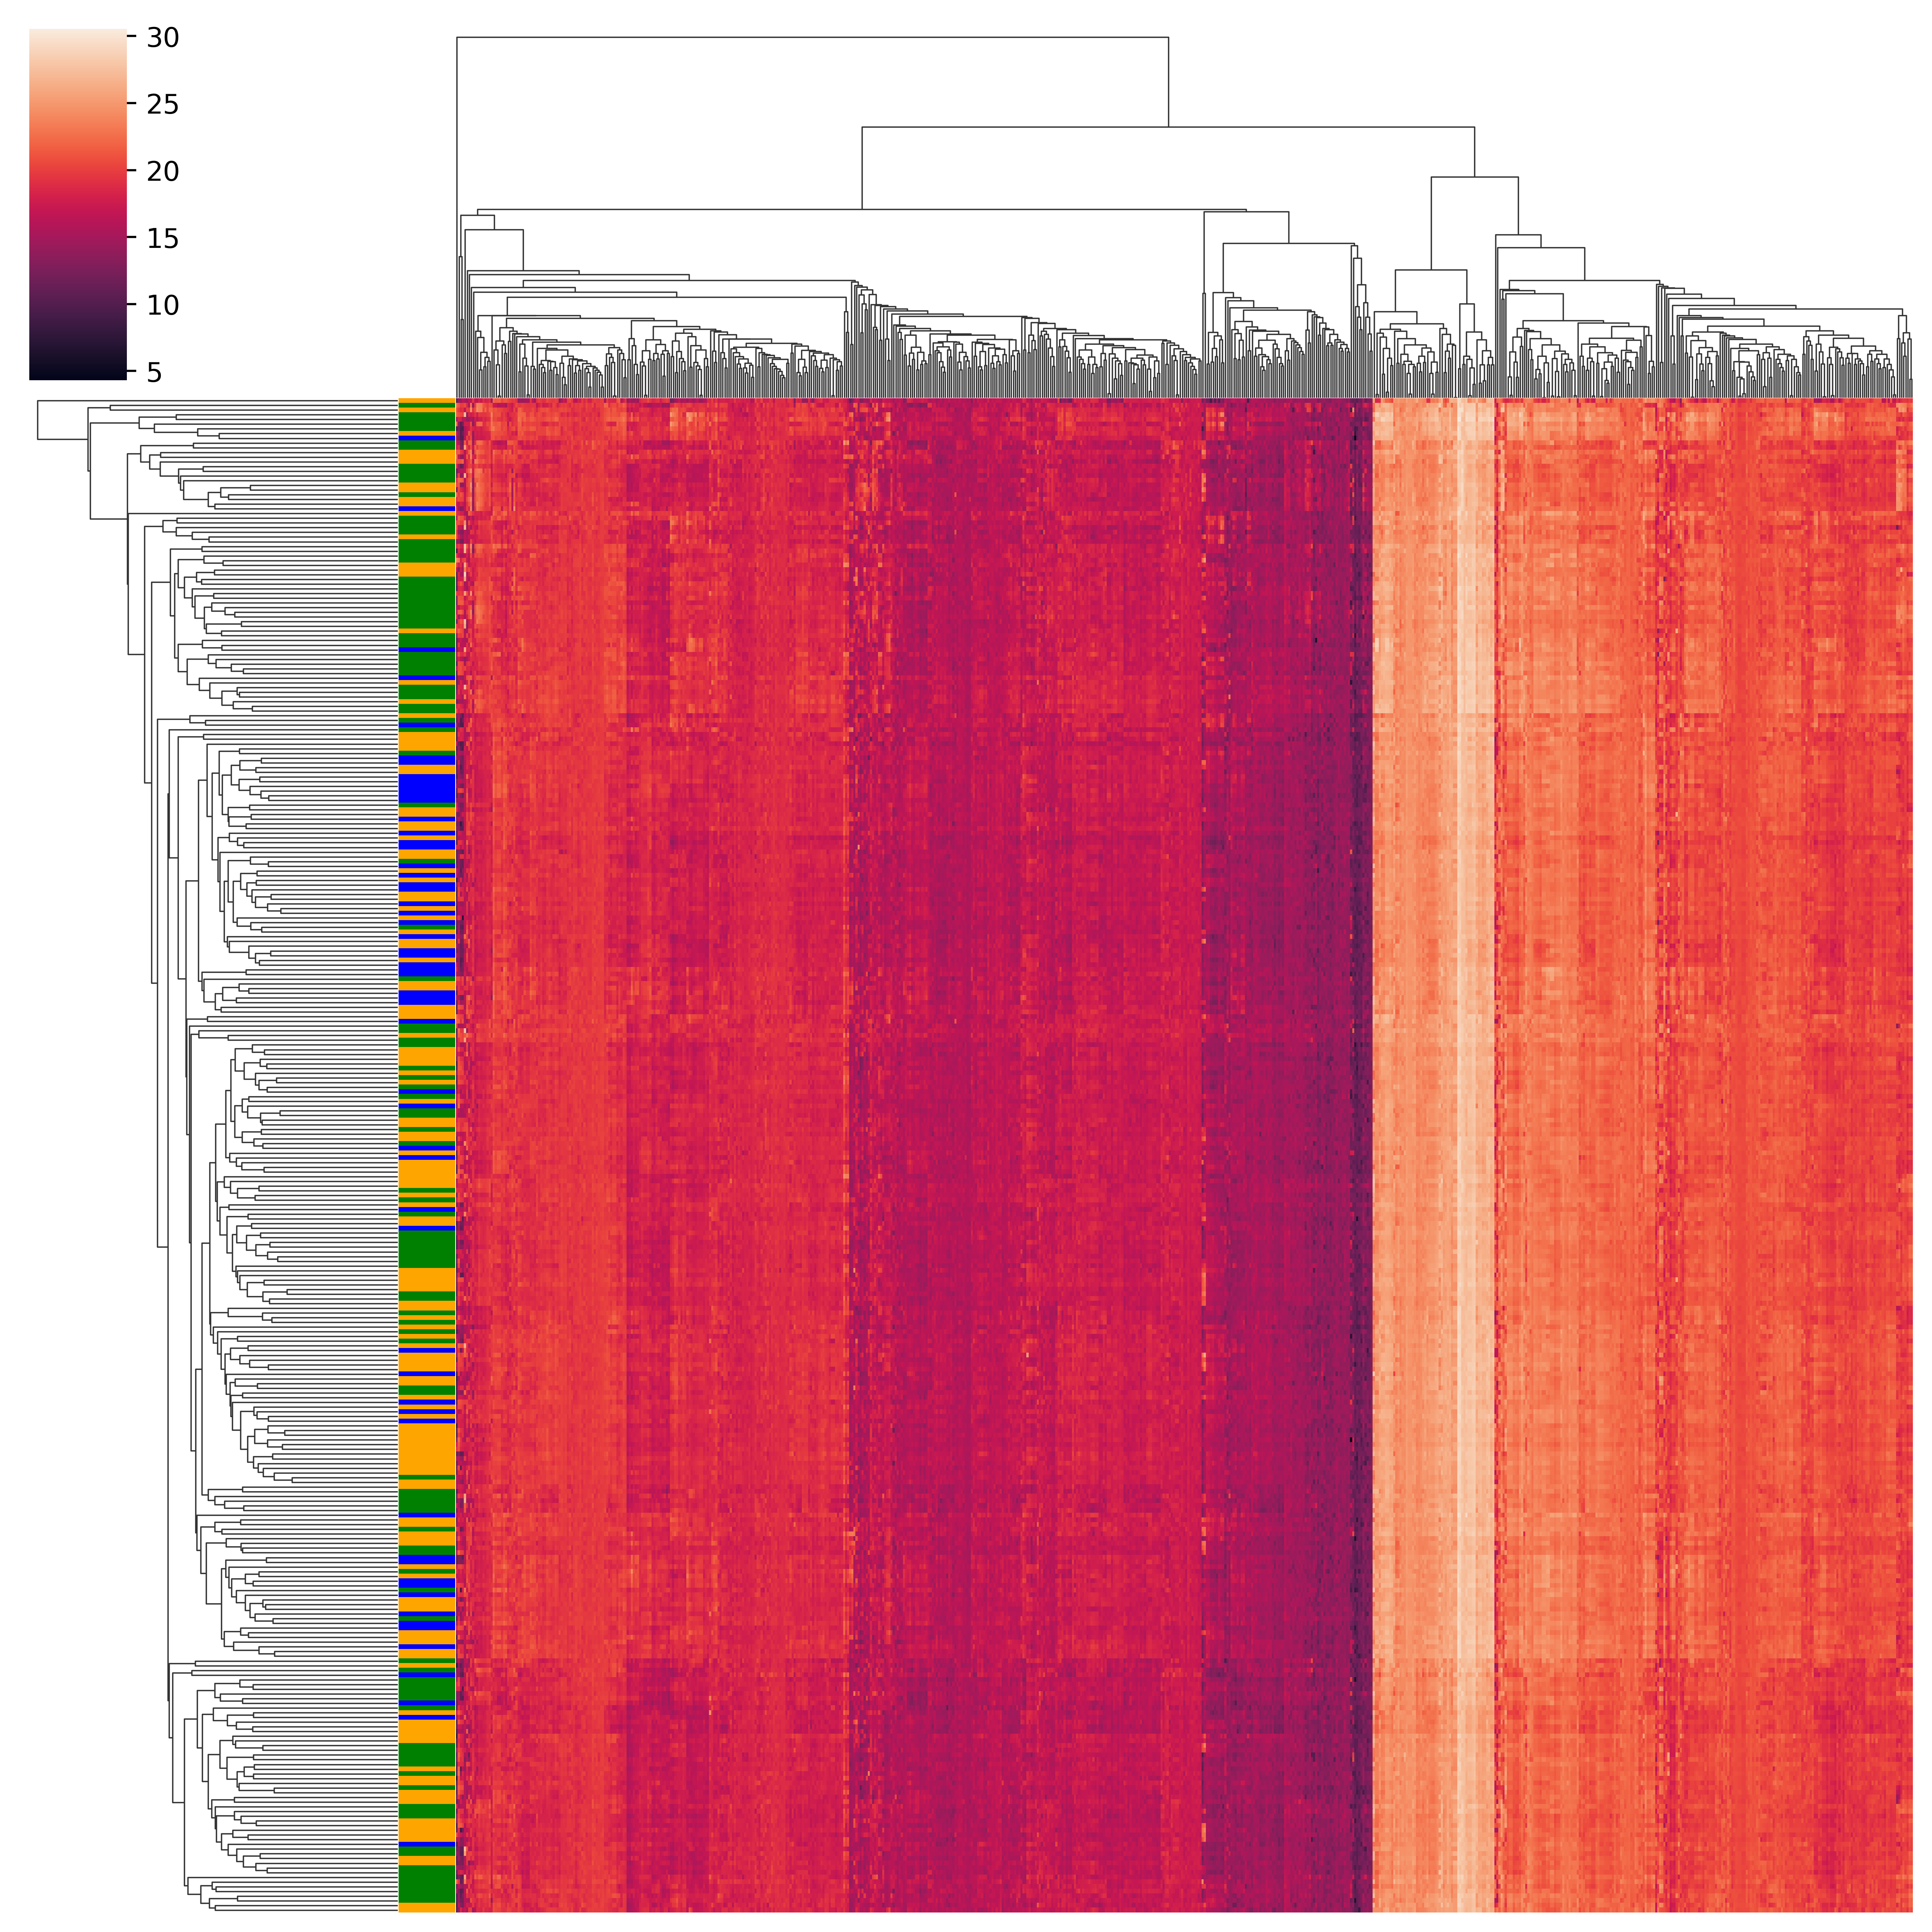

In [6]:
#now plot research samples by vent status
#do pca 
pca = PCA(n_components=2)
pca.fit(d_whole_norm)
loads = pca.transform(d_whole_norm)

#get vent pos/neg loadings
negSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 0]
posSamples = [x for x in range(len(samp_vent)) if samp_vent[x] == 1]
samp_load_vent_neg = loads[:len(samp_int)][negSamples]
samp_load_vent_pos = loads[:len(samp_int)][posSamples]

#get blanks and qc
blank_load = loads[len(samp_int):len(samp_int)+len(blank_int)]
qc_load = loads[len(samp_int)+len(blank_int):len(samp_int)+len(blank_int)+len(qc_int)]
val_load = loads[len(samp_int)+len(blank_int)+len(qc_int):]

#make pca plot divided by sample type
plt.scatter(samp_load_vent_neg[:,0],samp_load_vent_neg[:,1],label="ICU- covid+ d0")
plt.scatter(samp_load_vent_pos[:,0],samp_load_vent_pos[:,1],label="ICU+ covid+ d0")
#plt.scatter(blank_load[:,0],blank_load[:,1],label="blanks")
#plt.scatter(qc_load[:,0],qc_load[:,1],label="qc")
plt.scatter(val_load[:,0],val_load[:,1],label="covid-")
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.figure()

colors = ["blue" for _ in d_whole_norm]
for x in negSamples:
    colors[x] = "orange"
for x in posSamples:
    colors[x] = "green"
sb.clustermap(d_whole_norm,xticklabels=False,yticklabels=False,row_colors=colors)

In [7]:
#create train and test sets for prediction model

#train batches on 1-4
#test on 5-6

trainBatches = [1,2,3,4]
testBatches = [5,6]
confirmBatches = [7,8,9]


#get blanks for train/test
blank_train_index = [x for x in range(len(blank_batch)) if blank_batch[x] in trainBatches]
blank_test_index = [x for x in range(len(blank_batch)) if blank_batch[x] in testBatches]

blank_train_int = blank_int[blank_train_index]
blank_test_int = blank_int[blank_test_index]

blank_train_batch = blank_batch[blank_train_index]
blank_test_batch = blank_batch[blank_test_index]

#get samples for train/test
samp_train_index = [x for x in range(len(samp_batch)) if samp_batch[x] in trainBatches]
samp_test_index = [x for x in range(len(samp_batch)) if samp_batch[x] in testBatches]
samp_confirm_index = [x for x in range(len(samp_batch)) if samp_batch[x] in confirmBatches]

samp_train_int = samp_int[samp_train_index]
samp_test_int = samp_int[samp_test_index]
samp_confirm_int = samp_int[samp_confirm_index]

samp_train_vent = samp_vent[samp_train_index]
samp_test_vent = samp_vent[samp_test_index]
samp_confirm_vent = samp_vent[samp_confirm_index]

samp_train_batch = samp_batch[samp_train_index]
samp_test_batch = samp_batch[samp_test_index]
samp_confirm_batch = samp_batch[samp_confirm_index]

samp_train_metadata = [samp_metadata[x] for x in samp_train_index]
samp_test_metadata = [samp_metadata[x] for x in samp_test_index]
samp_confirm_metadata = [samp_metadata[x] for x in samp_confirm_index]

#get qc for train/test

qc_train_index = [x for x in range(len(qc_batch)) if qc_batch[x] in trainBatches]
qc_test_index = [x for x in range(len(qc_batch)) if qc_batch[x] in testBatches]

qc_train_int = qc_int[qc_train_index]
qc_test_int = qc_int[qc_test_index] 

qc_train_batch = qc_batch[qc_train_index]
qc_test_batch = qc_batch[qc_test_index] 

#need to add vent and qcs

print("training examples: ",len(samp_train_int),"testing examples: ",len(samp_test_int))
print("training ICU+ examples:, ",len([x for x in samp_train_vent if x == 1]),
      "training ICU- examples:, ",len([x for x in samp_train_vent if x == 0]))
print("testing ICU+ examples:, ",len([x for x in samp_test_vent if x == 1]),
      "testing ICU- examples:, ",len([x for x in samp_test_vent if x == 0]))
print("confirm ICU+ examples:, ",len([x for x in samp_confirm_vent if x == 1]),
      "confirm ICU- examples:, ",len([x for x in samp_confirm_vent if x == 0]))

training examples:  127 testing examples:  38
training ICU+ examples:,  66 training ICU- examples:,  61
testing ICU+ examples:,  17 testing ICU- examples:,  21
confirm ICU+ examples:,  40 confirm ICU- examples:,  58


In [8]:
X_train,y_train,X_test,y_test,X_train_blank = helper.normalize_data(samp_train_int,blank_train_int,qc_train_int,np.concatenate((samp_test_int,val_int,samp_confirm_int)), blank_test_int, qc_test_int,samp_train_batch,
                           blank_train_batch, qc_train_batch, np.concatenate((samp_test_batch,val_batch,samp_confirm_batch)), blank_test_batch, qc_test_batch,samp_train_vent,np.concatenate((samp_test_vent,val_vent,samp_confirm_vent)),baseline)
X_test,X_val,X_confirm = X_test[:len(samp_test_batch)],X_test[len(samp_test_batch):len(samp_test_batch)+len(val_batch)],X_test[len(samp_test_batch)+len(val_batch):]
y_test,y_val,y_confirm = y_test[:len(samp_test_batch)],y_test[len(samp_test_batch):len(samp_test_batch)+len(val_batch)],y_test[len(samp_test_batch)+len(val_batch):]
X_train_metadata = samp_train_metadata
X_test_metadata = samp_test_metadata
X_confirm_metadata = samp_confirm_metadata



89789
0
137865
0


found 9 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


training score:  0.903129657228018
testing score:  0.8151260504201681


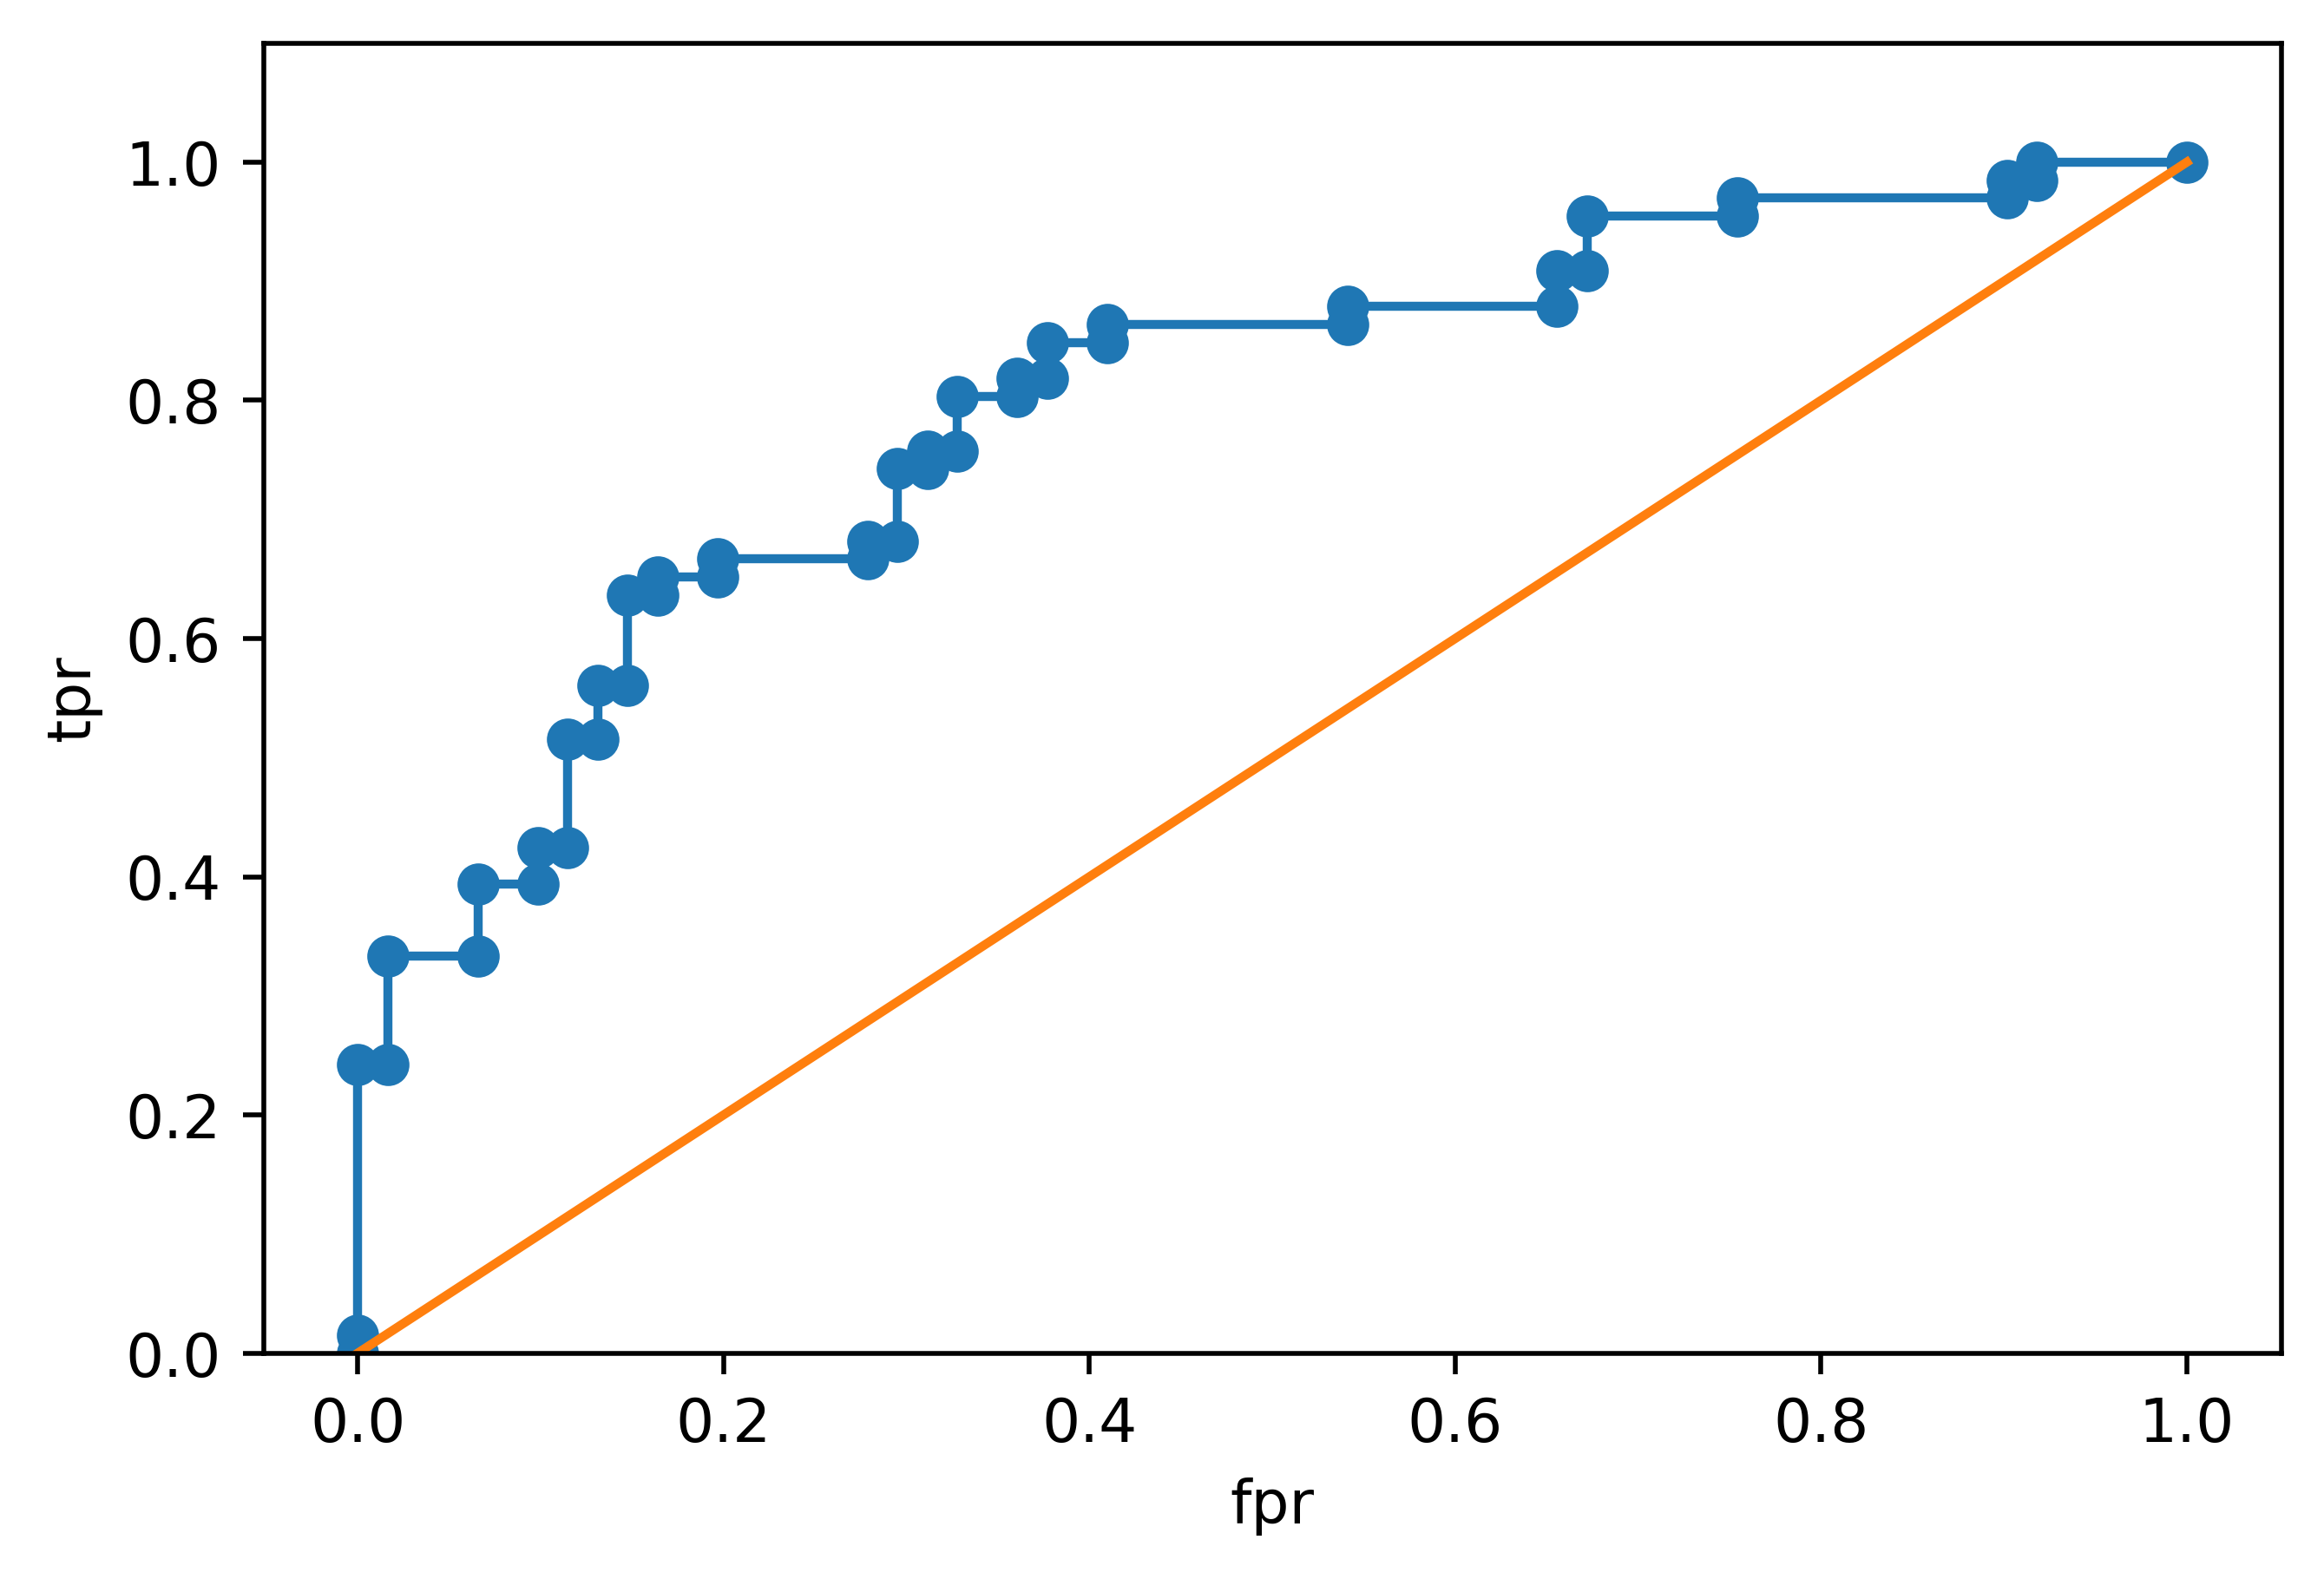

In [9]:
#fit model
feat_params = params["feat_selection"]

y_pred_cv,y_cv = helper.crossVal(X_train,y_train,X_train_blank,mol_names,trainFunc,predictFunc,params,k=20,numCores=20)

selected_feats = helper.featureSelection(X_train,y_train,X_train_blank,mol_names,feat_params,True,True)
X_train_sig = X_train[:,selected_feats]
obj = trainFunc(X_train, y_train, X_train_blank, mol_names, params)

#predict
y_pred_train = predictFunc(obj,X_train)

#assess training error
err_train = helper.score(y_pred_train,y_train)
print("training score: ",err_train)
#print(sklearn.metrics.confusion_matrix(y_train,y_pred))

plt.figure()

fpr,tpr,thresolds = sklearn.metrics.roc_curve(y_cv,y_pred_cv)
plt.plot(fpr,tpr)
plt.scatter(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.ylim((0,1.1))
plt.plot([0,1],[0,1])
# for p,r,t in zip(precision,recall,thresolds):
#     print(p,r,t)

#assess testing error
y_test_pred = predictFunc(obj,X_test)

err_test = helper.score(y_test_pred,y_test)
print("testing score: ",err_test)
#print(sklearn.metrics.confusion_matrix(y_test,y_test_pred))

y_neg_pred = [y_test_pred[i] for i in range(len(y_test_pred)) if y_test[i] < .5]
y_pos_pred = [y_test_pred[i] for i in range(len(y_test_pred)) if y_test[i] > .5]

y_val_pred = predictFunc(obj,X_val)

    





3


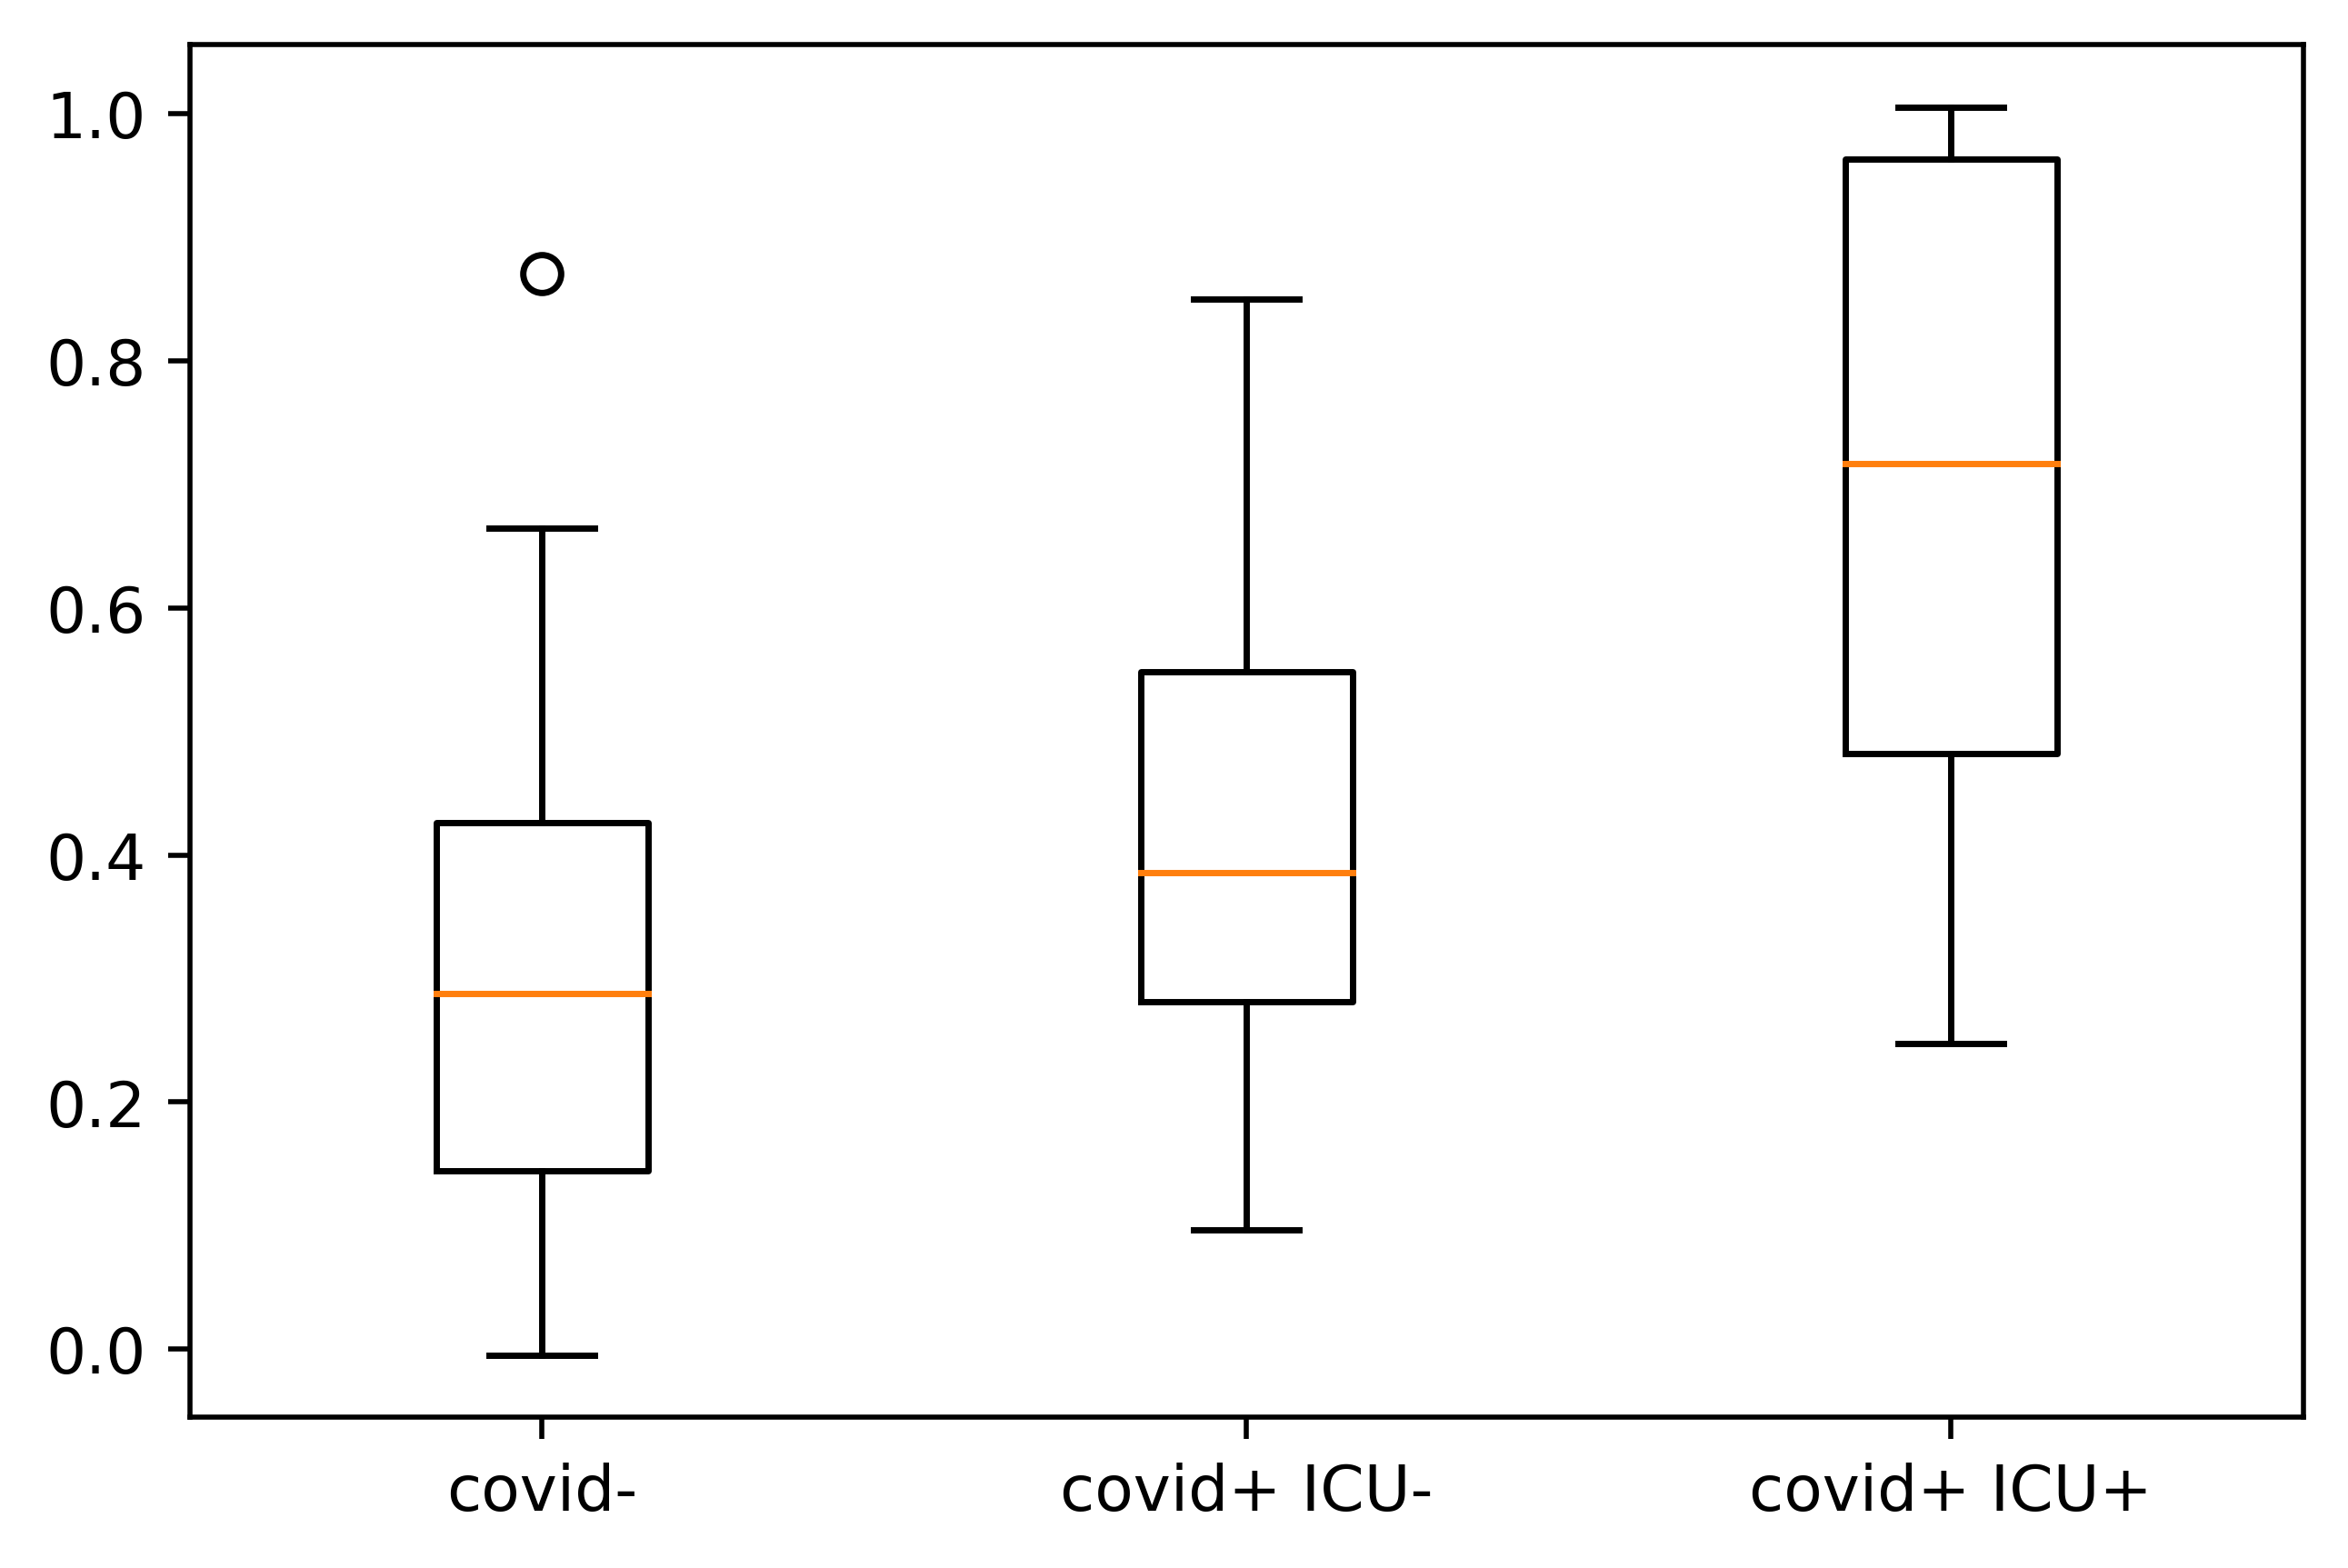

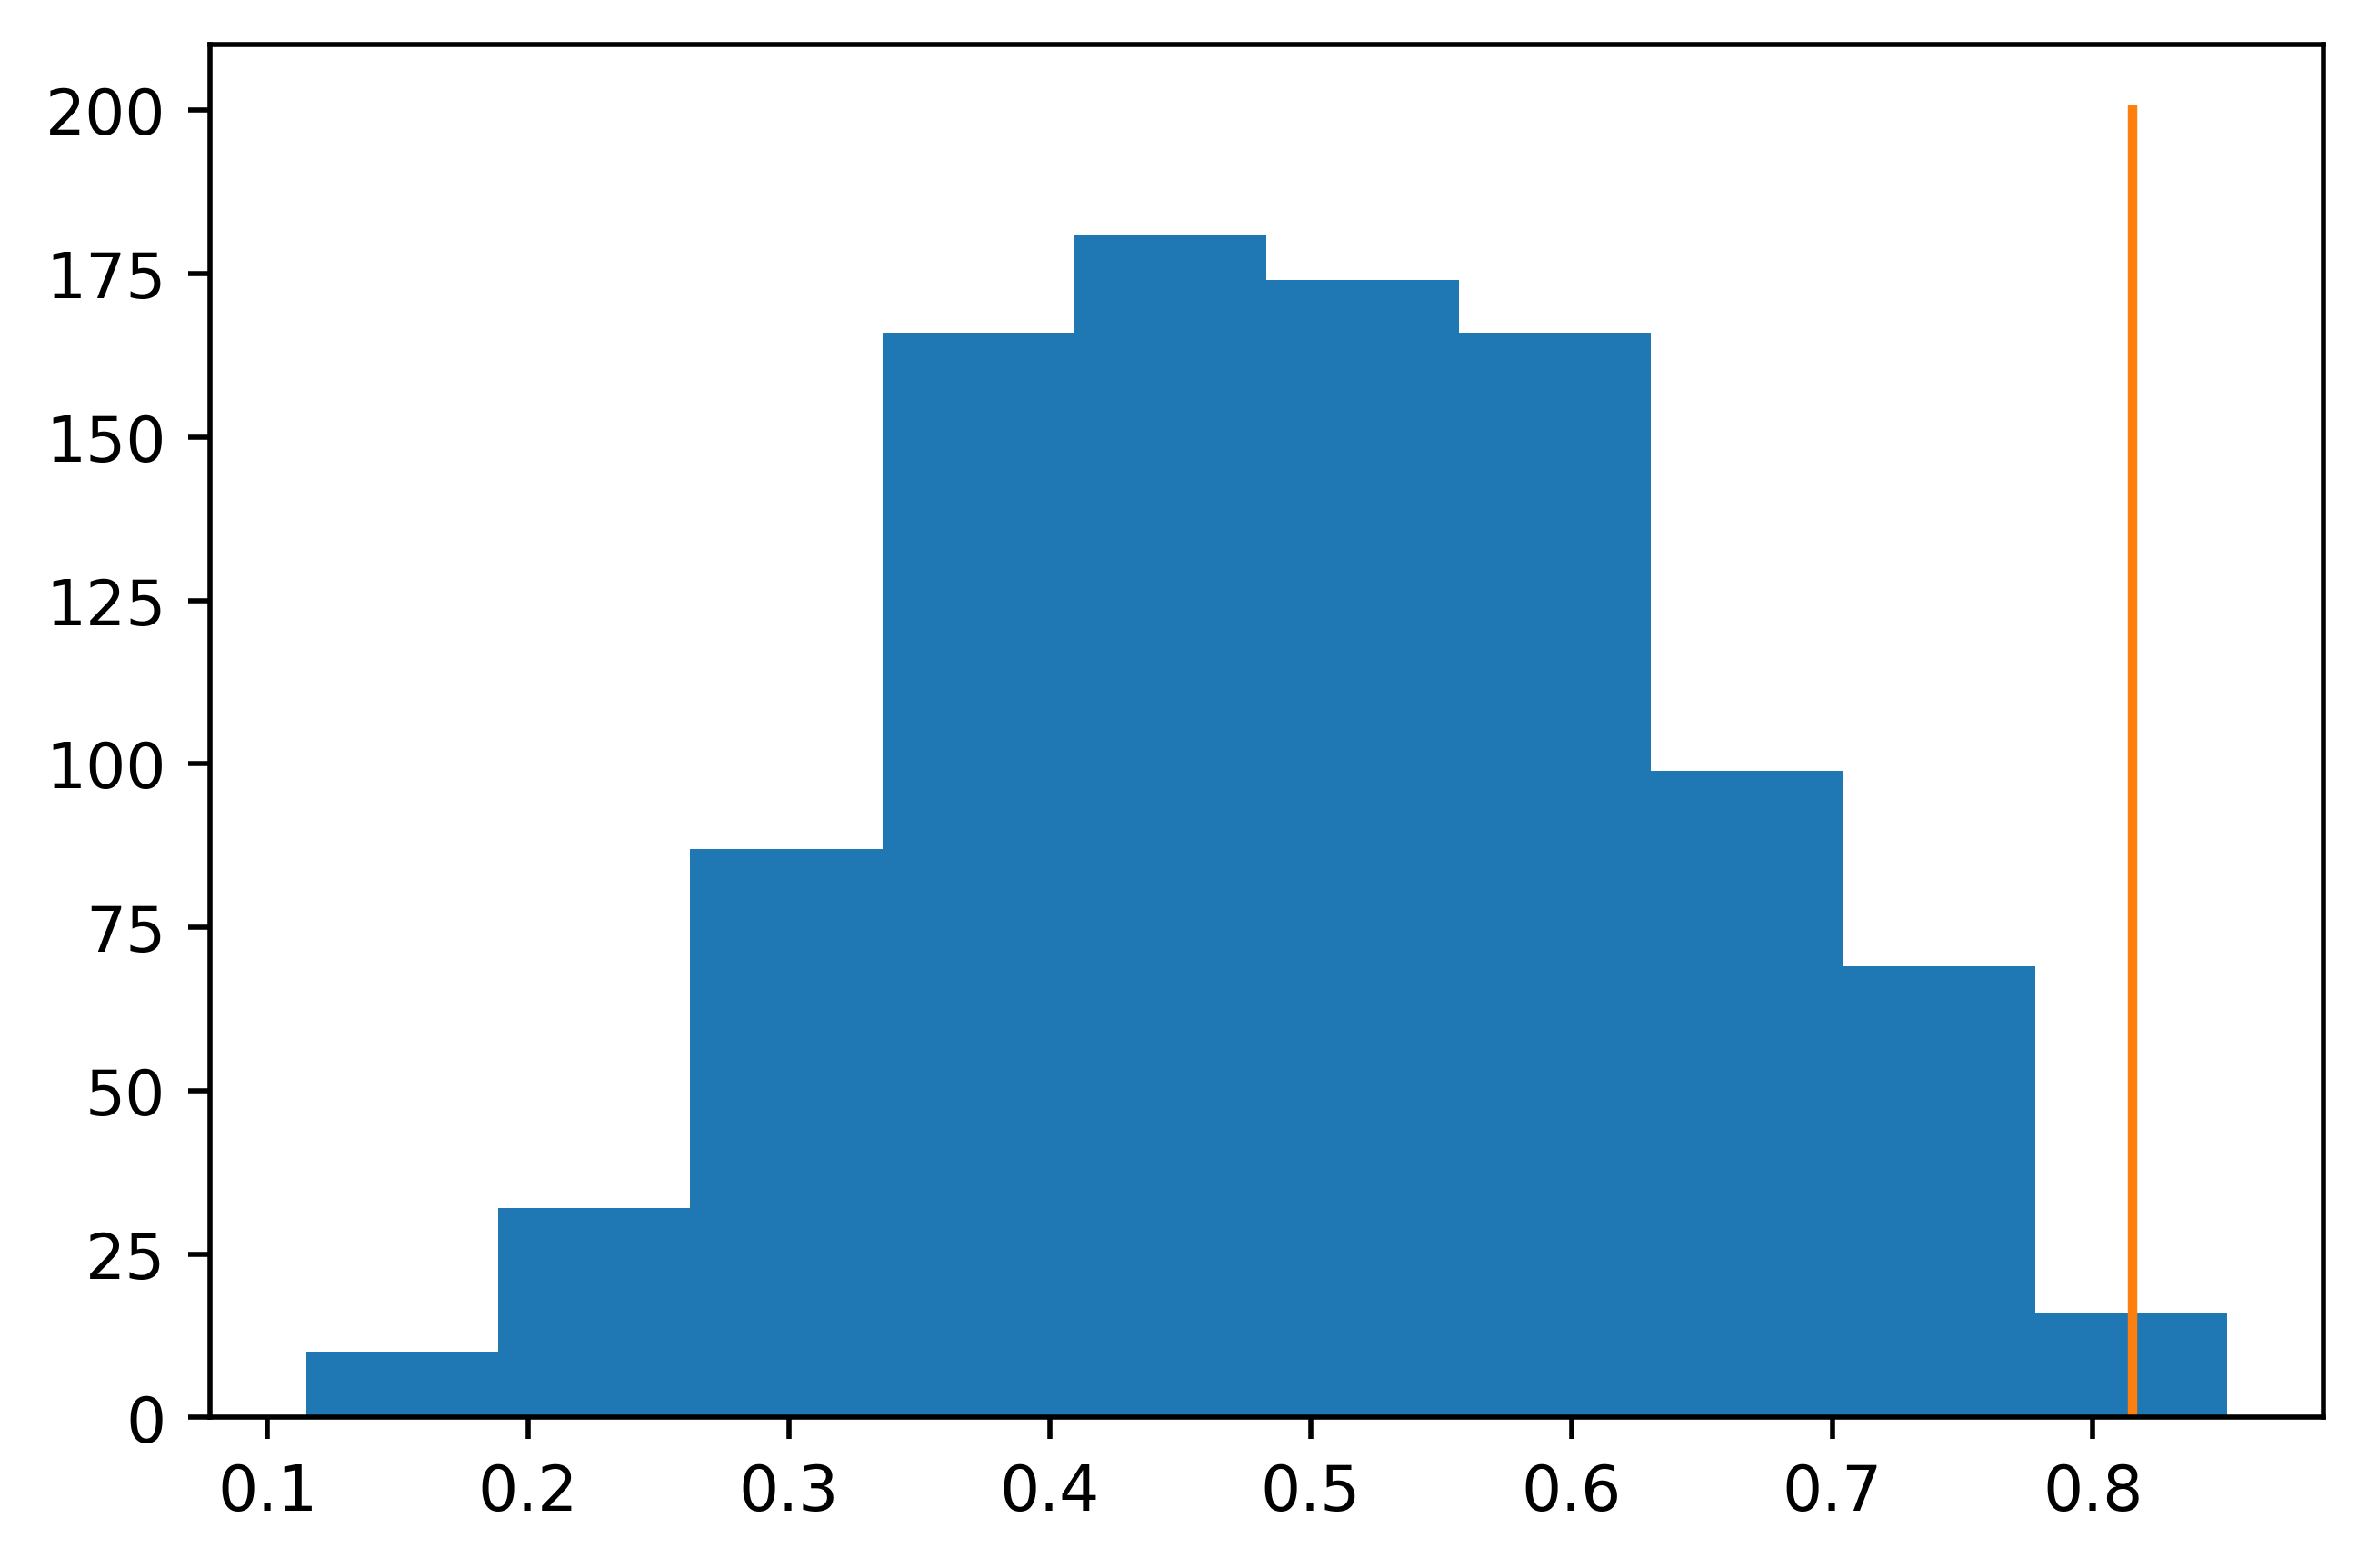

In [10]:
thresh = 0.56
plt.figure()
plt.boxplot([y_val_pred,y_neg_pred,y_pos_pred],labels=["covid-","covid+ ICU-","covid+ ICU+"])
#plt.plot(range(1,4),[thresh for _ in range(1,4)])

#y_val_pred_bin = binarize(y_val_pred,thresh)
#y_test_pred_bin = binarize(y_test_pred,thresh)

# print(sklearn.metrics.confusion_matrix(y_val,y_val_pred_bin))
# print(sklearn.metrics.confusion_matrix(y_test,y_test_pred_bin))



#permutation test
numPerm = 1000
res = []
fprs_tprs = []
for _ in range(numPerm):
    order = list(range(len(y_train)))
    rd.shuffle(order)
    y_shuff = np.array([y_train[x] for x in order])
    obj = trainFunc(X_train, y_shuff, X_train_blank, mol_names, params)
    y_pred = predictFunc(obj,X_test)
    err_shuff = helper.score(y_pred,y_test)
    res.append(err_shuff)
    fpr,tpr,_ = sklearn.metrics.roc_curve(y_test,y_pred)
    fprs_tprs.append([fpr,tpr])
    
print(len([x for x in res if x > err_test]))
    
#plot histogram
plt.figure()
plt.hist(res)
plt.plot([err_test,err_test],[0,.2*numPerm])

Ttest_indResult(statistic=-5.838057878275378, pvalue=3.106375098505367e-08)
Ttest_indResult(statistic=2.4578652569319113, pvalue=0.015066822351587503)
0.596638655462185


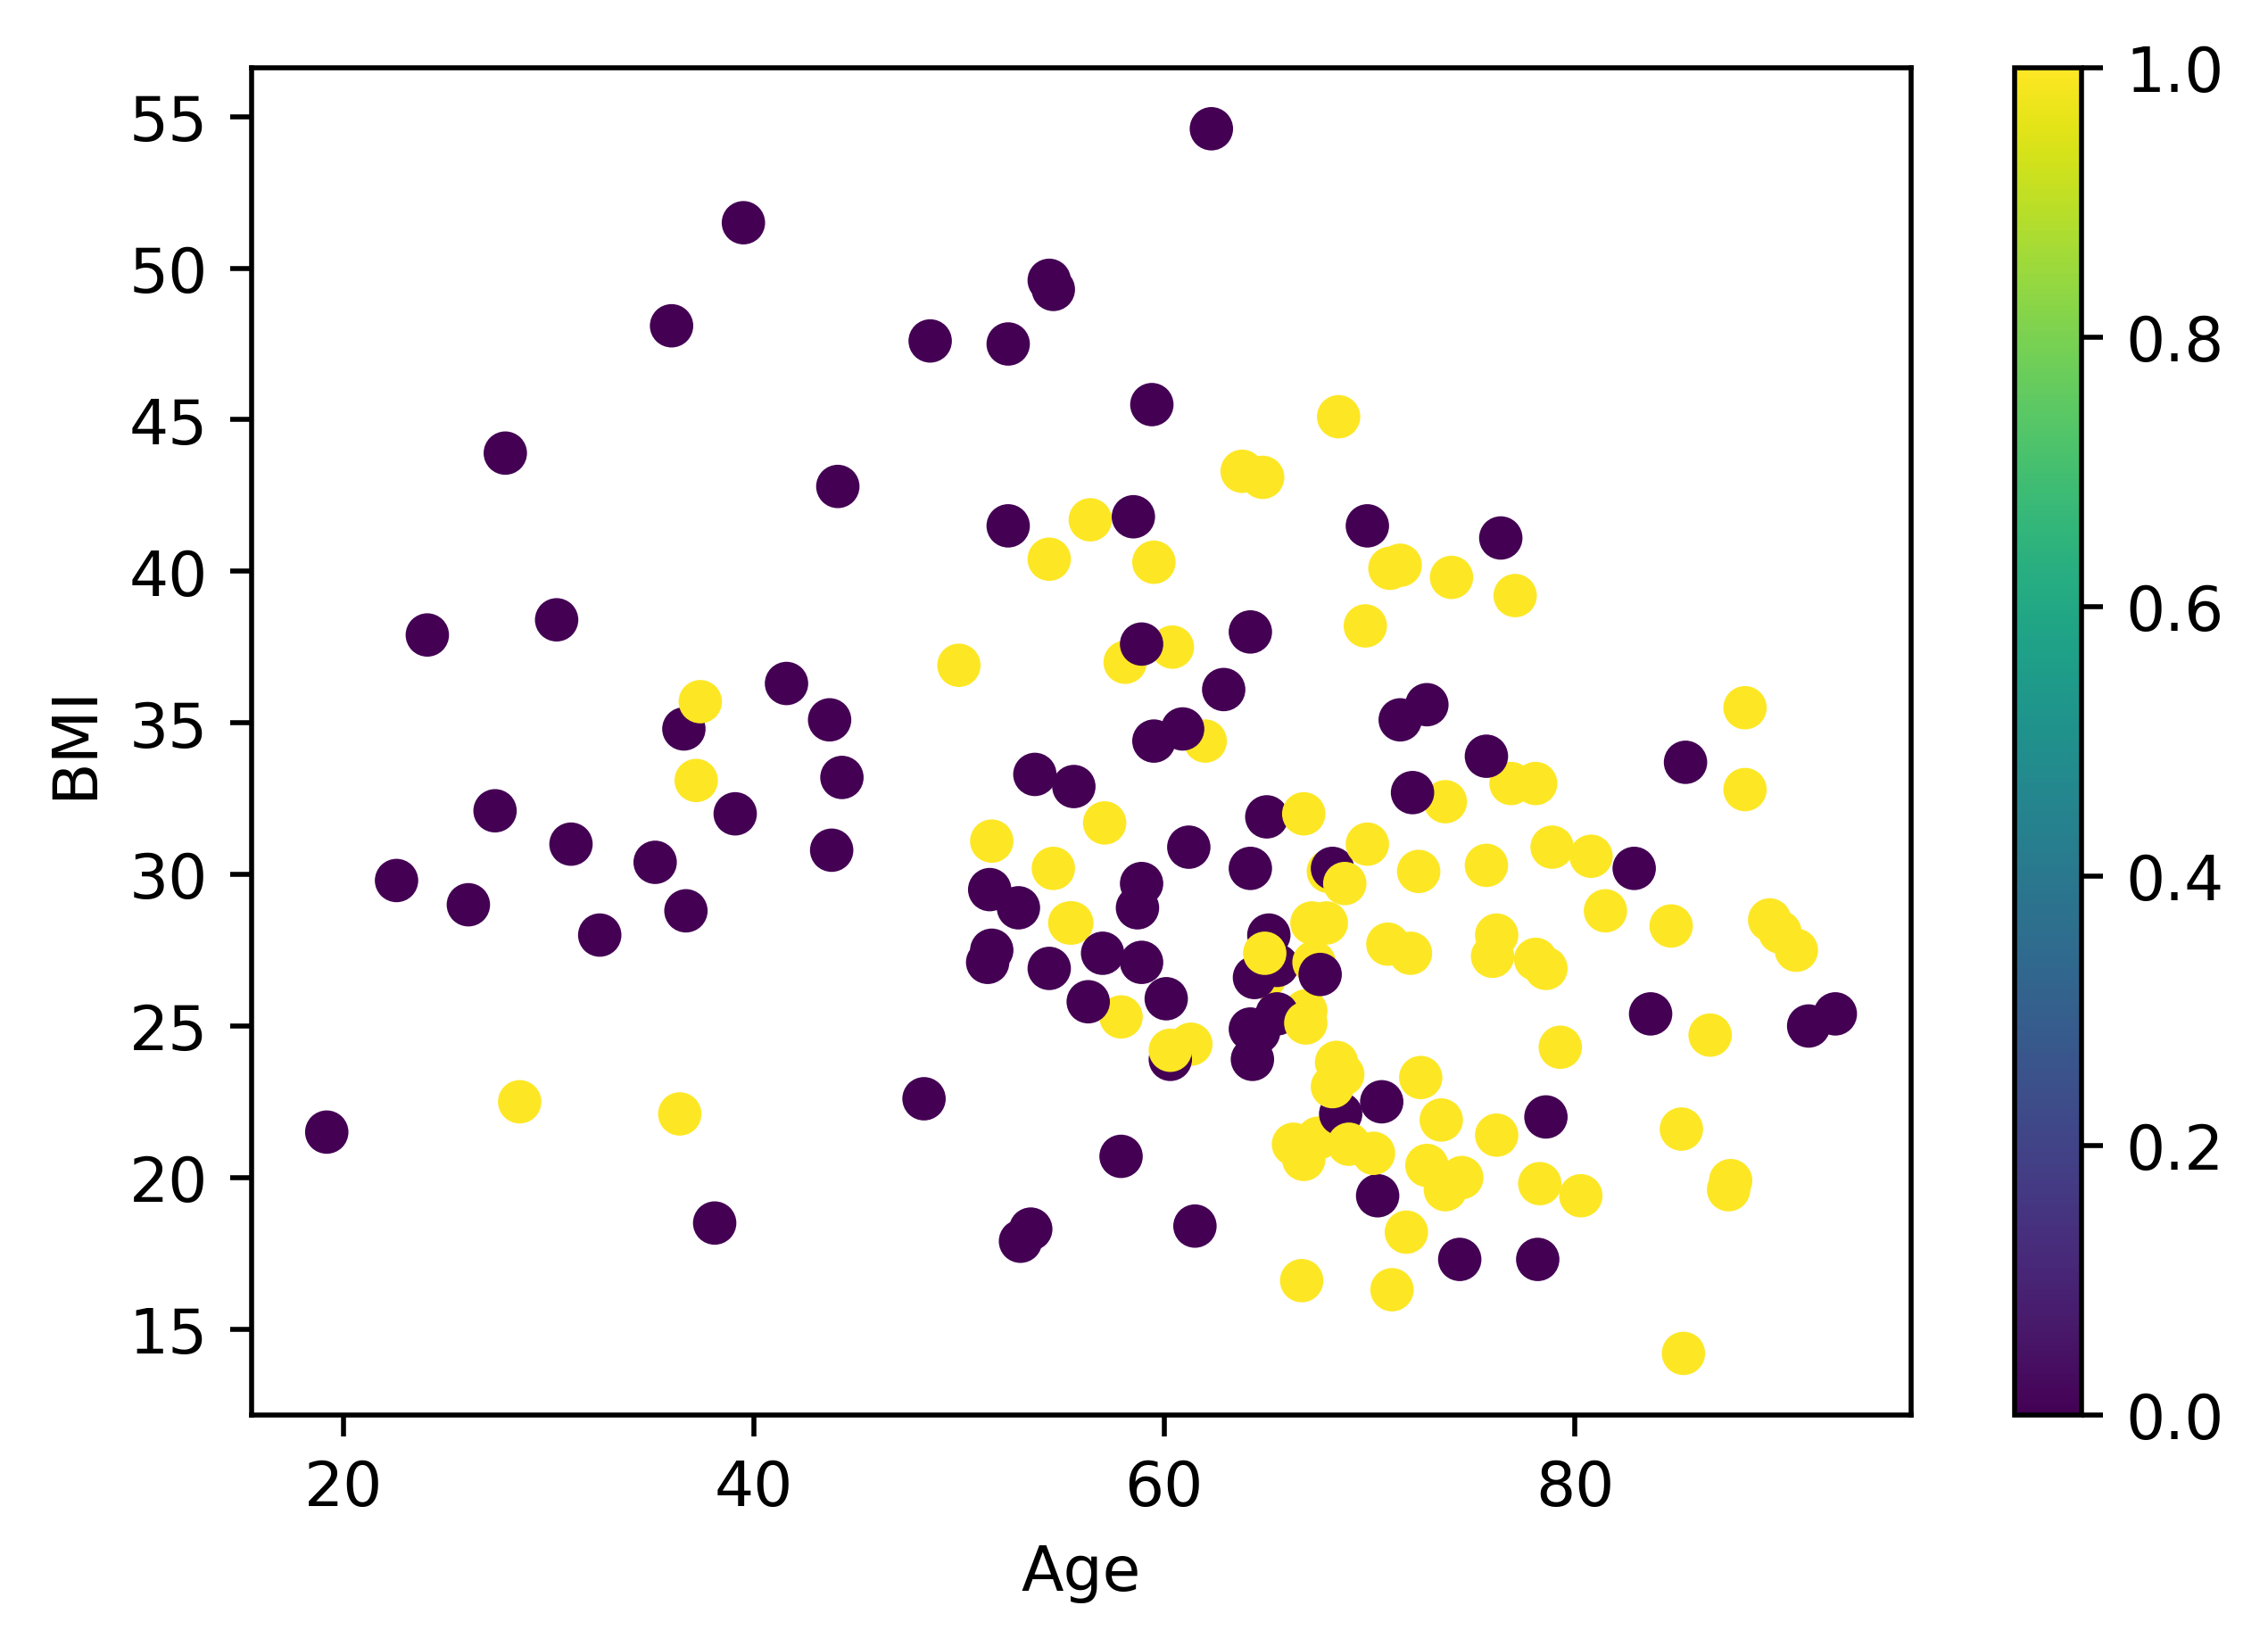

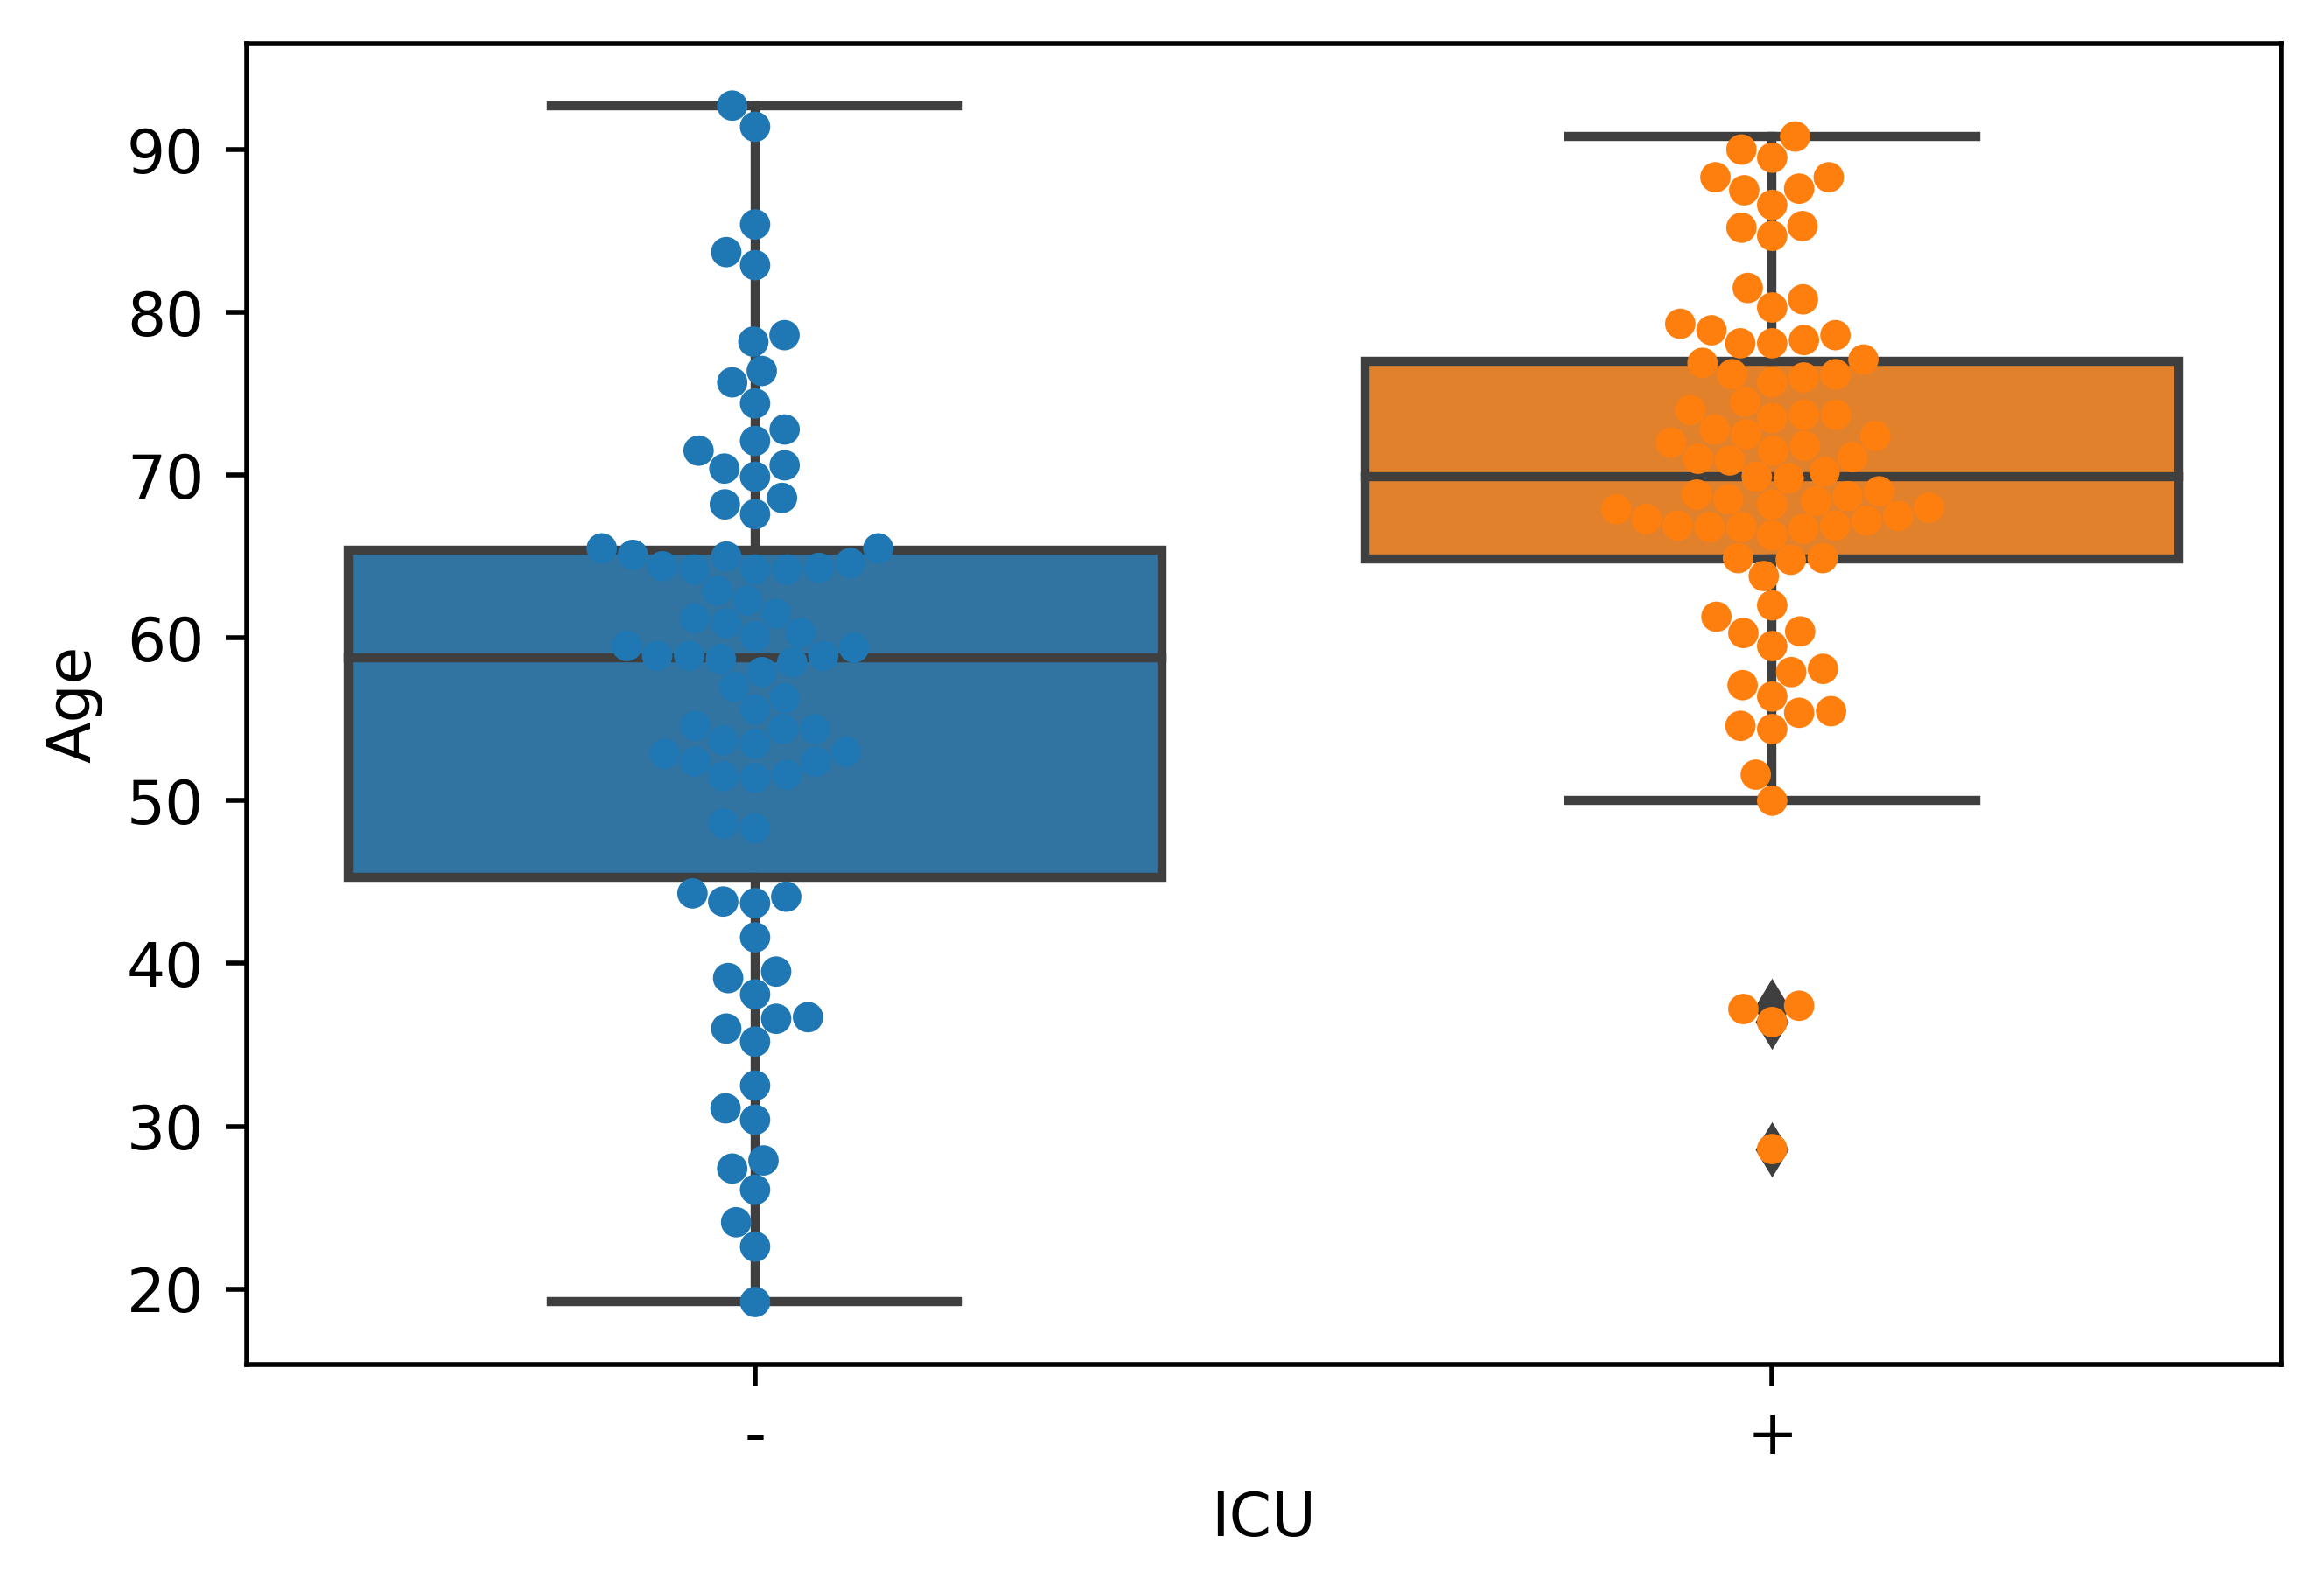

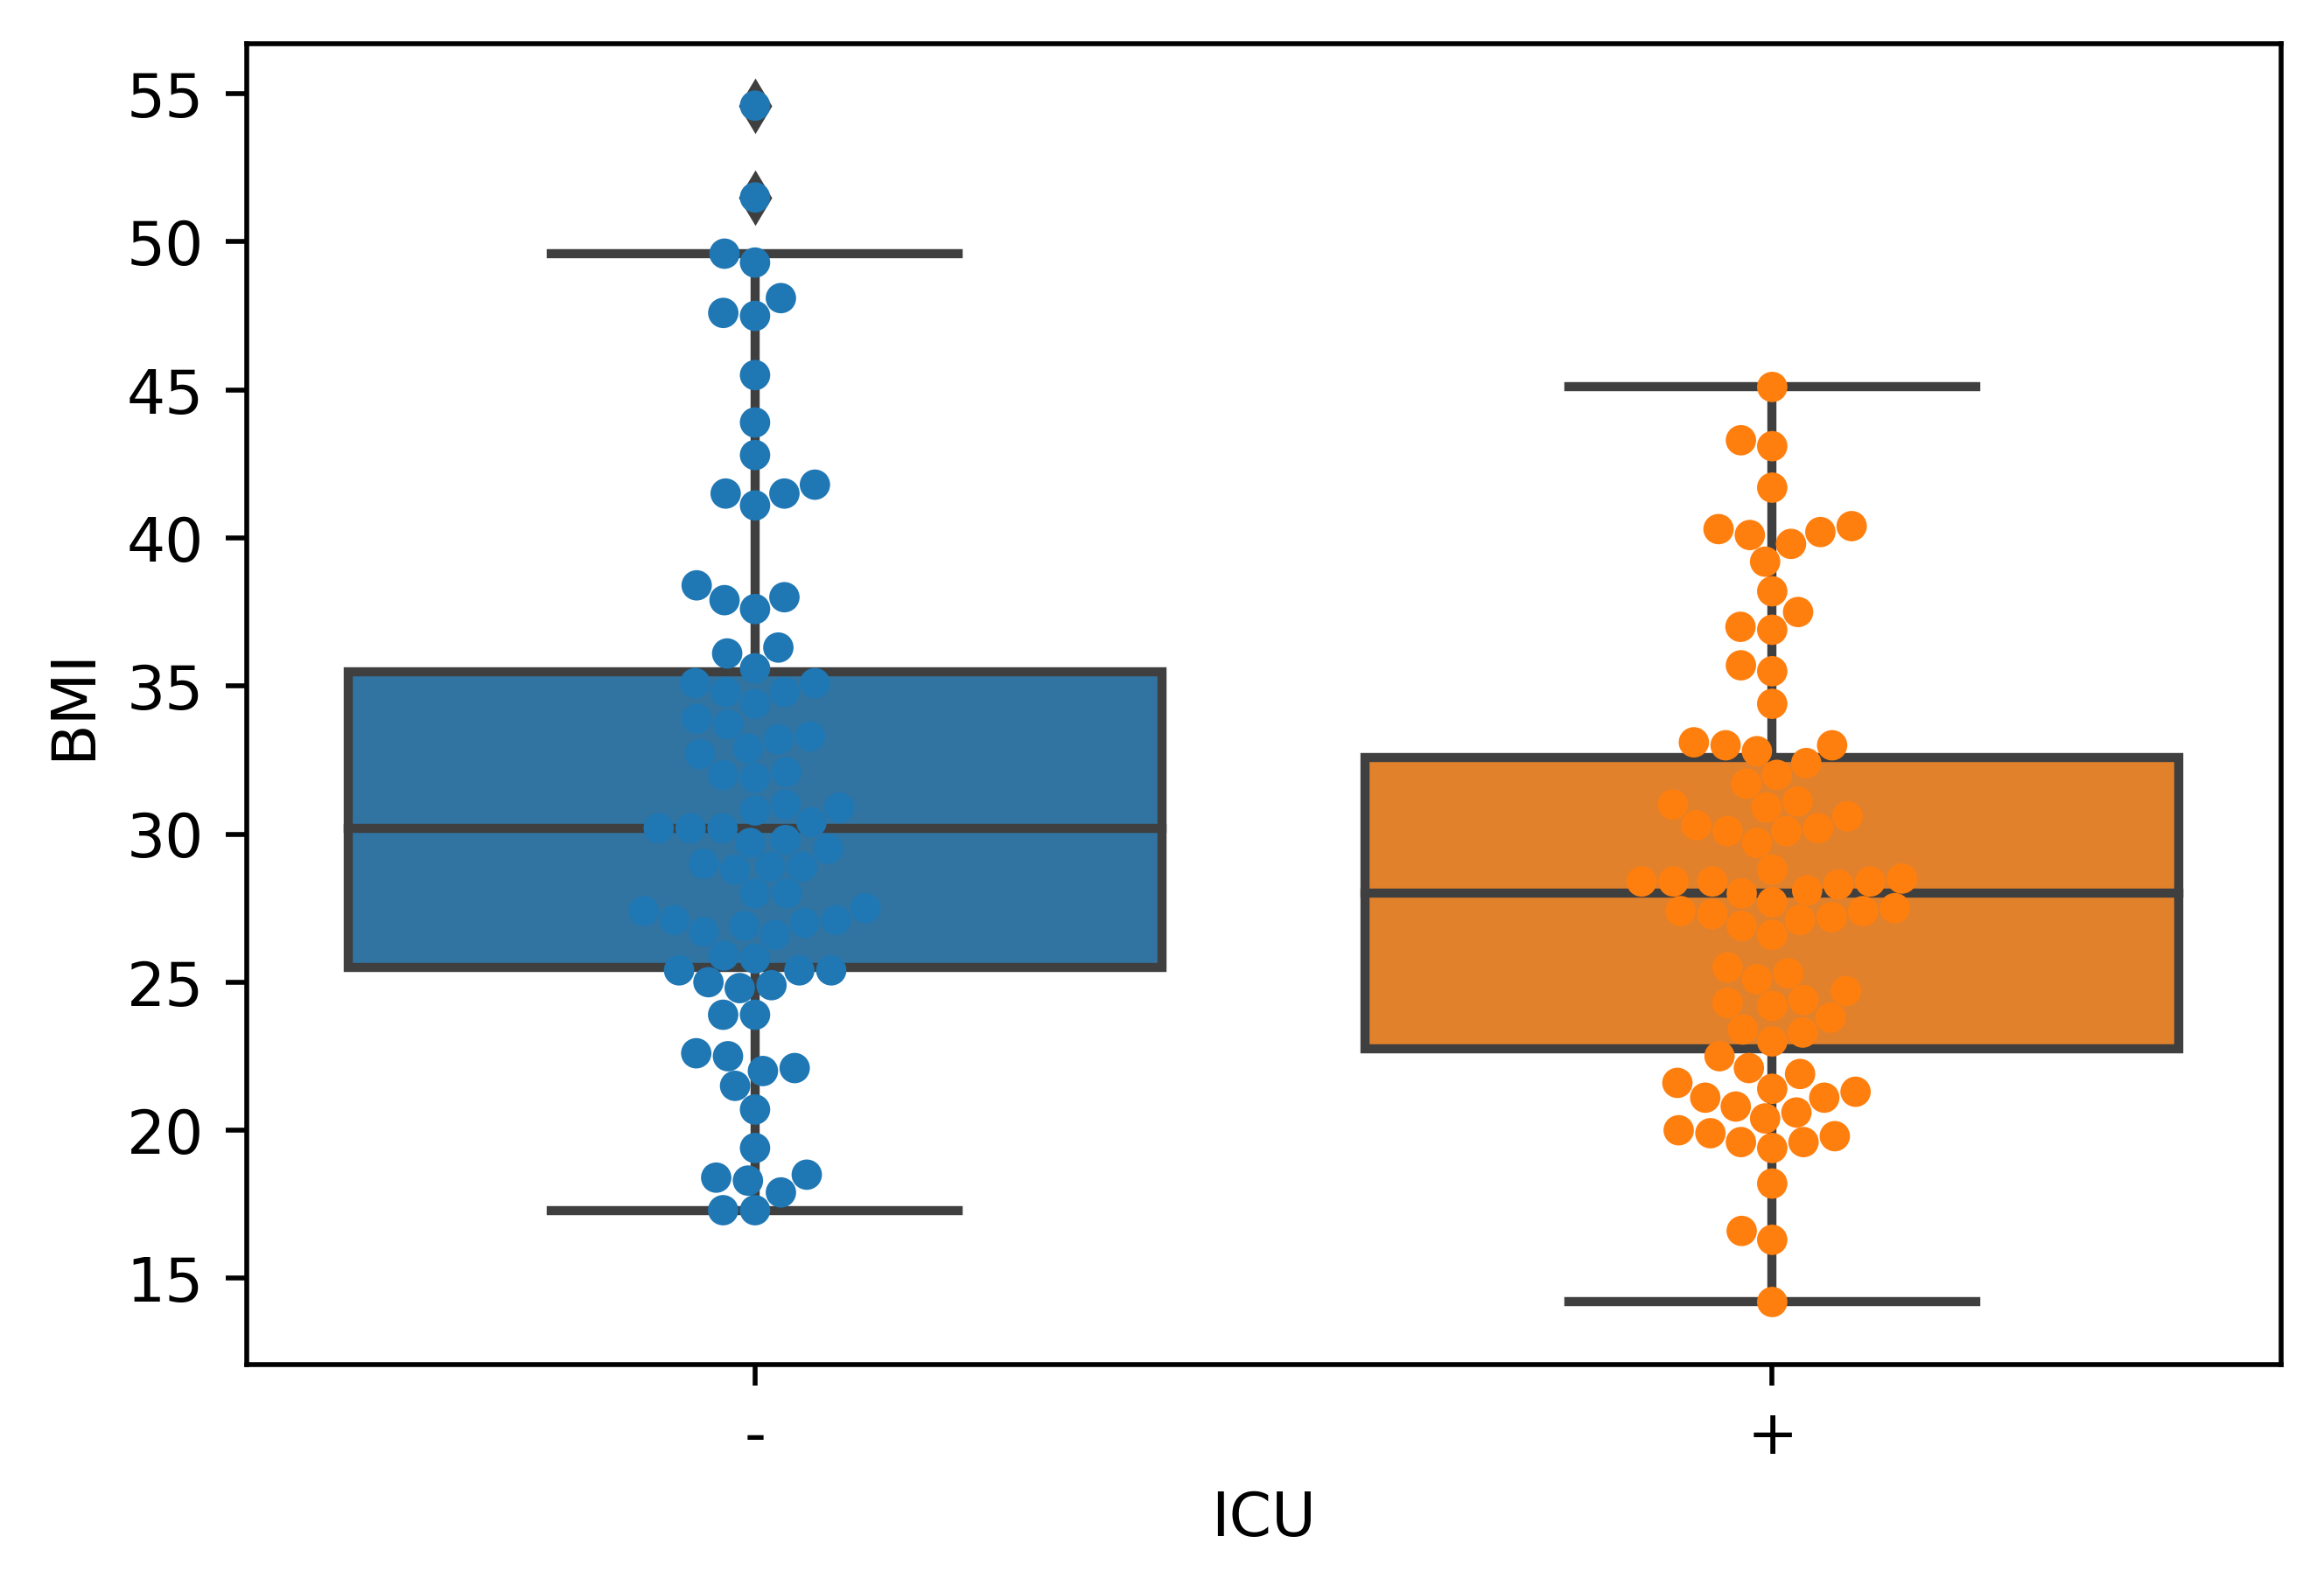

In [11]:
good_train_ind = []
for x,i in zip(X_train_metadata,range(len(X_train_metadata))):
    try: 
        float(x["Age at Symptom onset (years)"])
        float(x["BMI"])
        good_train_ind.append(i)
    except:
        pass
    
        
good_test_ind = []
for x,i in zip(X_test_metadata,range(len(X_test_metadata))):
    try: 
        float(x["Age at Symptom onset (years)"])
        float(x["BMI"])
        good_test_ind.append(i)
    except:
        pass
        


X_train_age = [float(x["Age at Symptom onset (years)"]) for x,i in zip(X_train_metadata,range(len(X_train_metadata))) if i in good_train_ind]
X_test_age = [float(x["Age at Symptom onset (years)"]) for x,i in zip(X_test_metadata,range(len(X_test_metadata))) if i in good_test_ind]
X_train_bmi = [float(x["BMI"]) for x,i in zip(X_train_metadata,range(len(X_train_metadata))) if i in good_train_ind]
X_test_bmi = [float(x["BMI"]) for x,i in zip(X_test_metadata,range(len(X_test_metadata))) if i in good_test_ind]
X_train_baseline = np.array([X_train_age,X_train_bmi]).transpose()
X_test_baseline = np.array([X_test_age,X_test_bmi]).transpose()

y_train_baseline = y_train[good_train_ind]
y_test_baseline = y_test[good_test_ind]

y_baseline = np.concatenate((y_train_baseline,y_test_baseline))

X_baseline = np.concatenate((X_train_baseline,X_test_baseline))
plt.scatter(X_baseline[:,0],X_baseline[:,1],c=y_baseline)
plt.xlabel("Age")
plt.ylabel("BMI")

negSamples_X_baseline = np.array([x for x,yy in zip(X_baseline,y_baseline) if yy < .5])
posSamples_X_baseline = np.array([x for x,yy in zip(X_baseline,y_baseline) if yy > .5])

plt.colorbar()

plt.figure()

plot_dict = {}
ind = 0
for samp in negSamples_X_baseline:
    plot_dict[ind] = {"ICU":"-","Age":samp[0],"BMI":samp[1]}
    ind += 1
    
for samp in posSamples_X_baseline:
    plot_dict[ind] = {"ICU":"+","Age":samp[0],"BMI":samp[1]}
    ind += 1

plot_df = pd.DataFrame.from_dict(plot_dict,orient="index")

sb.boxplot(data=plot_df,x="ICU",y="Age")
sb.swarmplot(data=plot_df,x="ICU",y="Age")

plt.figure()

sb.boxplot(data=plot_df,x="ICU",y="BMI")
sb.swarmplot(data=plot_df,x="ICU",y="BMI")

print(stats.ttest_ind(negSamples_X_baseline[:,0],posSamples_X_baseline[:,0],equal_var=False))
print(stats.ttest_ind(negSamples_X_baseline[:,1],posSamples_X_baseline[:,1],equal_var=False))

log_reg = sklearn.linear_model.LinearRegression(fit_intercept=True)

log_reg.fit(X_train_baseline,y_train_baseline)

pred_baseline = log_reg.predict(X_test_baseline)

print(helper.score(pred_baseline,y_test_baseline))

[0.0, 0.2857142857142857, 0.23809523809523808, 0.38095238095238093, 0.14285714285714285, 0.5714285714285714, 0.6190476190476191, 0.7619047619047619, 1.0, 0.047619047619047616, 0.5238095238095238, 0.09523809523809523, 0.6666666666666666, 0.19047619047619047, 0.7142857142857143, 0.8095238095238095, 0.3333333333333333, 0.8571428571428571, 0.9047619047619048, 0.42857142857142855, 0.9523809523809523, 0.47619047619047616]


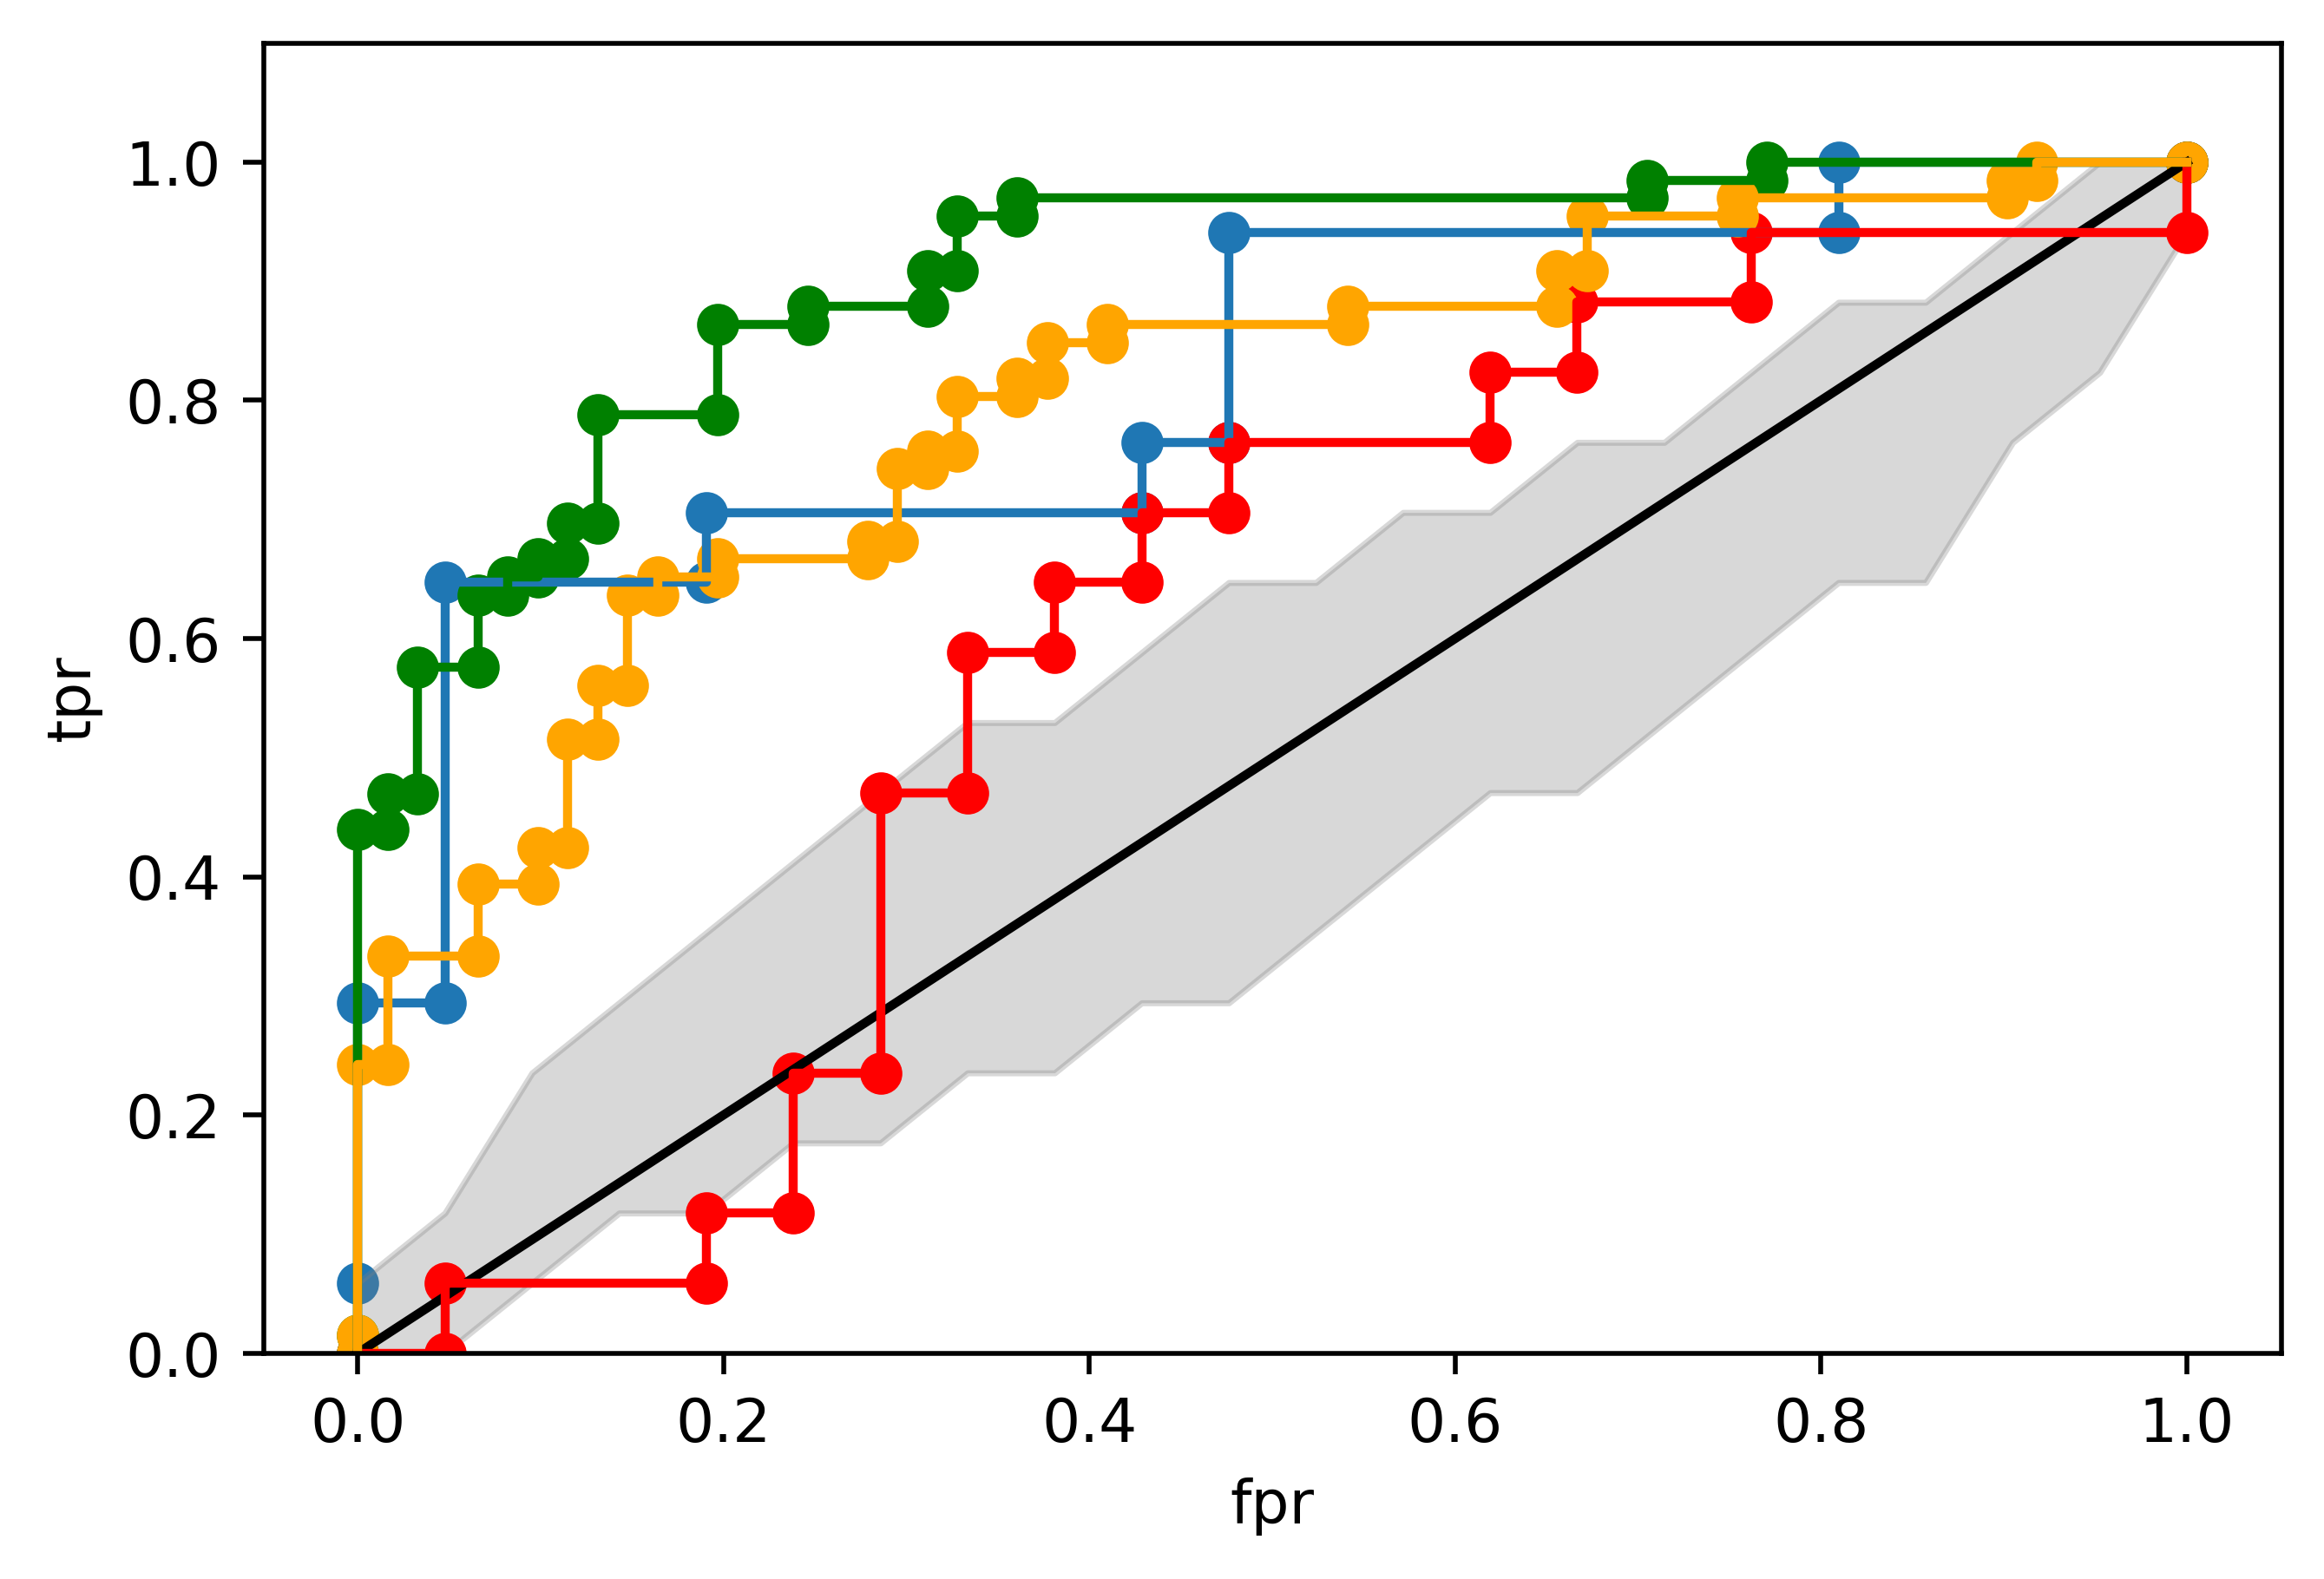

In [12]:
fpr,tpr,thresolds = sklearn.metrics.roc_curve(y_test,y_test_pred)
plt.plot(fpr,tpr)
plt.scatter(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.ylim((0,1.1))
plt.plot([0,1],[0,1],color="black")

fprs = np.array([])
for fpr,tpr in fprs_tprs:
    fprs = np.concatenate((fprs,fpr))
fprs = list(set(fprs))    
print(fprs)
matched_vals = {fpr:[] for fpr in fprs}

for fpr,tpr in fprs_tprs:
    for f,t in zip(fpr,tpr):
        matched_vals[f].append(t)
        
matched_vals = {f:[np.percentile(val,25),np.percentile(val,75)] for f,val in matched_vals.items()}
fpr_rand = list(matched_vals.keys())
fpr_rand.sort()
tpr_min = [matched_vals[f][0] for f in fpr_rand]
tpr_max = [matched_vals[f][1] for f in fpr_rand]

plt.fill_between(fpr_rand,tpr_min,tpr_max,facecolor="grey",color="grey",alpha=.3)


fpr,tpr,thresolds = sklearn.metrics.roc_curve(y_test_baseline,pred_baseline)
plt.plot(fpr,tpr,c="red")
plt.scatter(fpr,tpr,c="red")


fpr,tpr,thresolds = sklearn.metrics.roc_curve(y_train,y_pred_train)
plt.plot(fpr,tpr,c="green")
plt.scatter(fpr,tpr,c="green")

fpr,tpr,thresolds = sklearn.metrics.roc_curve(y_cv,y_pred_cv)
plt.plot(fpr,tpr,c="orange")
plt.scatter(fpr,tpr,c="orange")



707
314
training score:  0.8821627975315898
707
34


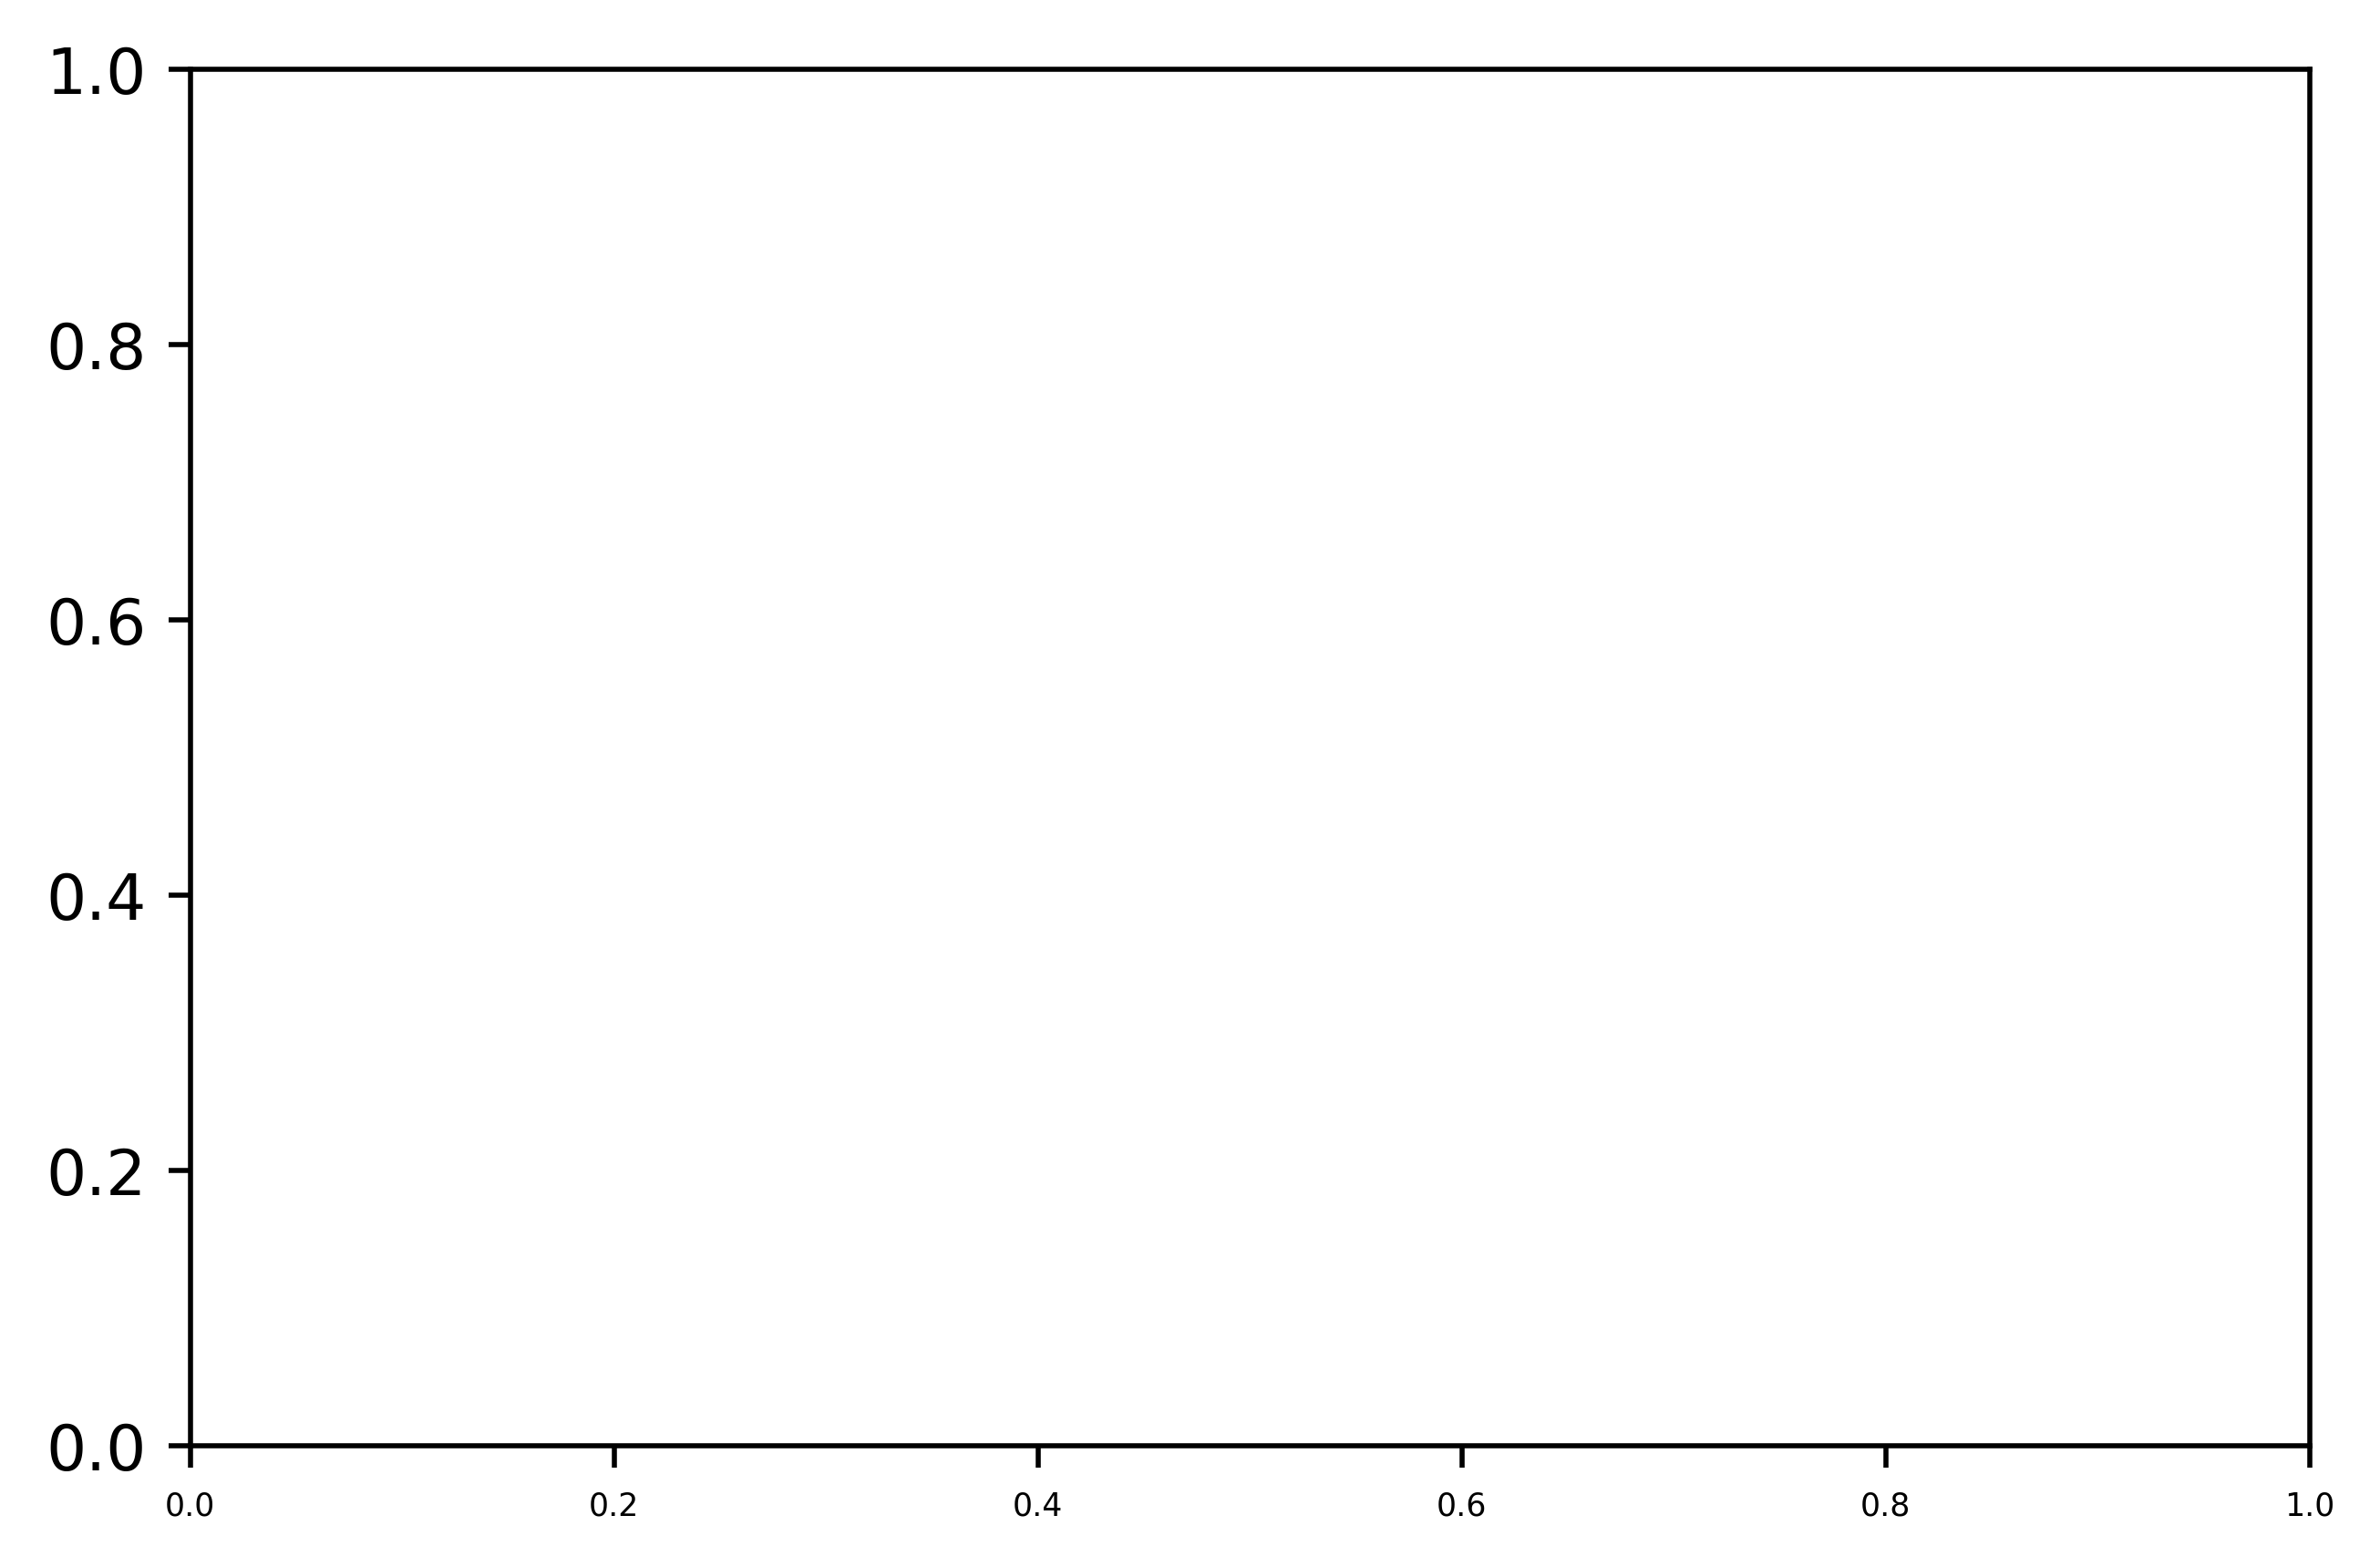

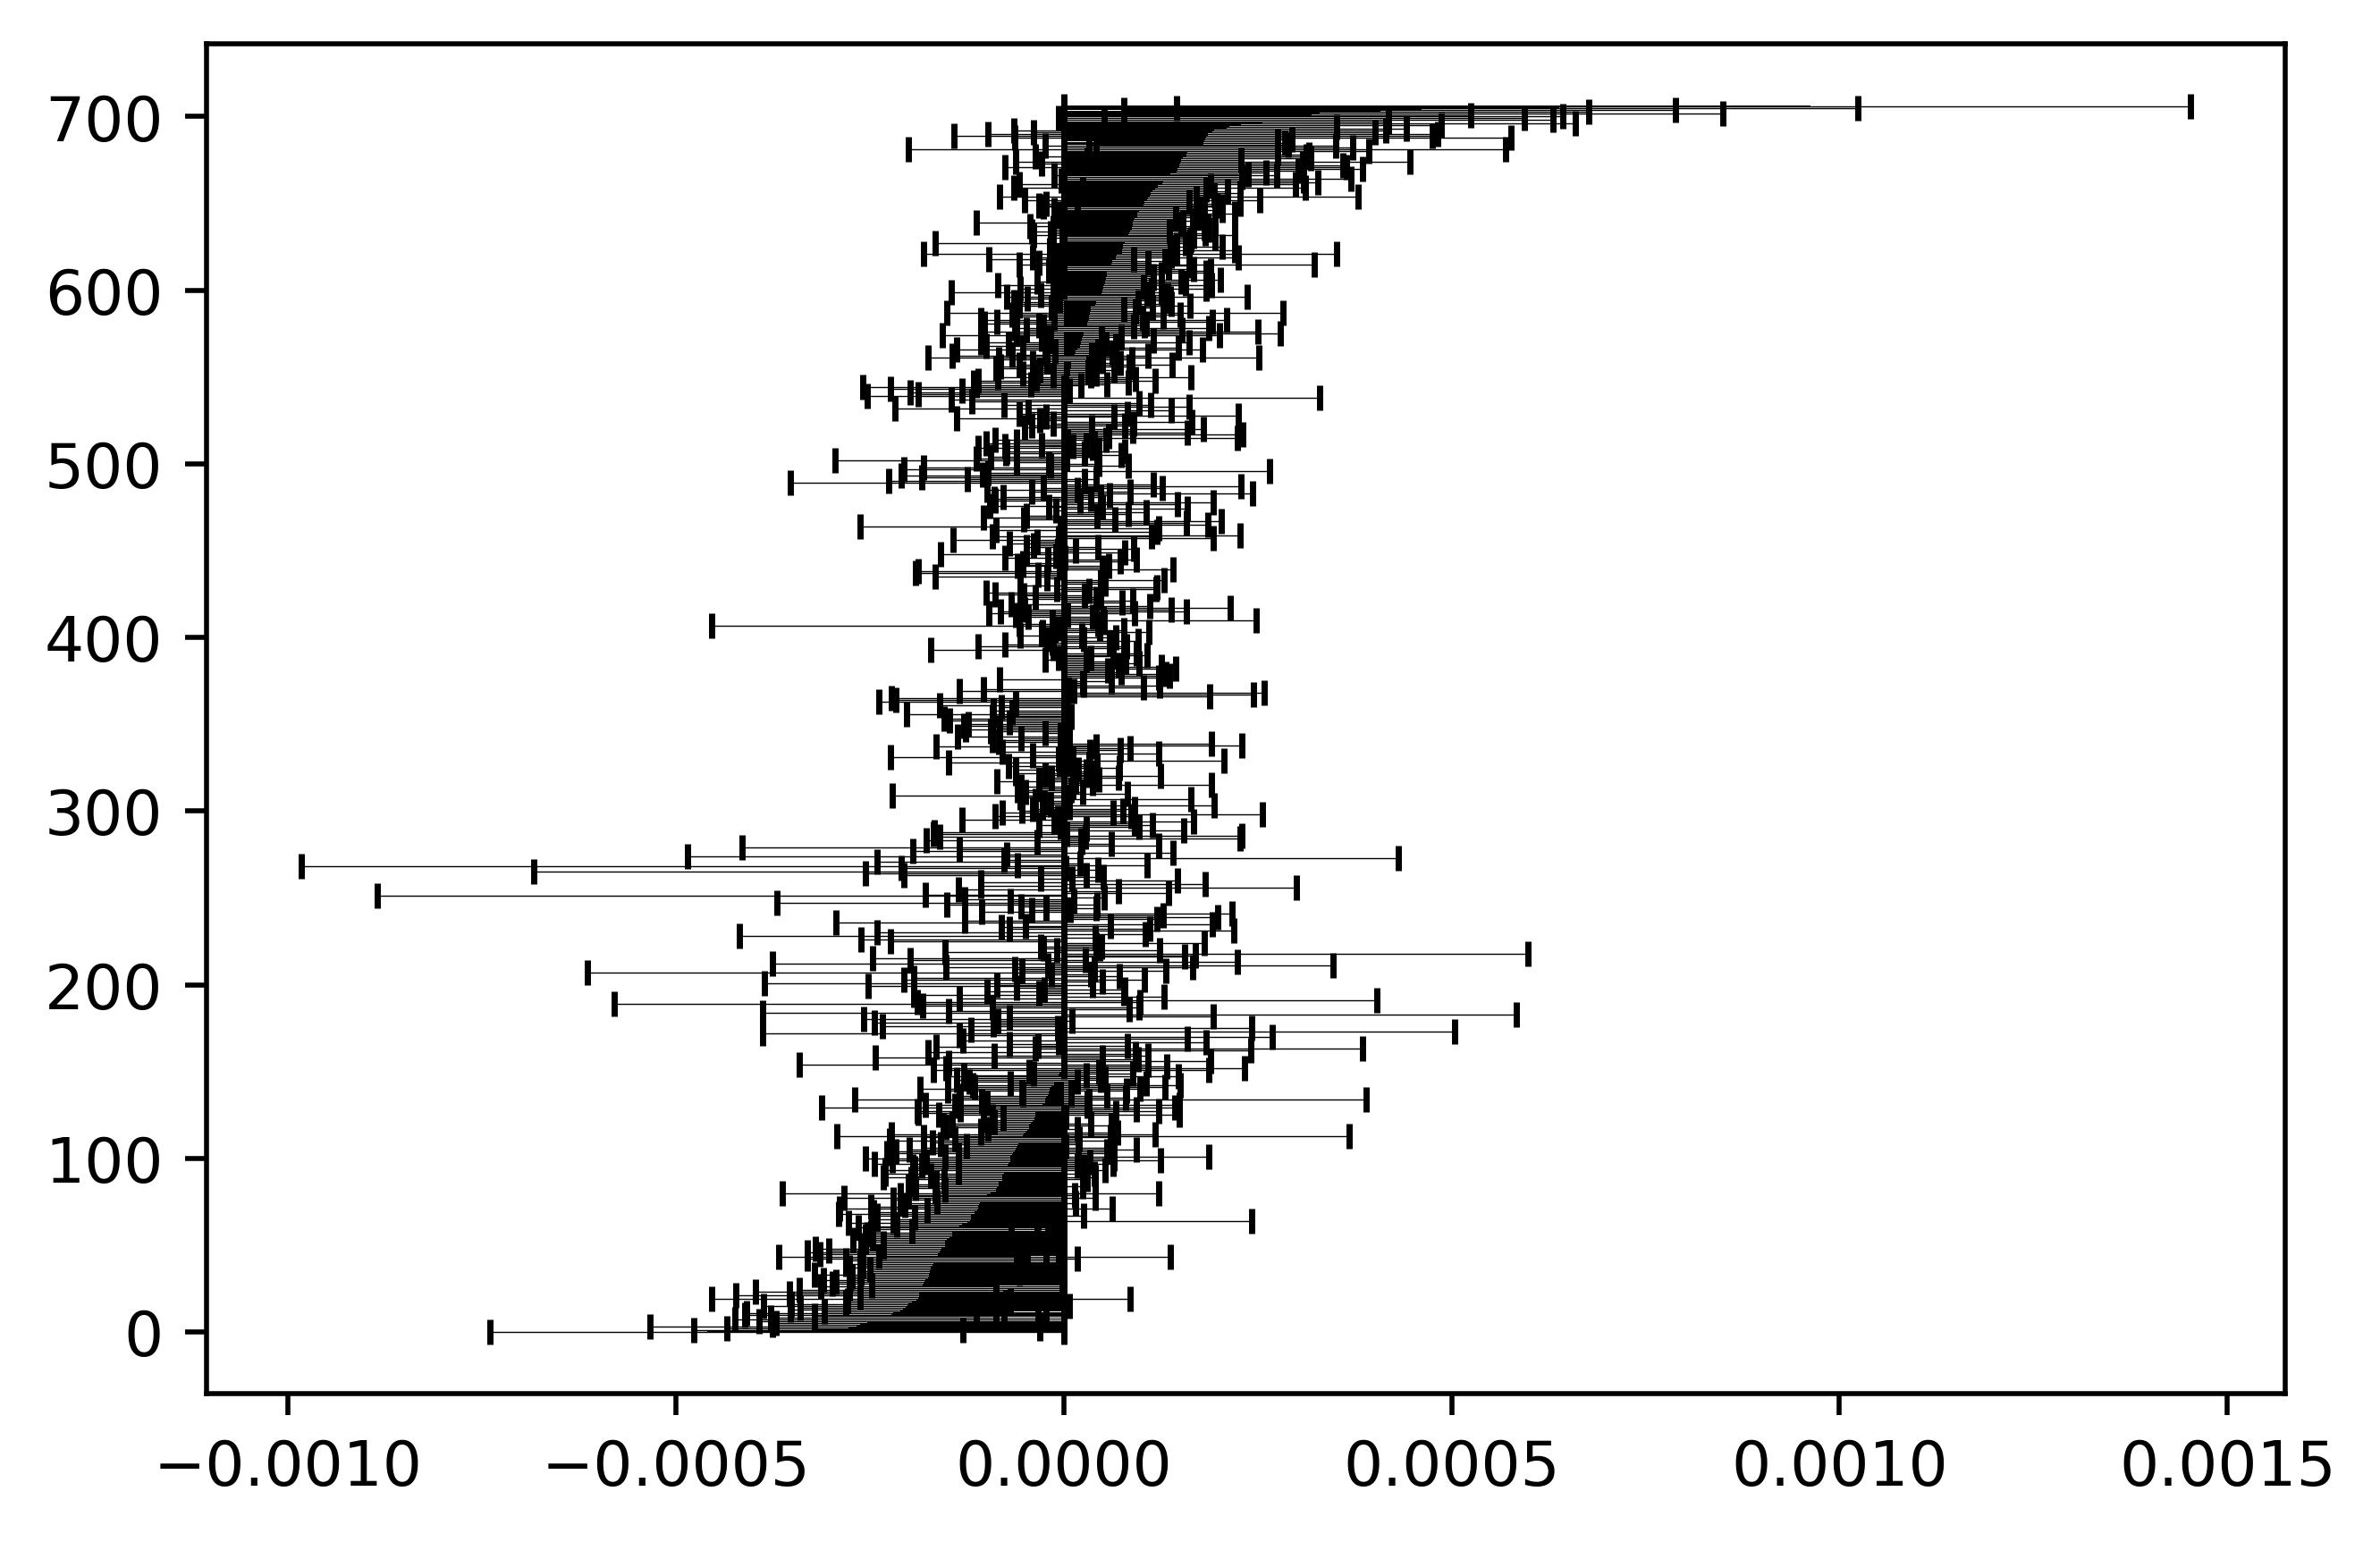

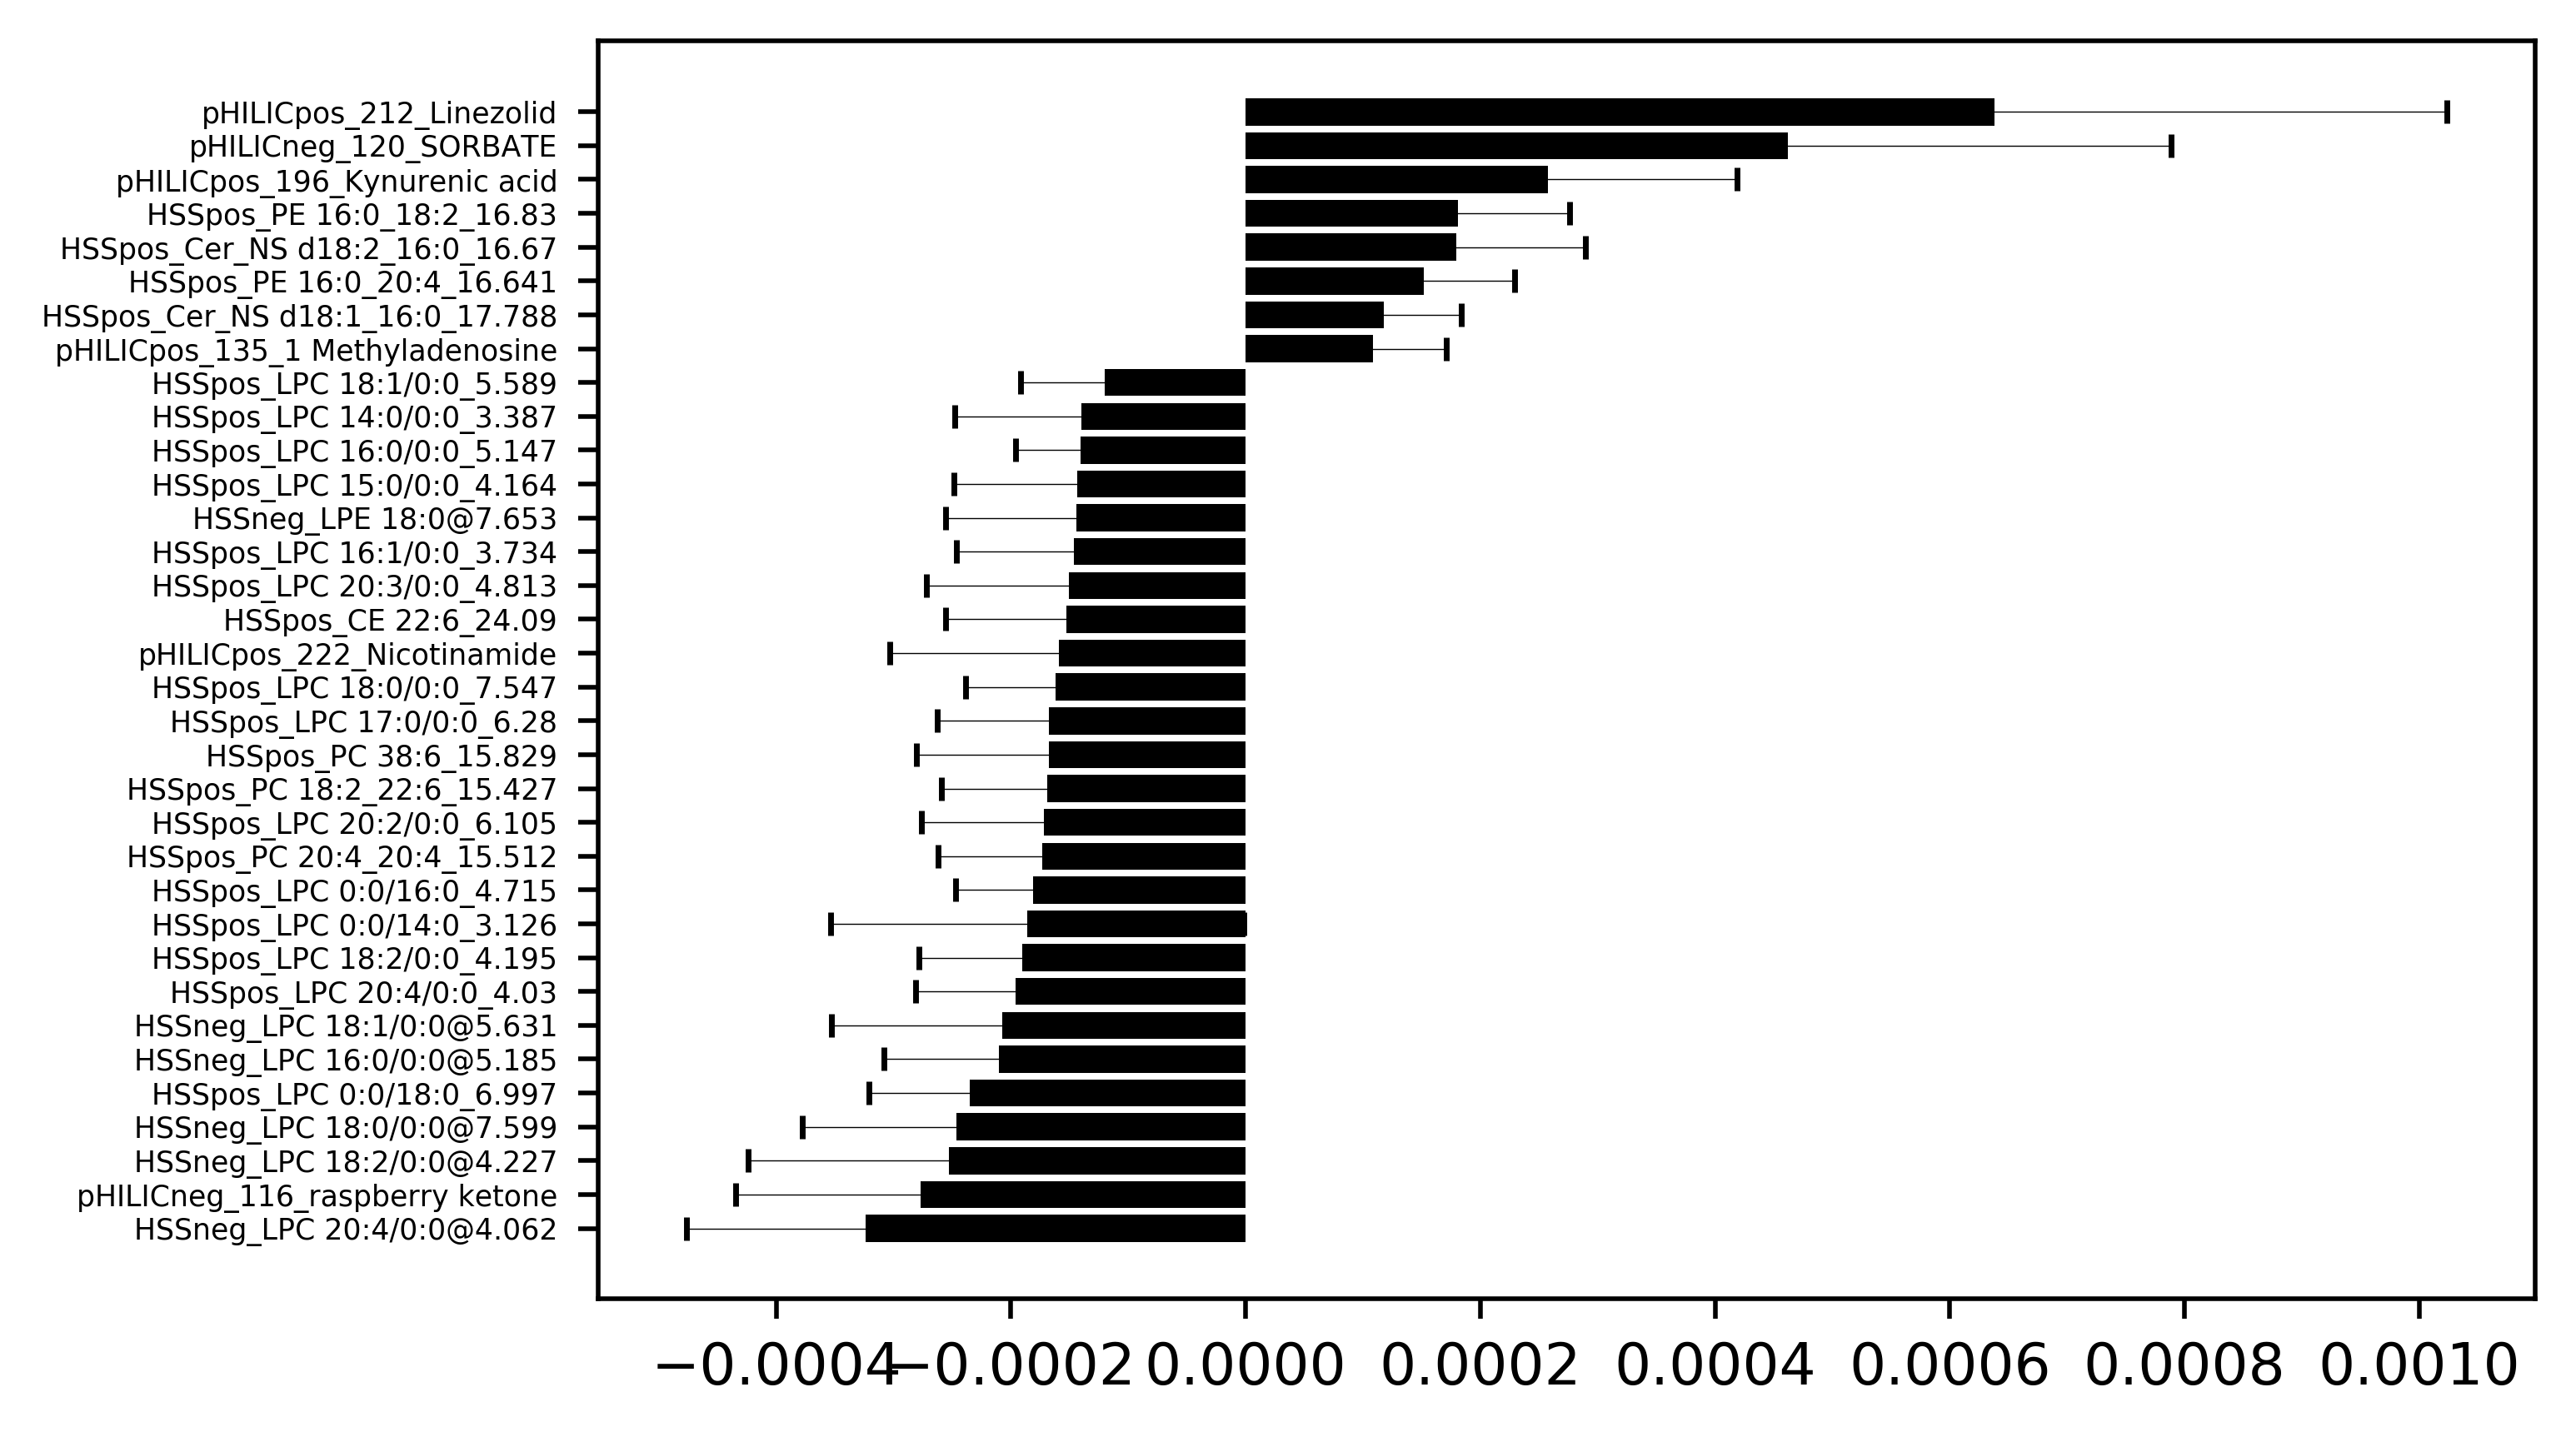

In [13]:

#train on entire dataset
X = np.concatenate((X_train,X_test))
y = np.concatenate((y_train,y_test))
X_blank = X_train_blank

    
plt.figure()
feat_params = params["feat_selection"]
selected_feats = helper.featureSelection(X,y,X_blank,mol_names,feat_params,True,True)


#bootstrap samples
poss = list(range(len(X)))
numBoots = 1000
coefs = np.zeros((numBoots,len(mol_names)))
for x in range(numBoots):
    samp = rd.choices(poss,k=len(poss))
    X_temp = X[samp]
    y_temp = y[samp]
    obj = trainFunc(X_temp,y_temp,X_blank,mol_names,params)
    coefs[x][obj._selectedvars] = np.array(flatten(obj.coef_.tolist()))
    coefs[x] = np.array([coefs[x][i]/np.median(X_temp[:,i]) for i in range(len(mol_names))])
coefs = np.array(coefs).transpose()
print(len(coefs))

coefs_ci = np.array([(np.percentile(x,2.5),np.percentile(x,97.5)) for x in coefs])

print(len(selected_feats))
obj = trainFunc(X, y, X_blank, mol_names, params)
y_pred = predictFunc(obj,X)
err_train = helper.score(y_pred,y)
print("training score: ",err_train)
#print(sklearn.metrics.confusion_matrix(y,y_pred))
plt.xticks(fontsize=5)
plt.figure()


var_imp = np.zeros((len(mol_names)))
var_imp[obj._selectedvars] = np.array(flatten(obj.coef_.tolist()))
var_imp = np.array([var_imp[x]/np.median(X[:,x]) for x in range(len(var_imp))])

coefs_ci_normed = np.array([np.abs(r - vi) for r,vi in zip(coefs_ci,var_imp)])
print(len(var_imp))
order = list(range(len(var_imp)))
order.sort(key=lambda x:var_imp[x])
var_imp = var_imp[order]
coefs = coefs[order]
coefs_ci = coefs_ci[order]
coefs_ci_normed = coefs_ci_normed[order]

plt.barh(range(len(var_imp)),width = var_imp,xerr=[coefs_ci_normed[:,0],coefs_ci_normed[:,1]],ecolor="black",capsize=2,error_kw={"elinewidth":0.2,"barsabove":False},color="black")

plt.figure()

#filter out feats passing zero

goodMets = []
for x in range(len(coefs)):
    if coefs_ci[x][0] * coefs_ci[x][1] > 0:
        goodMets.append(x)
        
mol_names_sorted = mol_names[order]

plt.barh(range(len(goodMets)),width = var_imp[goodMets],xerr=[coefs_ci_normed[goodMets,0],coefs_ci_normed[goodMets,1]],ecolor="black",capsize=2,error_kw={"elinewidth":0.2,"barsabove":False},color="black")

plt.yticks(range(len(goodMets)),mol_names_sorted[goodMets],fontsize=5)
print(len(goodMets))


In [14]:
#output sig mets
goodMetDict = {}
for x in goodMets:
    print(mol_names_sorted[x])
    goodMetDict[mol_names_sorted[x]] = {"var_imp":var_imp[x],"lb":coefs_ci_normed[x,0],"ub":coefs_ci_normed[x,1]}


HSSneg_LPC 20:4/0:0@4.062
pHILICneg_116_raspberry ketone
HSSneg_LPC 18:2/0:0@4.227
HSSneg_LPC 18:0/0:0@7.599
HSSpos_LPC 0:0/18:0_6.997
HSSneg_LPC 16:0/0:0@5.185
HSSneg_LPC 18:1/0:0@5.631
HSSpos_LPC 20:4/0:0_4.03
HSSpos_LPC 18:2/0:0_4.195
HSSpos_LPC 0:0/14:0_3.126
HSSpos_LPC 0:0/16:0_4.715
HSSpos_PC 20:4_20:4_15.512
HSSpos_LPC 20:2/0:0_6.105
HSSpos_PC 18:2_22:6_15.427
HSSpos_PC 38:6_15.829
HSSpos_LPC 17:0/0:0_6.28
HSSpos_LPC 18:0/0:0_7.547
pHILICpos_222_Nicotinamide
HSSpos_CE 22:6_24.09
HSSpos_LPC 20:3/0:0_4.813
HSSpos_LPC 16:1/0:0_3.734
HSSneg_LPE 18:0@7.653
HSSpos_LPC 15:0/0:0_4.164
HSSpos_LPC 16:0/0:0_5.147
HSSpos_LPC 14:0/0:0_3.387
HSSpos_LPC 18:1/0:0_5.589
pHILICpos_135_1 Methyladenosine
HSSpos_Cer_NS d18:1_16:0_17.788
HSSpos_PE 16:0_20:4_16.641
HSSpos_Cer_NS d18:2_16:0_16.67
HSSpos_PE 16:0_18:2_16.83
pHILICpos_196_Kynurenic acid
pHILICneg_120_SORBATE
pHILICpos_212_Linezolid


148


Text(0, 0.5, 'Metabolite')

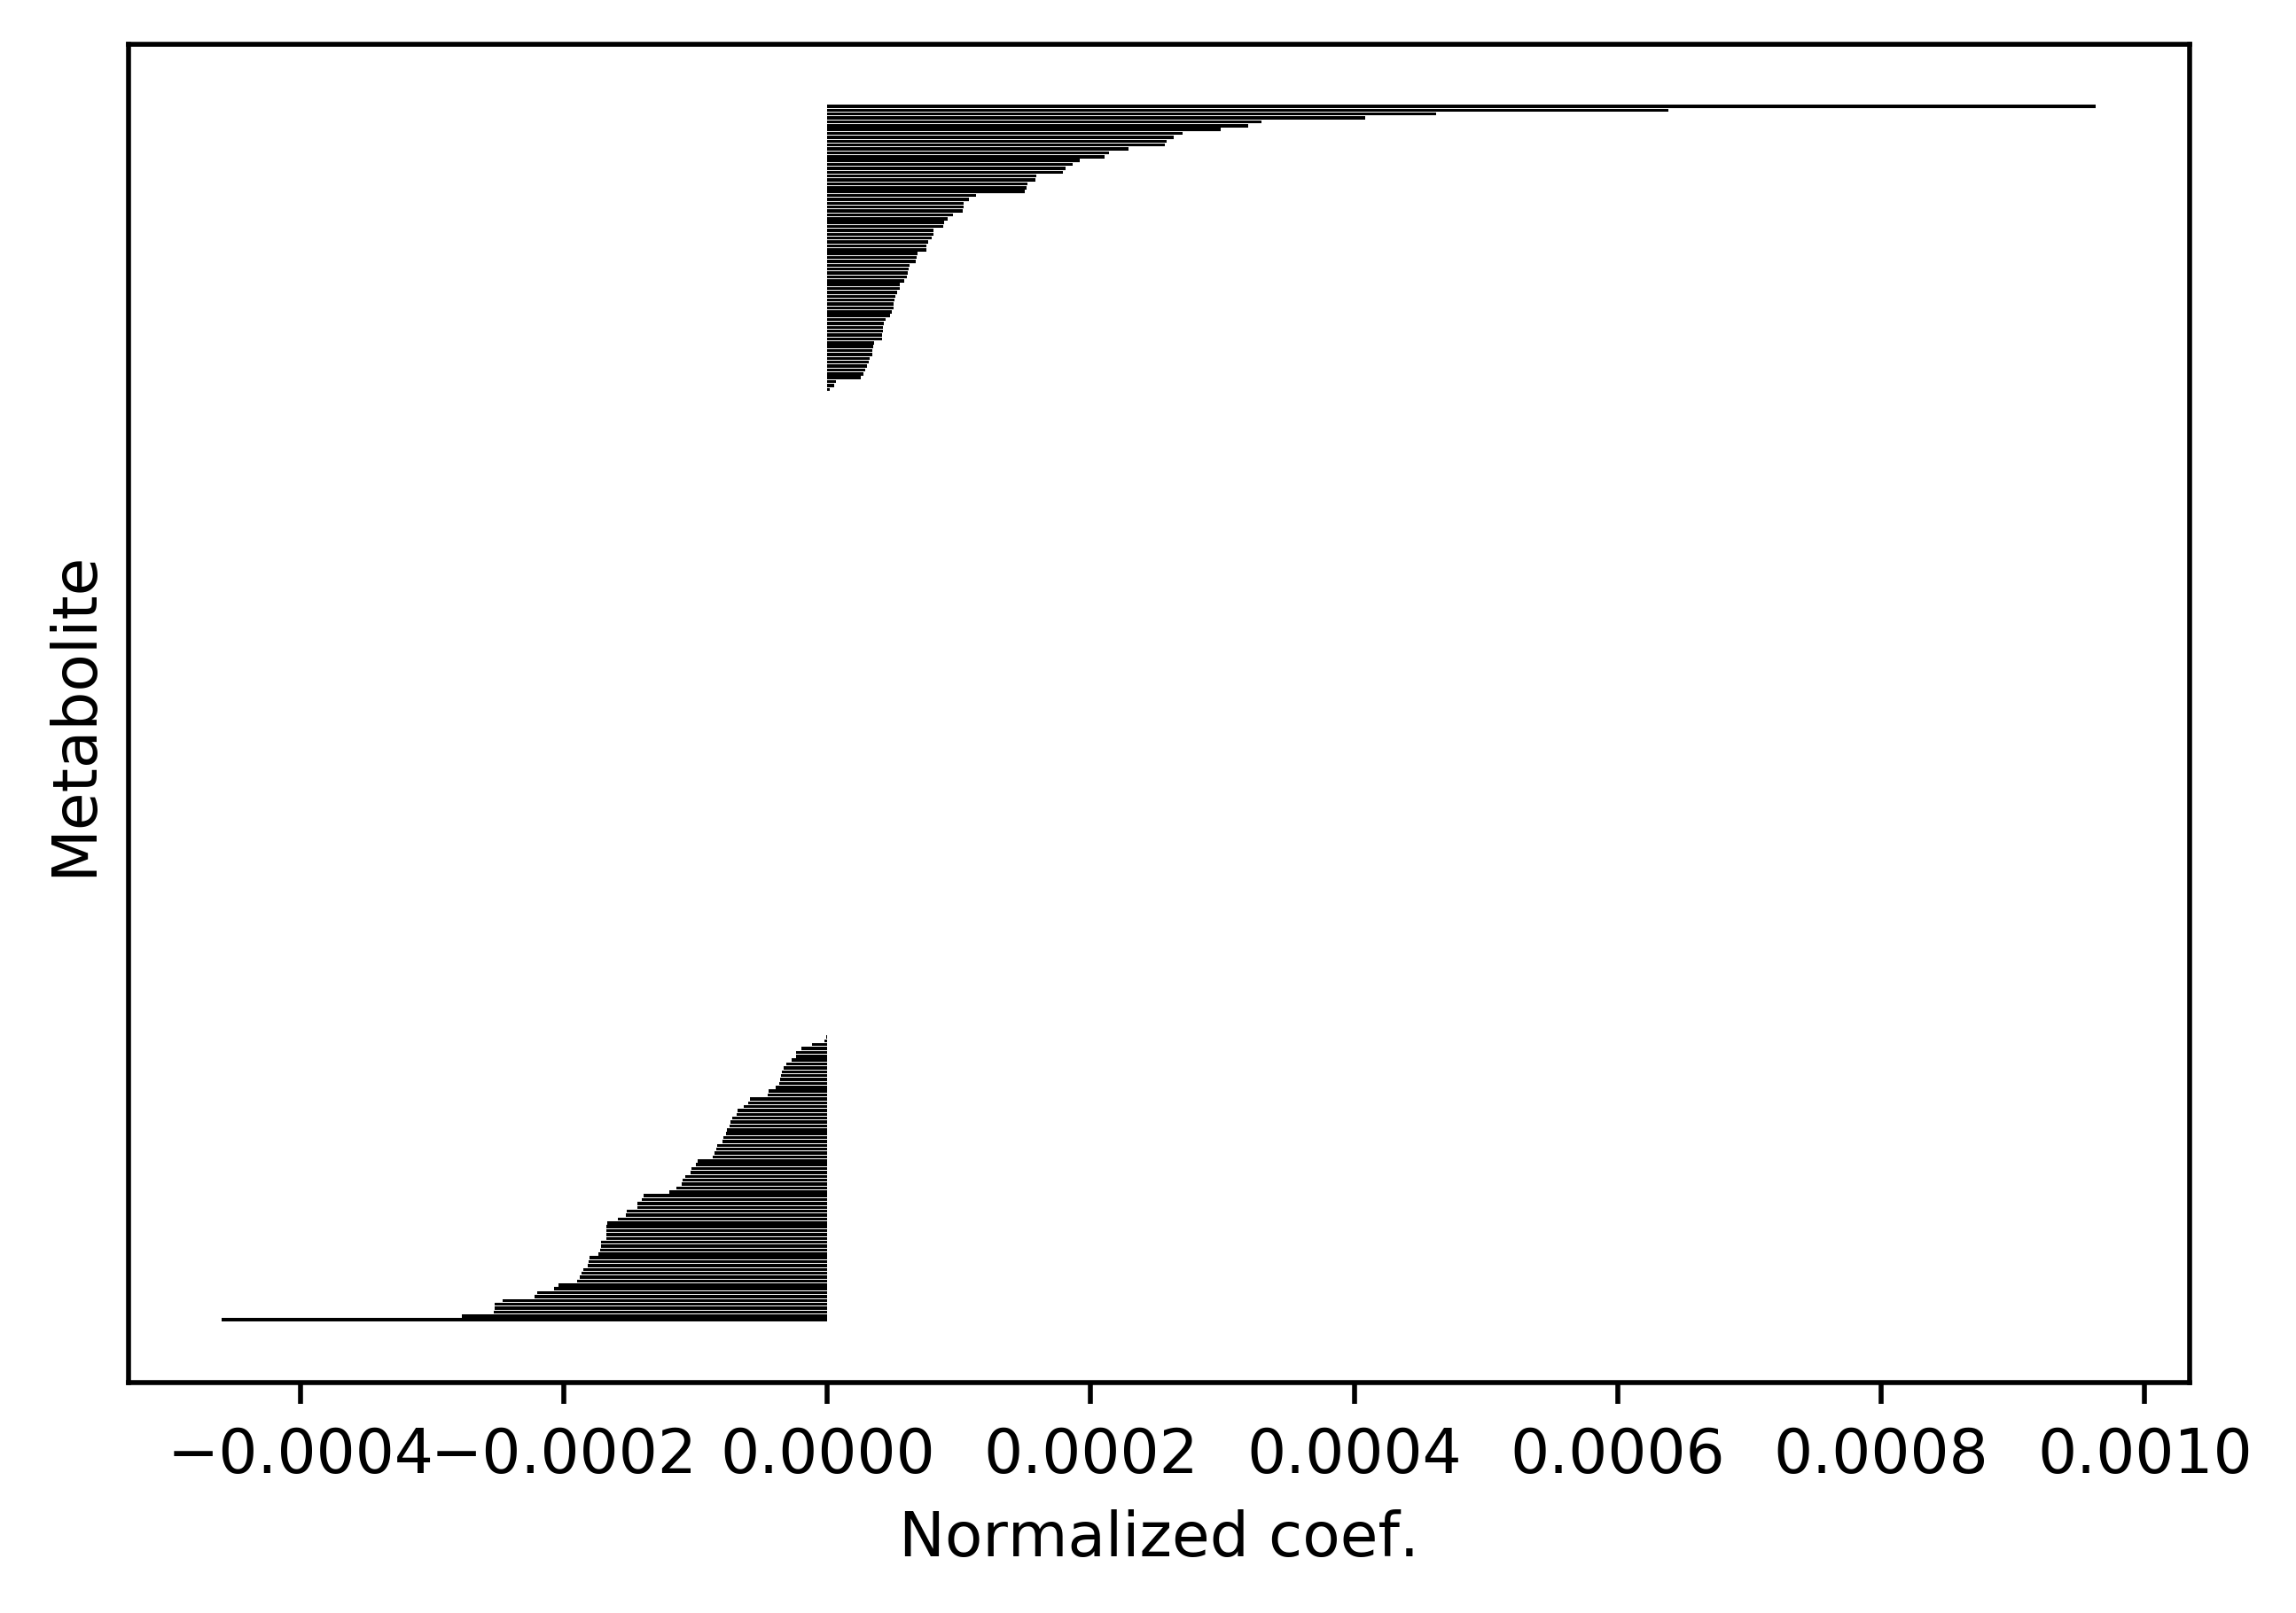

In [15]:
obj = trainFunc(X,y,X_blank,mol_names,params)
rel = var_imp[obj._selectedvars]
print(len([x for x in rel if np.abs(x) > 0]))
names = mol_names[obj._selectedvars]
o = list(range(len(rel)))
o.sort(key=lambda x:rel[x])
rel = rel[o]
names = names[o]
plt.barh(range(len(rel)),width = rel,color="black")
plt.yticks([])
plt.xlabel("Normalized coef.")
plt.ylabel("Metabolite")

In [17]:
#use confirm samples with signfiicant mets
mod_params = dict(params)
order = np.array(order)
mod_params["feat_selection"] = ("corr",1.0)
obj = trainFunc(X[:,order[goodMets]],y,X_blank[:,order[goodMets]],np.array(mol_names_sorted)[goodMets],mod_params)
y_pred_confirm = predictFunc(obj,X_confirm[:,order[goodMets]])
confirm_score = helper.score(y_pred_confirm,y_confirm)
print("training (b1-6): ",helper.score(predictFunc(obj,X[:,order[goodMets]]),y))
print("test (b7-9):",confirm_score )
y_train_whole = predictFunc(obj,X[:,order[goodMets]])

# obj = trainFunc(X,y,X_blank,mol_names,params)
# y_pred_confirm_all = predictFunc(obj,X_confirm)

numPerm = 1000
res = []
fprs_tprs = []
for _ in range(numPerm):
    order_t = list(range(len(y)))
    rd.shuffle(order_t)
    y_shuff = np.array([y[x] for x in order_t])
    obj = trainFunc(X[:,order[goodMets]], y_shuff, X_train_blank[:,order[goodMets]], np.array(mol_names_sorted)[goodMets], mod_params)
    y_pred = predictFunc(obj,X_confirm[:,order[goodMets]])
    err_shuff = helper.score(y_pred,y_confirm)
    res.append(err_shuff)
    fpr,tpr,_ = sklearn.metrics.roc_curve(y_confirm,y_pred)
    fprs_tprs.append([fpr,tpr])
    


training (b1-6):  0.8230972671172495
test (b7-9): 0.7426724137931034


7
0.7426724137931034


{'whiskers': [<matplotlib.lines.Line2D at 0x22e996fec48>,
 'caps': [<matplotlib.lines.Line2D at 0x22e996fe208>,
 'boxes': [<matplotlib.lines.Line2D at 0x22ea4264388>,
 'medians': [<matplotlib.lines.Line2D at 0x22e996de088>,
 'fliers': [<matplotlib.lines.Line2D at 0x22ea426acc8>,
 'means': []}

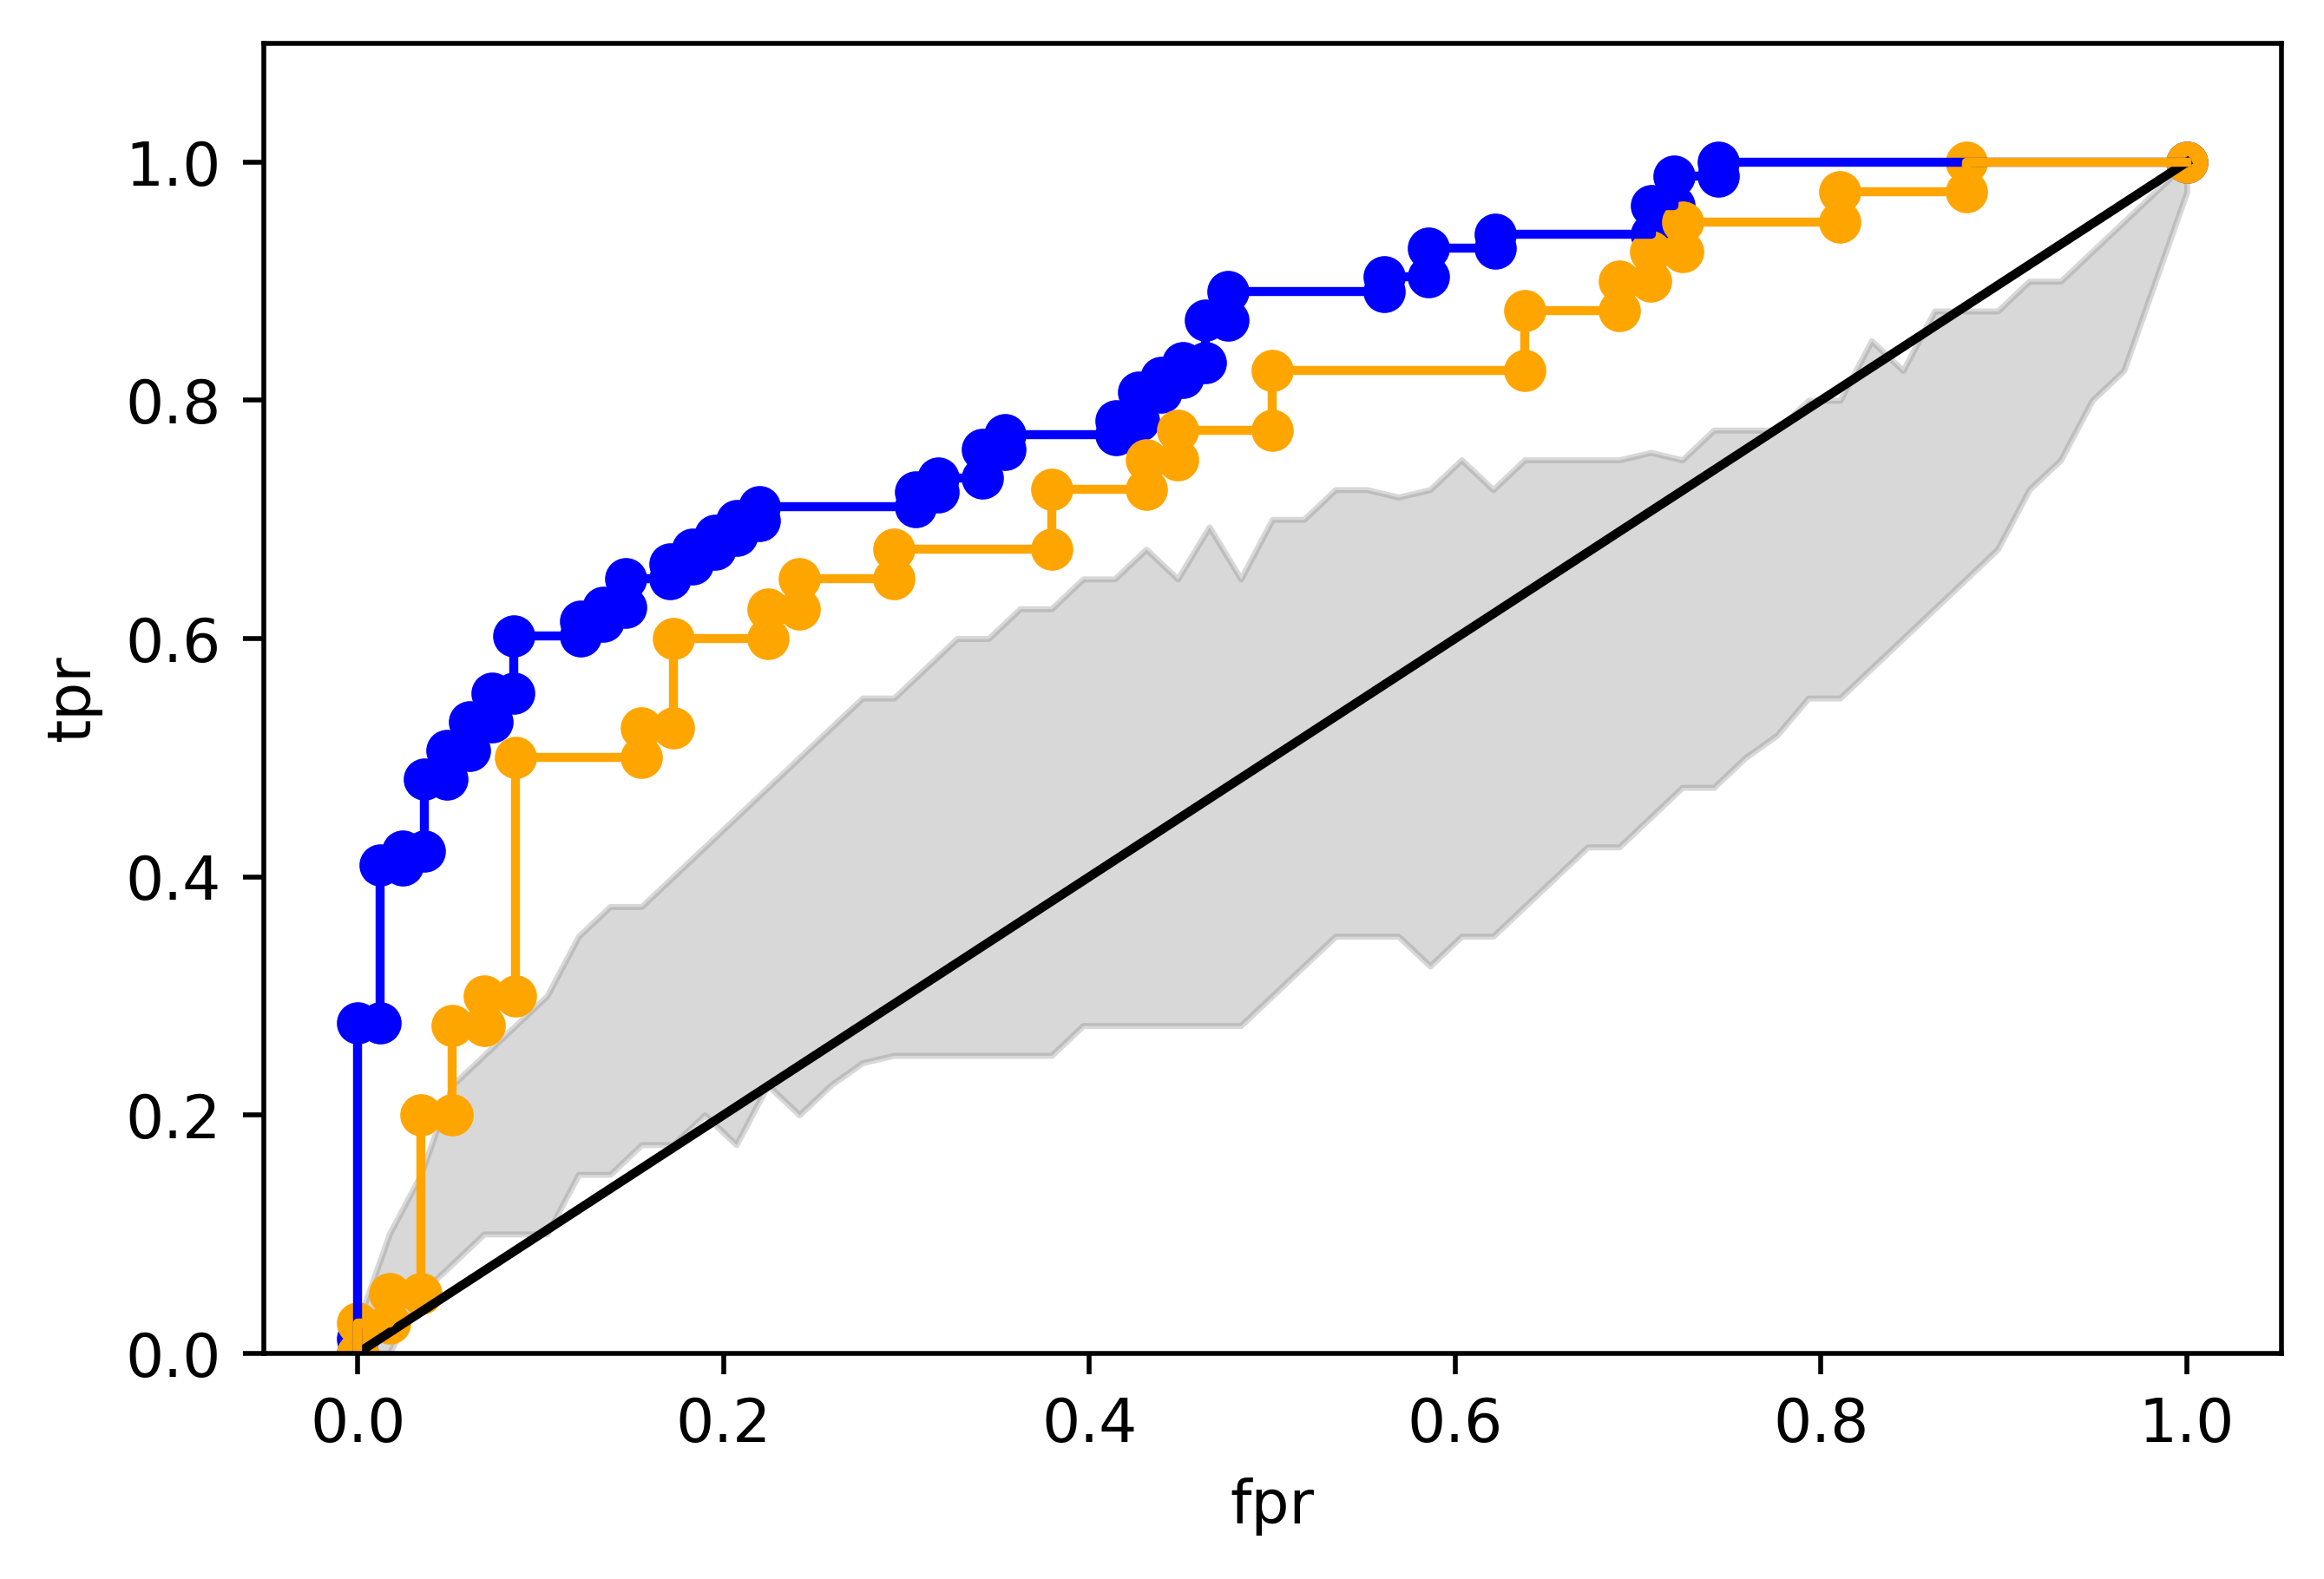

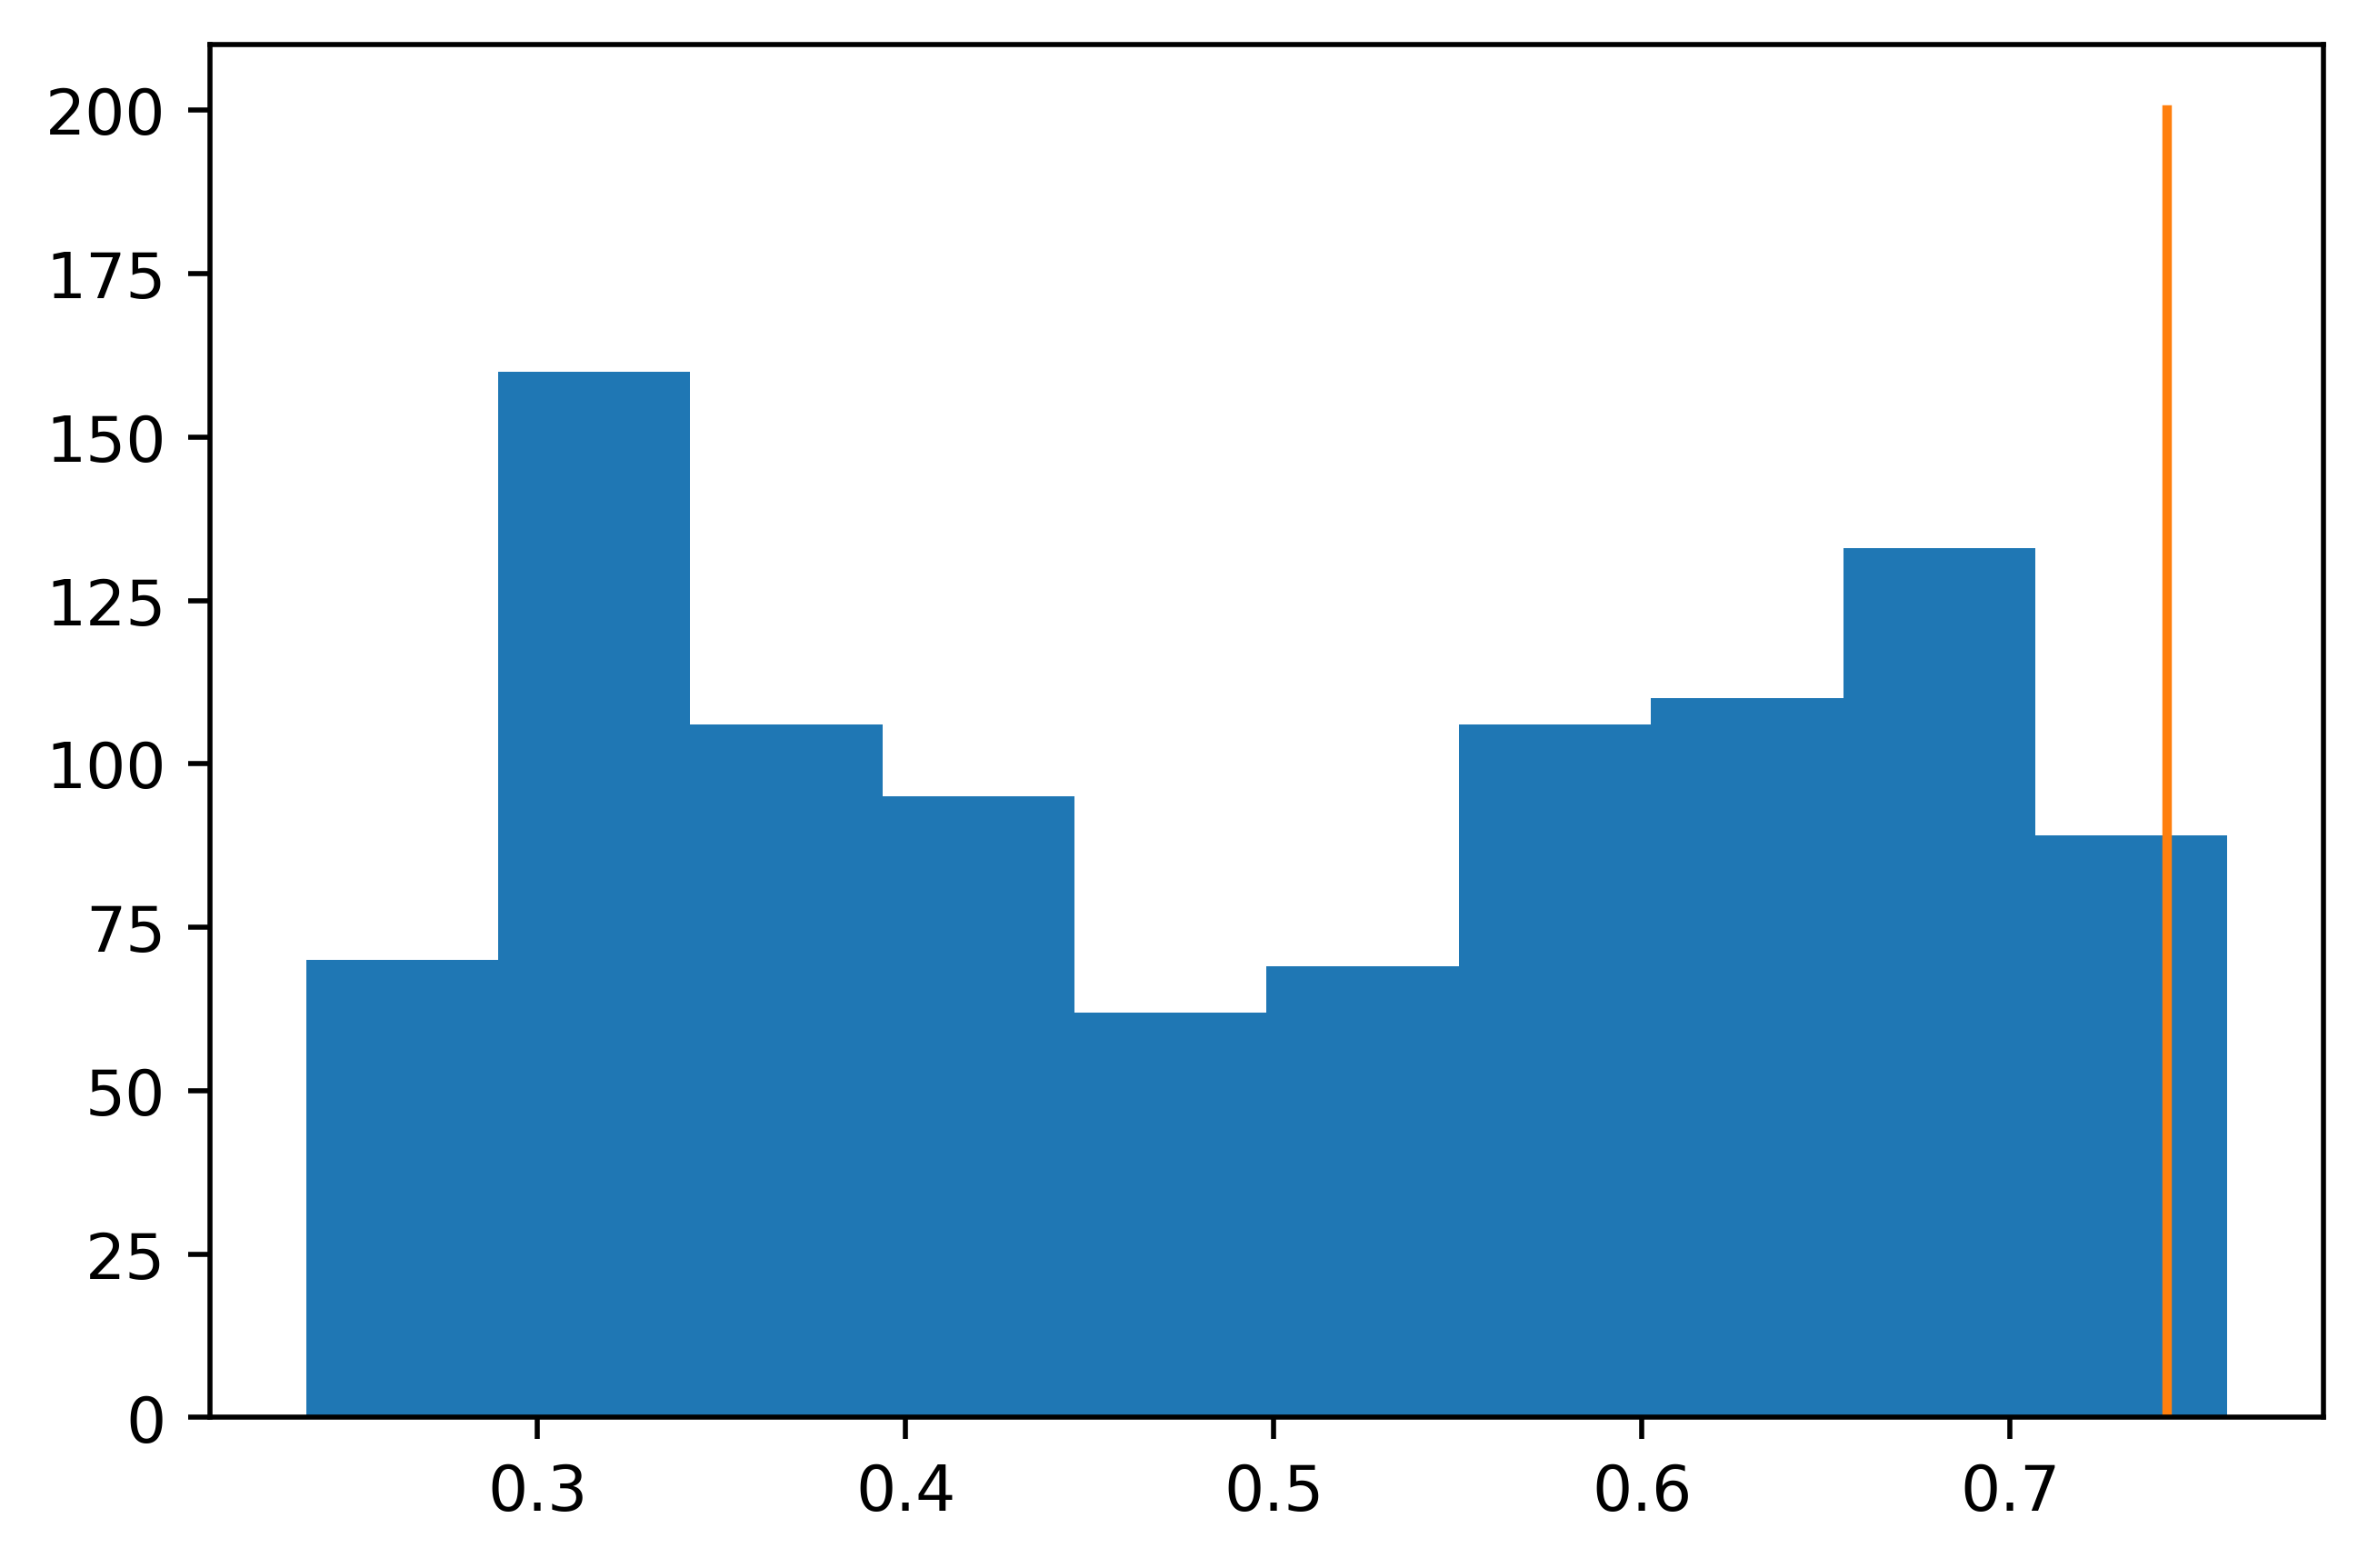

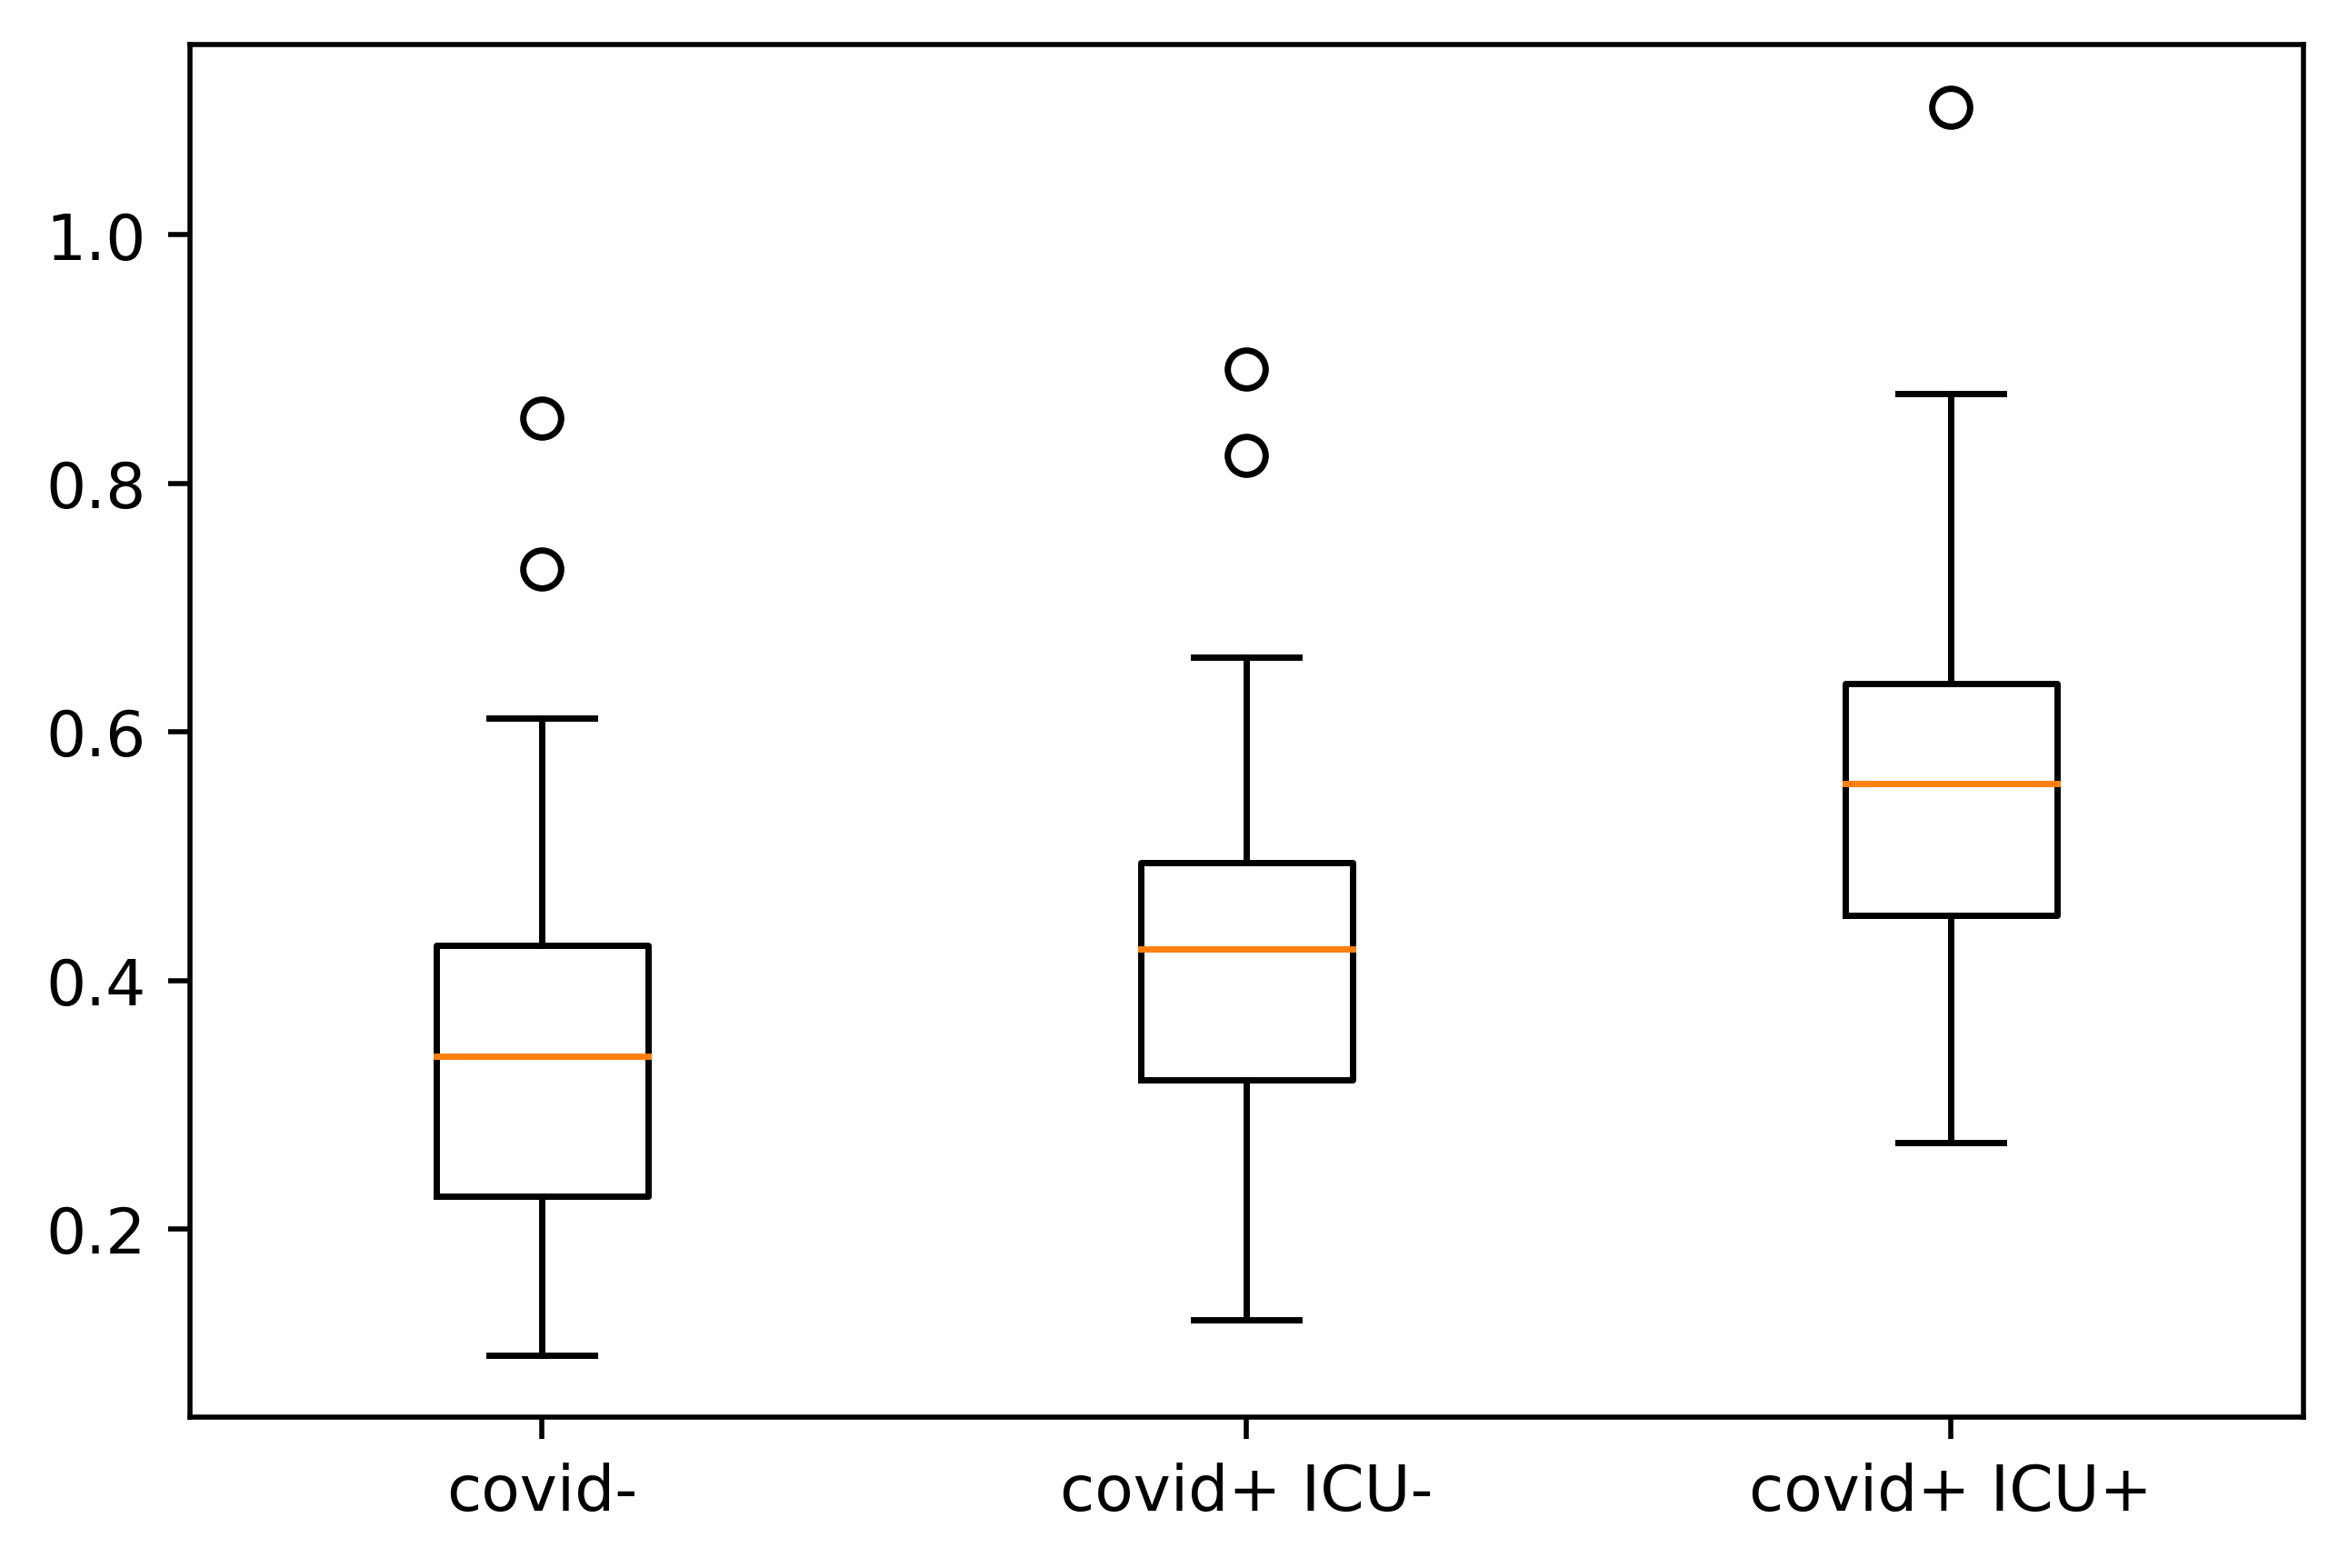

In [31]:
    
# fpr,tpr,thresolds = sklearn.metrics.roc_curve(y,y_train_whole)
# plt.plot(fpr,tpr)
# plt.scatter(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.ylim((0,1.1))
plt.plot([0,1],[0,1],color="black")

fpr,tpr,thresolds = sklearn.metrics.roc_curve(y,y_train_whole)
plt.plot(fpr,tpr,color="blue")
plt.scatter(fpr,tpr,color="blue")
    
print(len([x for x in res if x > confirm_score]))

fprs = np.array([])
for fpr,tpr in fprs_tprs:
    fprs = np.concatenate((fprs,fpr))
fprs = list(set(fprs))    
matched_vals = {fpr:[] for fpr in fprs}

for fpr,tpr in fprs_tprs:
    for f,t in zip(fpr,tpr):
        matched_vals[f].append(t)

matched_vals = {f:[np.percentile(val,25),np.percentile(val,75)] for f,val in matched_vals.items()}
fpr_rand = list(matched_vals.keys())
fpr_rand.sort()
tpr_min = [matched_vals[f][0] for f in fpr_rand]
tpr_max = [matched_vals[f][1] for f in fpr_rand]

plt.fill_between(fpr_rand,tpr_min,tpr_max,facecolor="grey",color="grey",alpha=.3)

obj = trainFunc(X[:,order[goodMets]],y,X_blank[:,order[goodMets]],np.array(mol_names_sorted)[goodMets],mod_params)
y_pred_confirm_all = predictFunc(obj,X_confirm[:,order[goodMets]])

print(helper.score(y_pred_confirm_all,y_confirm))

fpr,tpr,thresolds = sklearn.metrics.roc_curve(y_confirm,y_pred_confirm_all)
plt.plot(fpr,tpr,color="orange")
plt.scatter(fpr,tpr,color="orange")
    
#plot histogram
plt.figure()
plt.hist(res)
plt.plot([confirm_score,confirm_score],[0,.2*numPerm])

y_val_pred = predictFunc(obj,X_val[:,order[goodMets]])
y_neg_pred = [y_pred_confirm_all[x] for x in range(len(y_confirm)) if y_confirm[x] < .5]
y_pos_pred = [y_pred_confirm_all[x] for x in range(len(y_confirm)) if y_confirm[x] > .5]


plt.figure()
plt.boxplot([y_val_pred,y_neg_pred,y_pos_pred],labels=["covid-","covid+ ICU-","covid+ ICU+"])



34


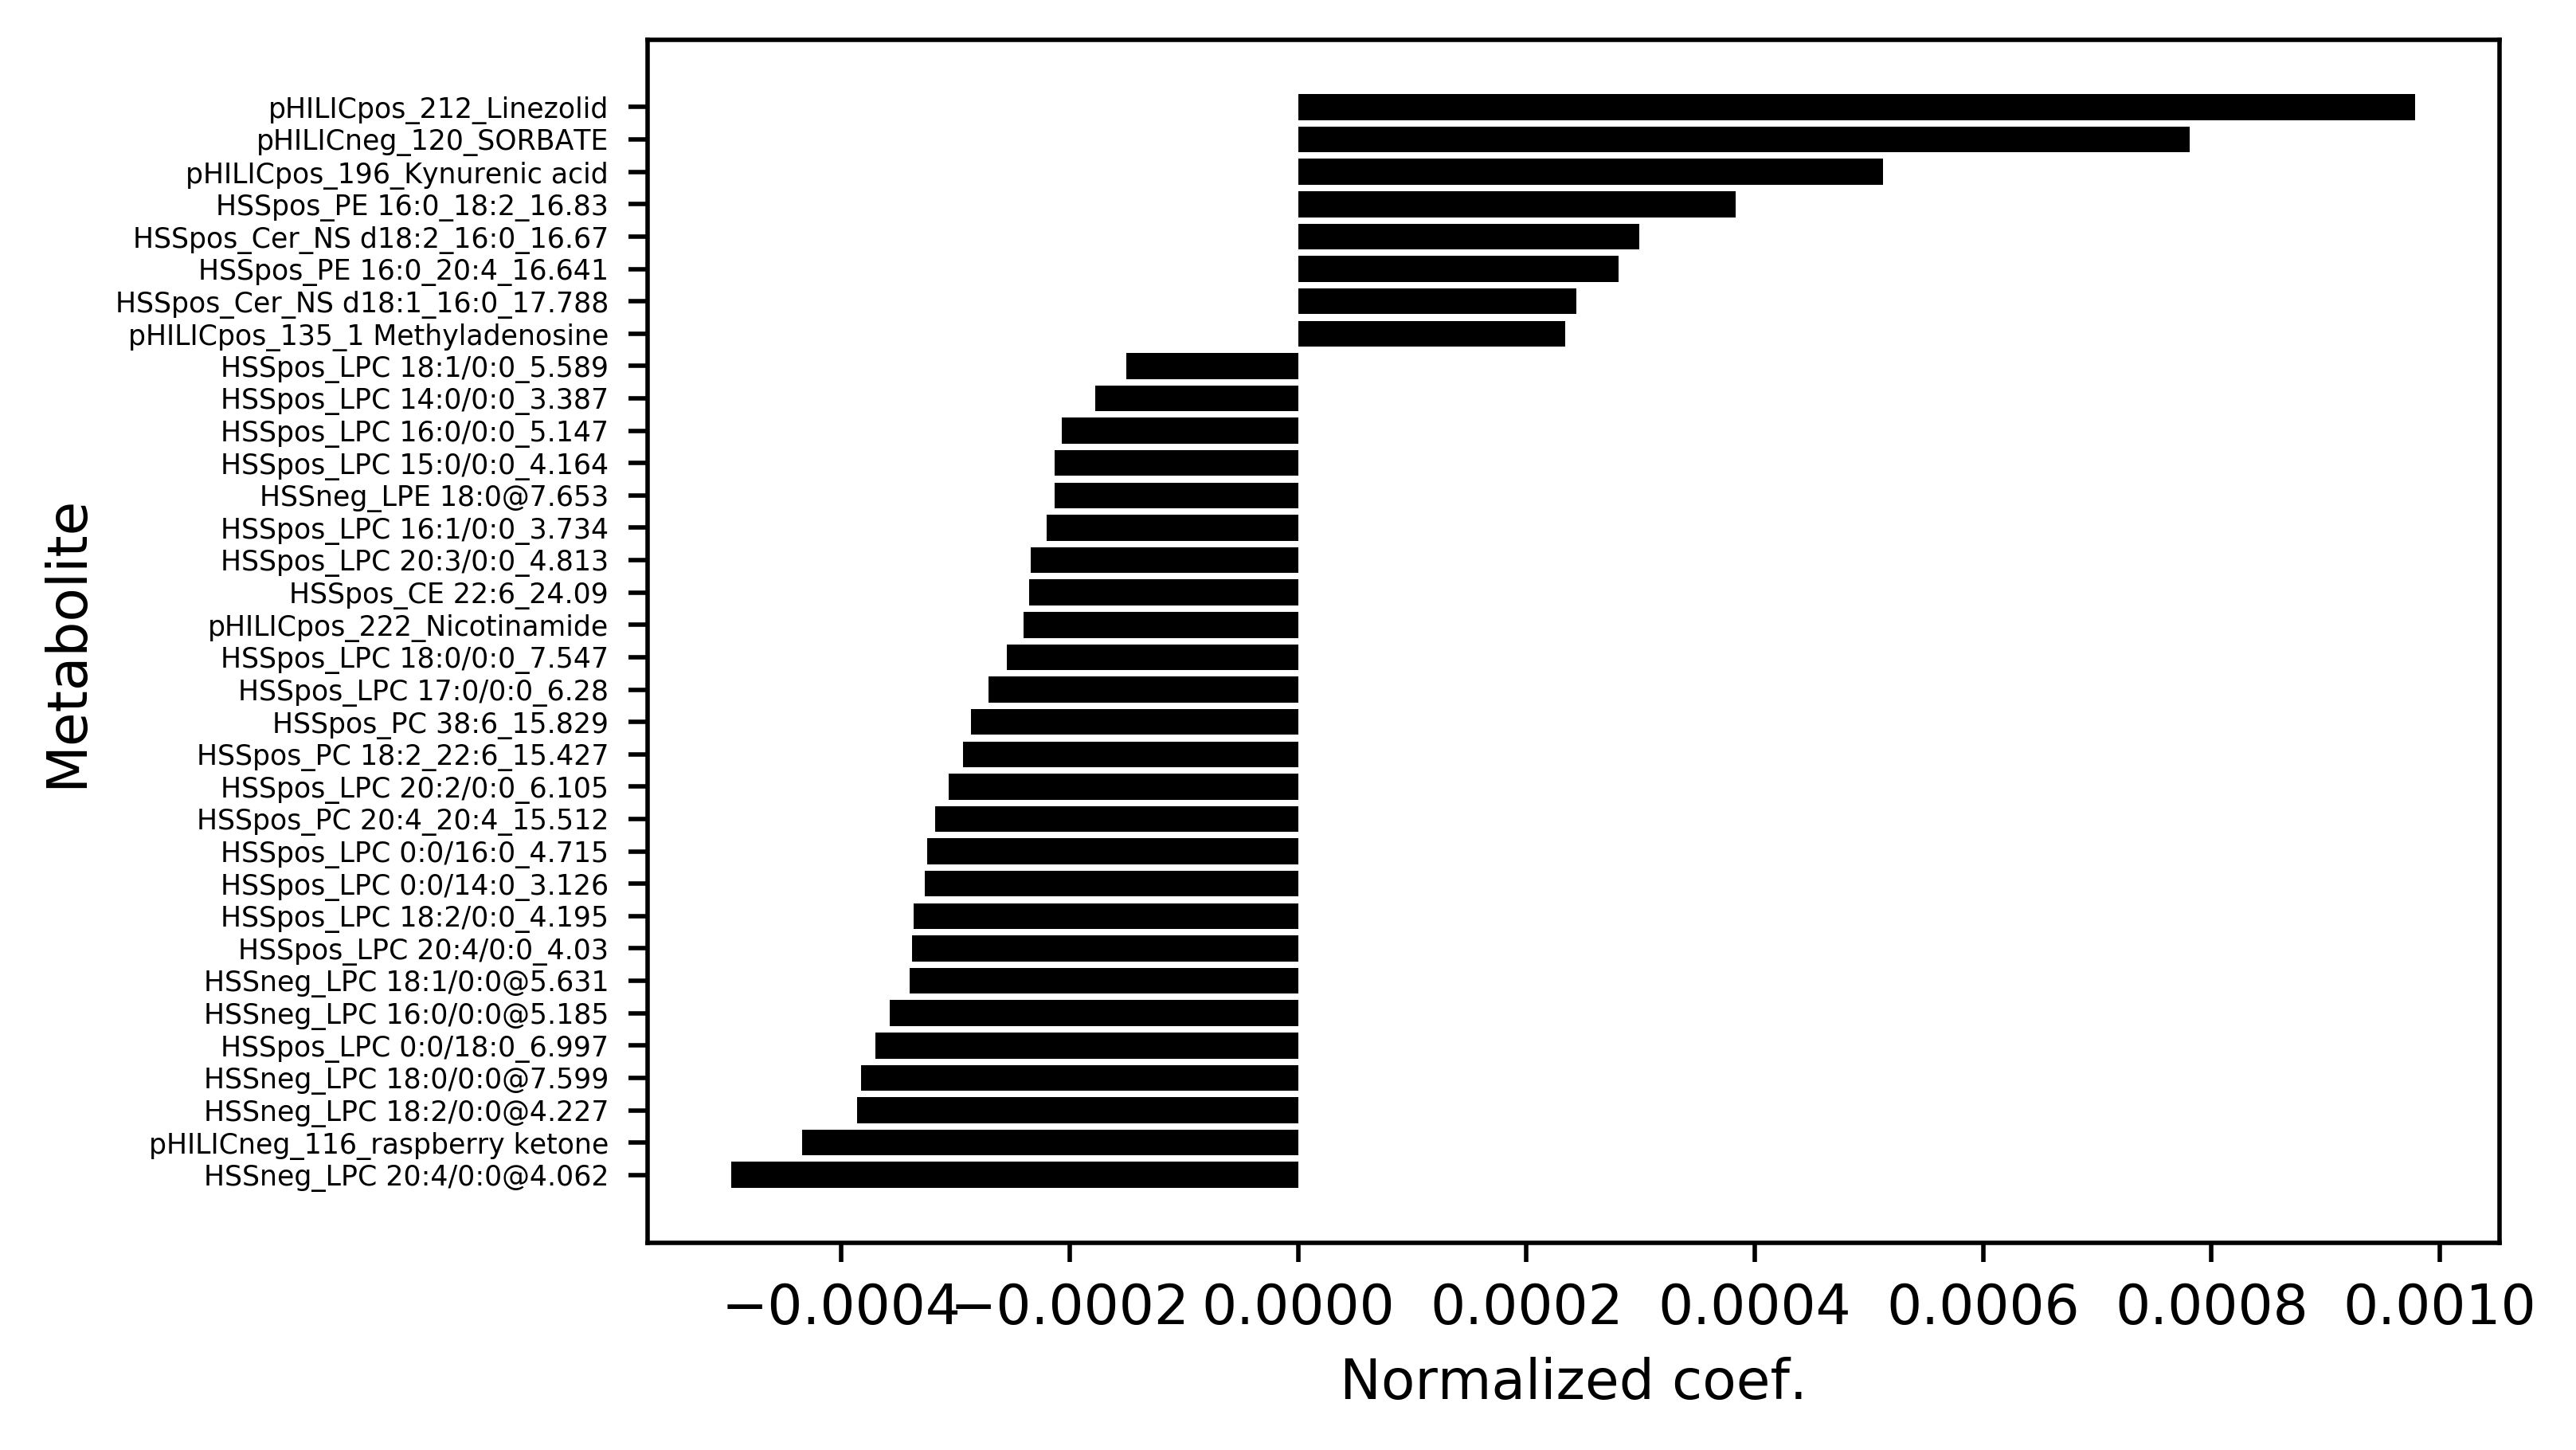

In [36]:
X_tot = np.concatenate((X[:,order[goodMets]],X_confirm[:,order[goodMets]]),axis=0)
y_tot = np.concatenate((y,y_confirm))
obj = trainFunc(X_tot,y_tot,
                X_blank[:,order[goodMets]],np.array(mol_names_sorted)[goodMets],mod_params)

var_imp = np.zeros((len(goodMets)))
var_imp[obj._selectedvars] = np.array(flatten(obj.coef_.tolist()))
var_imp = np.array([var_imp[x]/np.median(X_tot[:,x]) for x in range(len(var_imp))])

rel = var_imp[obj._selectedvars]
print(len([x for x in rel if np.abs(x) > 0]))
names =np.array(mol_names_sorted)[goodMets][obj._selectedvars]
o = list(range(len(rel)))
o.sort(key=lambda x:rel[x])
rel = rel[o]
names = names[o]
plt.barh(range(len(rel)),width = rel,color="black")
plt.yticks(range(len(goodMets)),mol_names_sorted[goodMets],fontsize=5)
plt.xlabel("Normalized coef.")
plt.ylabel("Metabolite")

#output sig mets
goodMetDict = {}
for x in range(len(goodMets)):
    goodMetDict[mol_names_sorted[goodMets][x]] = {"var_imp":var_imp[x]}


pd.DataFrame.from_dict(goodMetDict,orient="index").to_csv("../data/var_importance.csv")

In [ ]:
for met in goodMets:
    plt.figure()
    norm = 1#np.median(X[:,met])
    tempX = np.concatenate((X[:,order[met]],X_confirm[:,order[met]],X_val[:,order[met]]))
    tempy = np.concatenate((y,y_confirm,[-1 for x in X_val]))
    tempDict = {}
    
    for x,yy,i in zip(tempX,tempy,range(len(tempX))):
        tempDict[i] = {"ICU":yy,"Normalized Intensity":x}
    tempDf = pd.DataFrame.from_dict(tempDict,orient="index")
    sb.swarmplot(data=tempDf,x="ICU",y="Normalized Intensity")
    sb.boxplot(data=tempDf,x="ICU",y="Normalized Intensity")
    plt.title(mol_names_sorted[met] + " " + str(np.round(var_imp[met],5)))
    
    plt.xticks([0,1,2],["COVID-","ICU-","ICU+"])
    plt.xlabel("")

In [ ]:
selected_feats = helper.featureSelection(np.concatenate((X,X_confirm)),np.concatenate((y,y_confirm)),X_blank,mol_names,["stat",0.01,1.5],True,True)


In [ ]:
#need to partion age and run statistic

# X_baseline_met = np.concatenate((X_train[good_train_ind,:],X_test[good_test_ind,:]))
# not_corr = []
# pval = 0.05

# for met in goodMets:
    
#     good=True
#     plt.figure()
#     tempX_age = X_baseline[:,0]
#     tempX_bmi = X_baseline[:,1]

#     tempy = X_baseline_met[:,order[met]]
#     r,p = stats.pearsonr(tempX_age,tempy)
    
#     if p < pval:
#         good = False
    
#         lm = sklearn.linear_model.LinearRegression(fit_intercept=True)
#         lm.fit([[x] for x in tempX_age],tempy)
#         xx = np.linspace(min(tempX_age),max(tempX_age),100)
#         plt.plot(xx,lm.predict([[x] for x in xx]),color="blue")
#         plt.scatter(tempX_age,tempy,label="Age (years) p=" + str(np.round(p,4)) ,color="blue") 


# #     lm.fit([[x] for x in tempX_bmi],tempy)
# #     xx = np.linspace(min(tempX_bmi),max(tempX_bmi),100)
# #     r,p = stats.pearsonr(tempX_bmi,tempy)
    
# #     if p < pval:
# #         good = False
# #         plt.plot(xx,lm.predict([[x] for x in xx]),color="orange")
# #         plt.scatter(tempX_bmi,tempy,label="BMI p="+ str(np.round(p,4)),color="orange")

#     if good:
#         not_corr.append(met)
#     else:
#         plt.title(mol_names_sorted[met] + " " + str(np.round(var_imp[met],5)))
#         plt.xlabel("Correlate")
#         plt.ylabel("Normalized Metabolite Intensity")
#         plt.legend()

In [ ]:
# print(len(not_corr))
# for met in not_corr:
#     plt.figure()
#     norm = 1#np.median(X[:,met])
#     tempX = np.concatenate((X[:,order[met]],X_val[:,order[met]]))
#     tempy = np.concatenate((y,[-1 for x in X_val]))
#     tempDict = {}
    
#     for x,yy,i in zip(tempX,tempy,range(len(tempX))):
#         tempDict[i] = {"ICU":yy,"Normalized Intensity":x}
#     tempDf = pd.DataFrame.from_dict(tempDict,orient="index")
#     sb.swarmplot(data=tempDf,x="ICU",y="Normalized Intensity")
#     sb.boxplot(data=tempDf,x="ICU",y="Normalized Intensity")
#     plt.title(mol_names_sorted[met] + " " + str(np.round(var_imp[met],5)))
    
#     plt.xticks([0,1,2],["COVID-","ICU-","ICU+"])
#     plt.xlabel("")
    
#     plt.figure()
    
#     tempX_age = X_baseline[:,0]
#     tempX_bmi = X_baseline[:,1]

#     tempy = X_baseline_met[:,order[met]]
    

#     lm = sklearn.linear_model.LinearRegression(fit_intercept=True)
#     lm.fit([[x] for x in tempX_age],tempy)
#     xx = np.linspace(min(tempX_age),max(tempX_age),100)
#     plt.plot(xx,lm.predict([[x] for x in xx]),color="blue")
#     plt.scatter(tempX_age,tempy,label="Age (years) p=" + str(np.round(p,4)) ,color="blue") 


# #     lm.fit([[x] for x in tempX_bmi],tempy)
# #     xx = np.linspace(min(tempX_bmi),max(tempX_bmi),100)
# #     r,p = stats.pearsonr(tempX_bmi,tempy)
    
    
# #     plt.plot(xx,lm.predict([[x] for x in xx]),color="orange")
# #     plt.scatter(tempX_bmi,tempy,label="BMI p="+ str(np.round(p,4)),color="orange")

#     plt.title(mol_names_sorted[met] + " " + str(np.round(var_imp[met],5)))
#     plt.xlabel("Correlate")
#     plt.ylabel("Normalized Metabolite Intensity")
#     plt.legend()

In [ ]:
met = [x for x in range(len(mol_names)) if mol_names[x] == "HSSpos_LPC 0:0/18:0_6.997"][0] 
plt.figure()
norm = 1#np.median(X[:,met])
tempX = np.concatenate((X[:,met],X_val[:,met]))
tempy = np.concatenate((y,[-1 for x in X_val]))
tempDict = {}

for x,yy,i in zip(tempX,tempy,range(len(tempX))):
    tempDict[i] = {"ICU":yy,"Normalized Intensity":x}
tempDf = pd.DataFrame.from_dict(tempDict,orient="index")
sb.swarmplot(data=tempDf,x="ICU",y="Normalized Intensity")
sb.boxplot(data=tempDf,x="ICU",y="Normalized Intensity")
plt.title(mol_names[met])

plt.xticks([0,1,2],["COVID-","ICU-","ICU+"])
plt.xlabel("")